# **Imports and Constants**

In [20]:
# find spark
import findspark
findspark.init()

In [24]:
# imports
#from __future__ import print_function
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import PCA
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from mpl_toolkits.mplot3d import Axes3D
from functools import reduce
from pyspark import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, size, isnan, array_contains, when, count, pandas_udf, PandasUDFType
from pyspark.sql.types import *
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re
import pathlib
import json
import datetime
import numpy as np
import time
import os
import random
import statistics
import pathlib
import platform
import math

# comment for converting to .py file
########################################################
# %env variables
if platform.system() == 'Windows':
    %env PYSPARK_DRIVER_PYTHON = python
    %env PYSPARK_PYTHON = python
elif platform.system() == 'Linux':
    %env PYSPARK_DRIVER_PYTHON = python
    %env PYSPARK_PYTHON = python3
else:
    %env PYSPARK_DRIVER_PYTHON = python3.7
    %env PYSPARK_PYTHON = python3.7

# # incompatibility with Pyarrow
# #need to install Pyarrow 0.14.1 or lower or Set the environment variable ARROW_PRE_0_15_IPC_FORMAT=1
# %env ARROW_PRE_0_15_IPC_FORMAT = 1
########################################################

# used versions:
# spark='2.4.3' python='3.6' pyarrow='0.14.1'

# for new system:
# import findspark
# findspark.init()
# %pip install numpy
# %pip install -U matplotlib
# %pip install pandas
# %pip install Pyarrow==0.14.0
# %env PYSPARK_DRIVER_PYTHON=python
# %env PYSPARK_PYTHON=python

env: PYSPARK_DRIVER_PYTHON=python
env: PYSPARK_PYTHON=python3


In [25]:
#for macos
# !which python
# !python --version

# %env PYSPARK_DRIVER_PYTHON = python3.7
# %env PYSPARK_PYTHON = python3.7

In [45]:
# paths

BASE_PATH = "/home/soroush/Desktop/Code" #"/Users/Soroush/Desktop/Thesis/Code" #pathlib.Path().absolute()

KMEANS_REL_PATH = os.path.join(os.path.join(os.path.join(
    "Datasets", "Smart*"), "apartment"), "kmeans models")
DATASET_REL_PATH = os.path.join(
    os.path.join("Datasets", "Smart*"), "apartment")

RESULTS_REL_PATH=os.path.join(os.path.join(os.path.join(
    "Datasets", "Smart*"), "apartment"), "results")

STREAMING_REL_PATH=os.path.join(os.path.join(os.path.join(
    "Datasets", "Smart*"), "apartment"), "streaming")

DATASET_PATH = os.path.join(BASE_PATH, DATASET_REL_PATH)
KMEANS_PATH = os.path.join(BASE_PATH, KMEANS_REL_PATH)
RESULTS_PATH = os.path.join(BASE_PATH, RESULTS_REL_PATH)
STREAMING_PATH = os.path.join(BASE_PATH, STREAMING_REL_PATH)

print(DATASET_PATH)
print(KMEANS_PATH)
print(RESULTS_PATH)
print(STREAMING_PATH)

#from google.colab import drive
# drive.mount('/gdrive')

/home/soroush/Desktop/Code/Datasets/Smart*/apartment
/home/soroush/Desktop/Code/Datasets/Smart*/apartment/kmeans models
/home/soroush/Desktop/Code/Datasets/Smart*/apartment/results
/home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming


# **Dataset**

In [27]:
# load and save .read_pickle() and .to_pickle()

# save
# dataset.to_pickle(DATASET_PATH+"dataset.pkl")
# aggregated_dataset.to_pickle(DATASET_PATH+"aggregated_dataset.pkl")
# json_dataset.to_pickle(DATASET_PATH+"json_dataset.pkl")
# dataset.to_csv(DATASET_PATH+"dataset.csv")
# aggregated_dataset.to_csv(DATASET_PATH+"aggregated_dataset.csv")
# json_dataset.to_csv(DATASET_PATH+"json_dataset.csv")
# aggregated_dataset_rowBased.to_csv(DATASET_PATH+"aggregated_dataset_rowBased.csv")

# load
#dataset = pd.read_pickle(os.path.join(DATASET_PATH, 'dataset.pkl'))
#aggregated_dataset = pd.read_pickle(os.path.join(DATASET_PATH, 'aggregated_dataset.pkl'))

# **Functions**

## **Malicious Samples**

In [28]:
# Generate malicious samples
def h1(x):
    MAX = 0.8
    MIN = 0.1
    alpha = random.uniform(MIN, MAX)
    temp = np.array(x)
    return (temp*alpha).tolist()


def h2(x):
    MIN_OFF = 4  # hour
    DURATION = random.randint(MIN_OFF, 23)
    START = random.randint(0, 23-DURATION) if DURATION != 23 else 0
    END = START+DURATION
    temp = []
    for i in range(len(x)):
        if i < START or i >= END:
            temp.append(x[i])
        else:
            temp.append(0.0)
    return temp


def h3(x):
    MAX = 0.8
    MIN = 0.1
    temp = []
    for i in range(len(x)):
        temp.append(x[i]*random.uniform(MIN, MAX))
    return temp


def h4(x):
    MAX = 0.8
    MIN = 0.1
    mean = np.mean(x)
    temp = []
    for i in range(len(x)):
        temp.append(mean*random.uniform(MIN, MAX))
    return temp


def h5(x):
    MAX = 0.8
    MIN = 0.1
    mean = np.mean(x)
    temp = []
    for i in range(len(x)):
        temp.append(mean)
    return temp


def h6(x):
    temp = np.array(x)
    # temp=temp[::-1]
    temp = np.flipud(temp)
    return temp.tolist()


# add malicious samples
def create_malicious_df(sdf):
    def random_attack_assigner(x):
        NUMBER_OF_MALICIOUS_GENERATOR = 6
        res = []
        for row in x:
            rand = random.randint(1, NUMBER_OF_MALICIOUS_GENERATOR)
            if rand == 1:
                temp = (h1(row))
            elif rand == 2:
                temp = (h2(row))
            elif rand == 3:
                temp = (h3(row))
            elif rand == 4:
                temp = (h4(row))
            elif rand == 5:
                temp = (h5(row))
            elif rand == 6:
                temp = (h6(row))
            res.append(temp)
        return pd.Series(res)
    random_attack_assigner_UDF = pandas_udf(
        random_attack_assigner, returnType=ArrayType(FloatType()))
    # sdf_malicious=sdf
    N = False
    sdf = sdf.withColumn("N", f.lit(N))  # malicious sample
    # change '#' column number to negative
    sdf = sdf.withColumn("#", col("#")*-1)
    sdf = sdf.withColumn("power", random_attack_assigner_UDF(col("power")))
    # sdf=sdf.drop('statistics')
    sdf = sdf.withColumn("statistics", generate_feature_UDF(col("power")))
    sdf = add_statistics_column(sdf)  # for update statistics
    return sdf.select(sdf.columns)  # to reorder columns

In [29]:
# plot
def plot_malicious_samples(read_value, presence=[True, True, True, True, True, True, True]):

    if read_value == None:
        read_value = [3.4803431034088135, 2.529871702194214, 2.2175486087799072, 2.629481077194214, 2.9629790782928467, 2.0697860717773438, 2.900712251663208, 2.926414966583252, 4.8191237449646, 4.156486988067627, 2.6474769115448, 2.1933677196502686,
                      2.261159658432007, 2.340345621109009, 2.7386586666107178, 3.2414891719818115, 1.8946533203125, 3.1397650241851807, 2.8951449394226074, 3.4589333534240723, 2.726524829864502, 6.511429309844971, 3.4918391704559326, 3.787257432937622]
    lists = []
    colors = ['b', 'r-', 'g--', 'c:', 'm-.', 'y-', 'k--']
    if presence[0] == True:
        lists.append(read_value)
    if presence[1] == True:
        lists.append(h1(read_value))
    if presence[2] == True:
        lists.append(h2(read_value))
    if presence[3] == True:
        lists.append(h3(read_value))
    if presence[4] == True:
        lists.append(h4(read_value))
    if presence[5] == True:
        lists.append(h5(read_value))
    if presence[6] == True:
        lists.append(h6(read_value))
    #font = {'size': 12}
    #plt.rc('font', **font)
    plt.figure(num=None, figsize=(28, 16), dpi=120, facecolor='w',
               edgecolor='k')  # figsize=(14, 8), dpi=80
    plt.xlabel("time (hour)", fontsize=25)  # fontsize=18
    plt.ylabel("usage (kw)", fontsize=25)  # fontsize=18
    #plt.title("malicious samples")
    plt.xticks(np.arange(0, 24, step=1))
    plt.plot(read_value)
    for i in range(len(lists)):
        if i == 0:
            plt.plot(lists[i], colors[i], label='normal usage')
        else:
            plt.plot(lists[i], colors[i], label='attack %s' % i)
    # plt.legend()
    plt.legend(prop={'size': 20})  # prop={'size': 14}
    #plt.savefig('attack.pdf', bbox_inches='tight')
    #plt.savefig('attack.png', bbox_inches='tight')
    # plt.savefig('attack.eps', format='eps')
    #plt.show()
    
    return plt


#plot_malicious_samples(None,[True, True, True, True, True, True, True])

## **Prepare Spark Dataset**

In [30]:
# rename columns
def rename_dataframe(sdf):
    names = ['#', 'date', 'id', 'power']
    for c, n in zip(sdf.columns, names):
        sdf = sdf.withColumnRenamed(c, n)
    return sdf

# sdf=rename_dataframe(sdf)
# sdf.show()

# convert power to array


def string_power_to_array(sdf):
    temp = sdf.withColumn("power", f.regexp_replace(f.regexp_replace(f.col("power"), "\\[", ""), "\\]", "")
                          .alias("power"))
    temp = temp.withColumn("power", split(col("power"), ",\s*")
                           .cast(ArrayType(FloatType())).alias("power"))
    return temp

# sdf=string_power_to_array(sdf)
# sdf.show()


def add_validation_column(sdf):
    def validation(x):
        res = []
        for row in x:
            v = True
            if (len(row) != 24 or  # unusual size
                (row >= 0).sum() != 24 or  # number of valid elements = 24
                # sum(n >= 0 for n in row) != 24 or
                # equal or more than 3 zero elements
                np.count_nonzero(row == 0) >= 3 or
                    sum(n < 0 for n in row) > 0):  # not have negative element
                v = False
            res.append(v)
        return pd.Series(res)
    validation_UDF = pandas_udf(validation, returnType=BooleanType())
    temp = sdf.withColumn("V", validation_UDF(col("power")))
    return temp

# sdf=add_validation_column(sdf)
# sdf.show()


# add "N"ormal consumption ("N"onmalicious) column
def add_Normal_column(sdf):
    N = True
    temp = sdf.withColumn("N", f.lit(N))
    return temp

# sdf=add_Normal_column(sdf)
# sdf.show()

# filter data


def filter_dataset(sdf, from_date="BEGIN", to_date="END", ID="*", V="*"):
    temp = sdf
    if (from_date != "BEGIN"):
        temp = temp.filter(sdf.date > from_date)  # filter date (from X)
    if (to_date != "END"):
        temp = temp.filter(sdf.date < to_date)  # filter date (to Y)
    if (ID != "*"):
        temp = temp.filter(sdf.id == ID)  # filter IDs
    if (V != "*"):
        temp = temp.filter(sdf.V == V)  # filter validation
    return temp

# sdf=filter_dataset(sdf,from_date="BEGIN",to_date="END",ID="Apt36",V="True")
# sdf.show()


def split_power(sdf):
    temp = sdf.select("#", "date", "id",
                      sdf.power[0].alias("H0"), sdf.power[1].alias(
                          "H1"), sdf.power[2].alias("H2"), sdf.power[3].alias("H3"),
                      sdf.power[4].alias("H4"), sdf.power[5].alias(
                          "H5"), sdf.power[6].alias("H6"), sdf.power[7].alias("H7"),
                      sdf.power[8].alias("H8"), sdf.power[9].alias(
                          "H9"), sdf.power[10].alias("H10"), sdf.power[11].alias("H11"),
                      sdf.power[12].alias("H12"), sdf.power[13].alias(
                          "H13"), sdf.power[14].alias("H14"), sdf.power[15].alias("H15"),
                      sdf.power[16].alias("H16"), sdf.power[17].alias(
                          "H17"), sdf.power[18].alias("H18"), sdf.power[19].alias("H19"),
                      sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"), sdf.power[23].alias("H23"))
    return temp

# split_sdf=split_power(sdf)
# sdf.show()

# make id list
def get_ids(sdf):
    IDs = np.array(sdf.select("id").distinct().collect())
    #IDs = IDs.reshape(1, len(IDs))
    IDs = IDs.flatten() 
    return IDs

# number of instances per id
def get_instance_number_per_id(sdf):
    IDs = np.array(sdf.select("id").distinct().collect())
    IDs = IDs.flatten() 
    id_instance_dict =	{}
    
    for i in IDs:
        temp = sdf.filter(sdf.id == int(i))
        row_number = temp.count()
        id_instance_dict[int(i)] = row_number
    


# generate uniqe id
def generate_uniqe_id(sdf):
    temp = sdf
    temp = temp.withColumn("uid", f.concat(
        col("id"), f.lit("-"), col("#")).alias("uid"))
    return temp

# sdf=generate_uniqe_id(sdf)


# generate feature
def generate_feature(x):
    res = []
    for row in x:
        row = np.array(row)  # to numpy
        statistics = []
        min_val = np.nanmin(row)
        max_val = np.nanmax(row)
        mean_val = np.nanmean(row)
        std_val = np.nanstd(row)
        statistics.append(mean_val)
        statistics.append(std_val)
        statistics.append(min_val)
        statistics.append(max_val)
        res.append(statistics)
    return pd.Series(res)


generate_feature_UDF = pandas_udf(
    generate_feature, returnType=ArrayType(FloatType()))


def add_statistics_column(sdf):
    temp = sdf.withColumn("statistics", generate_feature_UDF(col("power")))
    return temp

# sdf=add_statistics_column(sdf)
# sdf.show()


# sdf.show()
# print("number of rows: " + str(sdf.count()))
# sdf.collect()
# sdf.printSchema()
# split_sdf=add_validation_column(split_sdf)

# **Models**

## **K-Means**

In [31]:
def prepare_for_kmeans(sdf):

    temp = sdf

    # define function for split power column
    def split(sdf):
        temp = sdf.select("#", "V", "N", "date", "id", "uid",
                          sdf.power[0].alias("H0"), sdf.power[1].alias(
                              "H1"), sdf.power[2].alias("H2"), sdf.power[3].alias("H3"),
                          sdf.power[4].alias("H4"), sdf.power[5].alias(
                              "H5"), sdf.power[6].alias("H6"), sdf.power[7].alias("H7"),
                          sdf.power[8].alias("H8"), sdf.power[9].alias(
                              "H9"), sdf.power[10].alias("H10"), sdf.power[11].alias("H11"),
                          sdf.power[12].alias("H12"), sdf.power[13].alias(
                              "H13"), sdf.power[14].alias("H14"), sdf.power[15].alias("H15"),
                          sdf.power[16].alias("H16"), sdf.power[17].alias(
                              "H17"), sdf.power[18].alias("H18"), sdf.power[19].alias("H19"),
                          sdf.power[20].alias("H20"), sdf.power[21].alias(
                              "H21"), sdf.power[22].alias("H22"), sdf.power[23].alias("H23"),
                          sdf.statistics[0].alias("S0"), sdf.statistics[1].alias("S1"), sdf.statistics[2].alias("S2"), sdf.statistics[3].alias("S3"))
        return temp

    # call the split_power function
    temp = split(temp)

    # filter date
    # temp=temp.filter(temp.date > "2014-08-15").filter(temp.date < "2014-08-19") #filter dates
    # temp=temp.filter(temp.id == "Apt40") #filter IDs
    temp = temp.filter(temp.V == True)  # filter valid rows

    FEATURES = ['H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11',
                'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'S0', 'S1', 'S2', 'S3']

    # call the generate_uniqe_id function
    temp = generate_uniqe_id(temp)

    # make ready
    vecAssembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    #df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))
    df_kmeans = vecAssembler.transform(
        temp).select(col("uid"), col("features"))
    return df_kmeans

In [74]:
# run k-means


def kmeans(sdf_kmeans):
    # find best k
    MAX_k = 8
    costs = np.zeros(MAX_k)
    silhouettes = np.zeros(MAX_k)
    silhouettes[1] = 0  # set value for k=1
    for k in range(2, MAX_k):
        kmeans = KMeans().setK(k).setSeed(1)
        model = kmeans.fit(sdf_kmeans)
        costs[k] = model.computeCost(sdf_kmeans)  # requires Spark 2.0 or later
        predictions = model.transform(sdf_kmeans)
        evaluator = ClusteringEvaluator()
        silhouettes[k] = evaluator.evaluate(predictions)

    # show silhouette
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(range(2, MAX_k), silhouettes[2:MAX_k])
    ax.set_xlabel('k')
    ax.set_ylabel('silhouette')

    # show cost
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(range(2, MAX_k), costs[2:MAX_k])
    ax.set_xlabel('k')
    ax.set_ylabel('cost')

    # find best k
    best_k = np.argmax(silhouettes)
    print("maximum value of silhouette is: " +
          str(silhouettes[best_k]) + " in index: " + str(best_k))

    # Trains a k-means model.
    kmeans = KMeans().setK(best_k).setSeed(1)
    model = kmeans.fit(sdf_kmeans)

    # Make predictions
    predictions = model.transform(sdf_kmeans)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
#     print("Silhouette with squared euclidean distance = " + str(silhouette))

#     # Shows the result.
#     centers = model.clusterCenters()
#     print("Cluster Centers: ")
#     for center in centers:
#         print(center)

#     transformed = model.transform(sdf_kmeans).select('id', 'prediction')
#     transformed.show()
#     transformed.groupby('prediction').count().show()
#     rows = transformed.collect()
#     prediction = spark.createDataFrame(rows)
#     prediction.show()
    return model, best_k, silhouette  # silhouettes: new

## **Decision Tree Methods**

In [33]:
def prepare_for_decision_tree_methods(sdf):

    temp = sdf

    # define function for split power column
    def split(sdf):
        temp = sdf.select("#", "V", "N", "date", "id", "uid",
                          sdf.power[0].alias("H0"), sdf.power[1].alias(
                              "H1"), sdf.power[2].alias("H2"), sdf.power[3].alias("H3"),
                          sdf.power[4].alias("H4"), sdf.power[5].alias(
                              "H5"), sdf.power[6].alias("H6"), sdf.power[7].alias("H7"),
                          sdf.power[8].alias("H8"), sdf.power[9].alias(
                              "H9"), sdf.power[10].alias("H10"), sdf.power[11].alias("H11"),
                          sdf.power[12].alias("H12"), sdf.power[13].alias(
                              "H13"), sdf.power[14].alias("H14"), sdf.power[15].alias("H15"),
                          sdf.power[16].alias("H16"), sdf.power[17].alias(
                              "H17"), sdf.power[18].alias("H18"), sdf.power[19].alias("H19"),
                          sdf.power[20].alias("H20"), sdf.power[21].alias(
                              "H21"), sdf.power[22].alias("H22"), sdf.power[23].alias("H23"),
                          sdf.statistics[0].alias("S0"), sdf.statistics[1].alias("S1"), sdf.statistics[2].alias("S2"), sdf.statistics[3].alias("S3"))
        return temp

    # call the split_power function
    temp = split(temp)

    # boolean to string (for "N" column)
    temp = temp.withColumn("N", f.col("N").cast('string'))
    # temp.printSchema()

    # filter date
    # temp=temp.filter(temp.date > "2014-08-15").filter(temp.date < "2014-08-19") #filter dates
    # temp=temp.filter(temp.id == "Apt40") #filter IDs
    temp = temp.filter(temp.V == True)  # filter valid rows

    FEATURES = ['H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11',
                'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'S0', 'S1', 'S2', 'S3']

    # call the generate_uniqe_id function
    # temp=generate_uniqe_id(temp)

    # make features ready
    assembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    output = assembler.transform(temp)
    #df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))

    # make label ready
    indexer = StringIndexer(inputCol="N", outputCol="NIndex")
    output_fixed = indexer.fit(output).transform(output)

    final_data = output_fixed.select("features", 'NIndex')
    return final_data

In [34]:
# run decision tree methods
def decision_tree(train_data, test_data):
    dtc = DecisionTreeClassifier(labelCol='NIndex', featuresCol='features')
    rfc = RandomForestClassifier(
        labelCol='NIndex', featuresCol='features')  # ,numTrees=100
    gbt = GBTClassifier(labelCol='NIndex', featuresCol='features')

    dtc_model = dtc.fit(train_data)
    rfc_model = rfc.fit(train_data)
    gbt_model = gbt.fit(train_data)

    dtc_predictions = dtc_model.transform(test_data)
    rfc_predictions = rfc_model.transform(test_data)
    gbt_predictions = gbt_model.transform(test_data)

    # evaluation
    # Select (prediction, true label) and compute test error
    acc_evaluator = MulticlassClassificationEvaluator(
        labelCol="NIndex", predictionCol="prediction", metricName="accuracy")

    dtc_acc = acc_evaluator.evaluate(dtc_predictions)
    rfc_acc = acc_evaluator.evaluate(rfc_predictions)
    gbt_acc = acc_evaluator.evaluate(gbt_predictions)

    # new:
    # Let's use the run-of-the-mill evaluator
    evaluator = BinaryClassificationEvaluator(labelCol='NIndex')
    # We have only two choices: area under ROC and PR curves :-(
    dtc_auroc = evaluator.evaluate(
        dtc_predictions, {evaluator.metricName: "areaUnderROC"})
    dtc_auprc = evaluator.evaluate(
        dtc_predictions, {evaluator.metricName: "areaUnderPR"})
    rfc_auroc = evaluator.evaluate(
        rfc_predictions, {evaluator.metricName: "areaUnderROC"})
    rfc_auprc = evaluator.evaluate(
        rfc_predictions, {evaluator.metricName: "areaUnderPR"})
    gbt_auroc = evaluator.evaluate(
        gbt_predictions, {evaluator.metricName: "areaUnderROC"})
    gbt_auprc = evaluator.evaluate(
        gbt_predictions, {evaluator.metricName: "areaUnderPR"})
    #print("DT Area under ROC Curve: {:.4f}".format(dtc_auroc))
    #print("DT Area under PR Curve: {:.4f}".format(dtc_auprc))
    #print("RF Area under ROC Curve: {:.4f}".format(rfc_auroc))
    #print("RF Area under PR Curve: {:.4f}".format(rfc_auprc))
    #print("GB Area under ROC Curve: {:.4f}".format(gbt_auroc))
    #print("GB Area under PR Curve: {:.4f}".format(gbt_auprc))

    #print('A single decision tree had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
    #print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
    #print('A ensemble using GBT had an accuracy of: {0:2.2f}%'.format(gbt_acc*100))

    return dtc_model,rfc_model,gbt_model,dtc_acc, dtc_auroc, dtc_auprc, rfc_acc, rfc_auroc, rfc_auprc, gbt_acc, gbt_auroc, gbt_auprc

## **PCA**

In [35]:
def prepare_for_pca(sdf):

    temp = sdf

    # define function for split power column
    def split_power(sdf):
        temp = sdf.select("#", "V", "N", "date", "id", "uid",
                          sdf.power[0].alias("H0"), sdf.power[1].alias(
                              "H1"), sdf.power[2].alias("H2"), sdf.power[3].alias("H3"),
                          sdf.power[4].alias("H4"), sdf.power[5].alias(
                              "H5"), sdf.power[6].alias("H6"), sdf.power[7].alias("H7"),
                          sdf.power[8].alias("H8"), sdf.power[9].alias(
                              "H9"), sdf.power[10].alias("H10"), sdf.power[11].alias("H11"),
                          sdf.power[12].alias("H12"), sdf.power[13].alias(
                              "H13"), sdf.power[14].alias("H14"), sdf.power[15].alias("H15"),
                          sdf.power[16].alias("H16"), sdf.power[17].alias(
                              "H17"), sdf.power[18].alias("H18"), sdf.power[19].alias("H19"),
                          sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"), sdf.power[23].alias("H23"))
        return temp

    # call the split_power function
    temp = split_power(temp)

    temp = temp.filter(temp.V == True)  # filter valid rows

    FEATURES = ['H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11',
                'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23']

    # call the generate_uniqe_id function
    temp = generate_uniqe_id(temp)

    # make ready
    vecAssembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    #df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))
    df_pca = vecAssembler.transform(temp).select(
        "#", "V", "N", "date", "id", "uid", col("features"))
    return df_pca


def pca_for_tree(sdf):
    #sdf = prepare_for_pca(sdf)
    pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
    model = pca.fit(sdf)
    result = model.transform(sdf).select(
        "NIndex", col("pcaFeatures").alias("features"))
    return result


def pca_for_kmeans(sdf):
    #sdf = prepare_for_pca(sdf)
    pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
    model = pca.fit(sdf)
    result = model.transform(sdf).select(
        "uid", col("pcaFeatures").alias("features"))
    return result


# sdf_pca=pca(sdf)
# sdf_pca.show() #truncate=False

## **MLP**

In [36]:
def prepare_for_mlp(sdf):

    temp = sdf

    # define function for split power column
    def split(sdf):
        temp = sdf.select("#", "V", "N", "date", "id", "uid",
                          sdf.power[0].alias("H0"), sdf.power[1].alias(
                              "H1"), sdf.power[2].alias("H2"), sdf.power[3].alias("H3"),
                          sdf.power[4].alias("H4"), sdf.power[5].alias(
                              "H5"), sdf.power[6].alias("H6"), sdf.power[7].alias("H7"),
                          sdf.power[8].alias("H8"), sdf.power[9].alias(
                              "H9"), sdf.power[10].alias("H10"), sdf.power[11].alias("H11"),
                          sdf.power[12].alias("H12"), sdf.power[13].alias(
                              "H13"), sdf.power[14].alias("H14"), sdf.power[15].alias("H15"),
                          sdf.power[16].alias("H16"), sdf.power[17].alias(
                              "H17"), sdf.power[18].alias("H18"), sdf.power[19].alias("H19"),
                          sdf.power[20].alias("H20"), sdf.power[21].alias(
                              "H21"), sdf.power[22].alias("H22"), sdf.power[23].alias("H23"),
                          sdf.statistics[0].alias("S0"), sdf.statistics[1].alias("S1"), sdf.statistics[2].alias("S2"), sdf.statistics[3].alias("S3"))
        return temp

    # call the split_power function
    temp = split(temp)

    # boolean to string (for "N" column)
    temp = temp.withColumn("N", f.col("N").cast('string'))
    # temp.printSchema()

    # filter date
    # temp=temp.filter(temp.date > "2014-08-15").filter(temp.date < "2014-08-19") #filter dates
    # temp=temp.filter(temp.id == "Apt40") #filter IDs
    temp = temp.filter(temp.V == True)  # filter valid rows

    FEATURES = ['H0', 'H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11',
                'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'S0', 'S1', 'S2', 'S3']

    # call the generate_uniqe_id function
    # temp=generate_uniqe_id(temp)

    # make features ready
    assembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    output = assembler.transform(temp)
    #df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))

    # make label ready
    indexer = StringIndexer(inputCol="N", outputCol="label")
    output_fixed = indexer.fit(output).transform(output)

    final_data = output_fixed.select("features", 'label')
    return final_data

In [37]:
# run mlp method
def mlp(train_data, test_data, layers=[28, 50, 10, 2]):
    # specify layers for the neural network:
    # input layer of size 4 (features), two intermediate of size 5 and 4
    # and output of size 3 (classes)

    # create the trainer and set its parameters
    trainer = MultilayerPerceptronClassifier(
        maxIter=100, layers=layers, blockSize=128, seed=1234)

    # train_data.show()
    # train the model
    model = trainer.fit(train_data)

    # compute accuracy on the test set
    result = model.transform(test_data)
    predictionAndLabels = result.select("prediction", "label")
    evaluator = MulticlassClassificationEvaluator(
        metricName="accuracy")  # BinaryClassificationEvaluator
    acc = evaluator.evaluate(predictionAndLabels)
    print("Test set accuracy = " + str(acc))
    return acc

# **Main**

## **Create sdf**

### **Basic**

In [38]:
# # create SparkSession
spark = SparkSession.builder.appName(
    "anomaly_detection").master("local[20]").getOrCreate()
# # network problem? type it in commandline: sudo hostname -s 127.0.0.1

# # define schema
# schema = StructType([
#     StructField("#", IntegerType()),
#     StructField("date", TimestampType()),
#     StructField("id", StringType()),
#     StructField("power", StringType())])

# # read data
# sdf = spark.read.format('csv').options(header='true', inferSchema=True, schema=schema).load(
#     os.path.join(DATASET_PATH, 'aggregated_dataset_rowBased.csv'))


# sdf = rename_dataframe(sdf)
# sdf = string_power_to_array(sdf)
# sdf = add_statistics_column(sdf)
# sdf = add_validation_column(sdf)
# sdf = add_Normal_column(sdf)
# sdf = filter_dataset(sdf, from_date="BEGIN",
#                      to_date="END", ID="*", V="True")  # 2016-07-01: 75%
# sdf = generate_uniqe_id(sdf)

# # ids
# id_list = get_ids(sdf)

# # #dataset
# # print("dataframe schema:")
# # print("number of rows: " + str(sdf.count()))
# # sdf.printSchema()
# print("benign dataframe (sdf):")
# sdf.show()

# # #generate malicious data
# #sdf_malicious = create_malicious_df(sdf)
# #print("malicious dataframe (sdf_malicious):")
# # sdf_malicious.show()

# #sdf_mix = sdf.union(sdf_malicious)
# #print("final dataframe (sdf_mix):")
# # sdf_mix.show()

## **Load sdf**

In [39]:
def load_train_dataset():
    sdf_train = spark.createDataFrame(pd.read_pickle(
        os.path.join(DATASET_PATH, "smart*_train.pkl")))  # load and convert to spark
    return sdf_train


def load_test_dataset():
    sdf_test = spark.createDataFrame(pd.read_pickle(
        os.path.join(DATASET_PATH, "smart*_test.pkl")))  # load and convert to spark
    return sdf_test


def load_dataset():
    sdf = spark.createDataFrame(pd.read_pickle(
        os.path.join(DATASET_PATH, "smart*.pkl")))
        #"/Users/Soroush/Desktop/Thesis/Code/Datasets/Smart*/apartment/smart*.pkl"))
    # os.path.join(DATASET_PATH, "smart*.pkl")))  # load and convert to spark
    return sdf


#sdf_train = load_train_dataset()
#sdf_test = load_test_dataset()
sdf = load_dataset()

# print("sdf:")
# sdf.show()
# print("train sdf:")
# sdf_train.show()
# print("test sdf:")
# sdf_test.show()

### **Split (to train and test)**

In [11]:
# 75%-25%: 2016-07-01 in filter function
# train
# sdf.select("*").toPandas().to_pickle(os.path.join(DATASET_PATH,"smart*_train.pkl")) #convert to pandas and save .csv
# test
# sdf.select("*").toPandas().to_pickle(os.path.join(DATASET_PATH,"smart*_test.pkl")) #convert to pandas and save .csv
# standard
# sdf.select("*").toPandas().to_pickle(os.path.join(DATASET_PATH,"smart*.pkl")) #convert to pandas and save .csv

In [28]:
# for descending order
# sdf.sort(col("date").desc()).show()
# collect a row
# sdf.collect()[8027][3] #[8027][3] is used for figure

+----+-------------------+-----+--------------------+--------------------+----+----+----------+
|   #|               date|   id|               power|          statistics|   V|   N|       uid|
+----+-------------------+-----+--------------------+--------------------+----+----+----------+
|3074|2016-06-30 00:00:00|Apt14|[0.12692694, 0.08...|[0.67732, 0.63663...|true|true|Apt14-3074|
|3073|2016-06-29 00:00:00|Apt14|[0.13801529, 0.09...|[0.9129904, 1.022...|true|true|Apt14-3073|
|3072|2016-06-28 00:00:00|Apt14|[0.09738639, 0.04...|[0.6853187, 0.604...|true|true|Apt14-3072|
|3071|2016-06-27 00:00:00|Apt14|[0.12814473, 0.07...|[0.7695992, 0.869...|true|true|Apt14-3071|
|3070|2016-06-26 00:00:00|Apt14|[0.09284167, 0.09...|[0.91303325, 1.06...|true|true|Apt14-3070|
|3069|2016-06-25 00:00:00|Apt14|[0.08049333, 0.09...|[0.7376778, 0.734...|true|true|Apt14-3069|
|3068|2016-06-24 00:00:00|Apt14|[0.09175944, 0.05...|[0.59617877, 0.51...|true|true|Apt14-3068|
|3067|2016-06-23 00:00:00|Apt14|[0.08002

## **Collect Daily Vector**

In [40]:
def collect_daily_vector(user_id,date):
    daily_power = sdf.filter(sdf["id"] == user_id).filter(sdf["date"] == date).select(sdf["power"]).collect()[0][0]
    return daily_power


#collect_daily_vector("Apt1","2016-07-01")

## **Streaming**

## **Run K-Means**

-------------------- k-means started!
customer 1: Apt14
maximum value of silhouette is: 0.6096587461905046 in index: 2
AAAAAAAAAA
+-----+---+------------------+
|   id|  k|        Silhouette|
+-----+---+------------------+
|Apt14|  2|0.6096587461905046|
+-----+---+------------------+



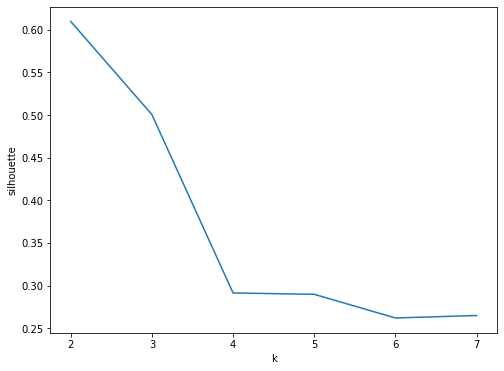

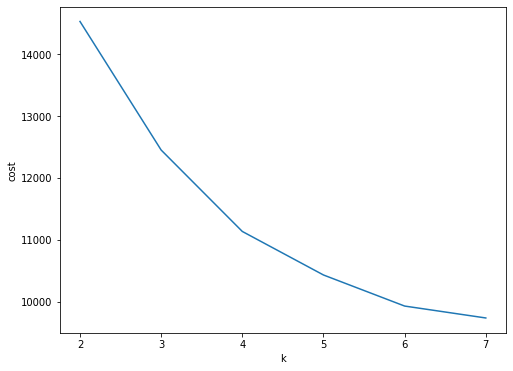

In [24]:
# kmeans separately


def call_kmeans(sdf):

    # create statistics dataframe
    kmeans_statistics_schema = StructType([
        StructField("id", StringType()),
        StructField("k", IntegerType()),
        StructField("Silhouette", FloatType())])

    kmeans_statistics = spark.createDataFrame([], kmeans_statistics_schema)

    id_list = get_ids(sdf)
    # replace sdf with final_sdf for clustring benign and malicious data
    sdf_kmeans = prepare_for_kmeans(sdf)
    # sdf_kmeans=pca_for_kmeans(sdf_kmeans) #0.8725788926917551 to 0.9101118371931005
    # sdf_kmeans.show()
    iteration = 1
    for i in np.nditer(id_list):
        sdf_kmeans_by_id = sdf_kmeans.filter(
            sdf_kmeans.uid.like(str(i)+"-"+"%"))  # filter IDs
        print("customer " + str(iteration)+": " + str(i))
        # sdf_kmeans_by_id.show()
        kmeans_model, best_k, silhouette = kmeans(sdf_kmeans_by_id)
        # kmeans_model.save(os.path.join(KMEANS_PATH,str(i)))
        summary = kmeans_model.summary
        if summary.clusterSizes[1] > 200:
            print("AAAAAAAAAA")
        else:
            print("BBBBBBBBBB")

        newRow_for_statistics = spark.createDataFrame(
            [(str(i), int(best_k), float(silhouette))])
        kmeans_statistics = kmeans_statistics.union(newRow_for_statistics)

        iteration += 1
        # model_name = KMeansModel.load(os.path.join(KMEANS_PATH,str(i)) #for load model
    return kmeans_statistics


#print("-------------------- k-means started!")
#kmeans_statistics = call_kmeans(sdf)
#kmeans_statistics.show()
# save
# result_pdf = kmeans_statistics.select("*").toPandas()
# result_pdf.to_pickle(os.path.join(BASE_PATH, 'kmeans_statistics.pkl'))
# load
#df = pd.read_pickle(os.path.join(BASE_PATH, 'kmeans_statistics.pkl'))
# df.head()
# df.describe()

## **Run Decision Tree**

In [43]:
# decision tree separately
def call_trees(sdf):

    # create statistics dataframe
    trees_statistics_schema = StructType([
        StructField("id", StringType()),
        StructField("dtc_acc", FloatType()),
        StructField("dtc_auroc", FloatType()),
        StructField("dtc_auprc", FloatType()),
        StructField("rfc_acc", FloatType()),
        StructField("rfc_auroc", FloatType()),
        StructField("rfc_auprc", FloatType()),
        StructField("gbt_acc", FloatType()),
        StructField("gbt_auroc", FloatType()),
        StructField("gbt_auprc", FloatType())])

    trees_statistics = spark.createDataFrame([], trees_statistics_schema)

    id_list = get_ids(sdf)

    iteration = 1
    for i in np.nditer(id_list):
        sdf_trees_by_id = sdf.filter(
            sdf.uid.like(str(i)+"-"+"%"))  # filter IDs
        print("customer " + str(iteration)+": " + str(i))

        sdf_trees_by_id_malicious = create_malicious_df(sdf_trees_by_id)
        sdf_trees_by_id_mixed = sdf_trees_by_id.union(
            sdf_trees_by_id_malicious)

        # sdf_trees=prepare_for_decision_tree_methods(sdf)

        sdf_trees = prepare_for_decision_tree_methods(sdf_trees_by_id_mixed)
        train_data, test_data = sdf_trees.randomSplit([0.7, 0.3])

        dtc_model,rfc_model,gbt_model,dtc_acc, dtc_auroc, dtc_auprc, rfc_acc, rfc_auroc, rfc_auprc, gbt_acc, gbt_auroc, gbt_auprc = decision_tree(
            train_data, test_data)

        print('A single decision tree had an accuracy of: {0:2.2f}%'.format(
            dtc_acc*100))
        print("DT Area under ROC Curve: {:.4f}".format(dtc_auroc))
        print("DT Area under PR Curve: {:.4f}".format(dtc_auprc))
        print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(
            rfc_acc*100))
        print("RF Area under ROC Curve: {:.4f}".format(rfc_auroc))
        print("RF Area under PR Curve: {:.4f}".format(rfc_auprc))
        print('A ensemble using GBT had an accuracy of: {0:2.2f}%'.format(
            gbt_acc*100))
        print("GB Area under ROC Curve: {:.4f}".format(gbt_auroc))
        print("GB Area under PR Curve: {:.4f}".format(gbt_auprc))

        newRow_for_statistics = spark.createDataFrame([(str(i), float(dtc_acc), float(dtc_auroc), float(dtc_auprc),
                                                        float(rfc_acc), float(
                                                            rfc_auroc), float(rfc_auprc),
                                                        float(gbt_acc), float(gbt_auroc), float(gbt_auprc))])
        trees_statistics = trees_statistics.union(newRow_for_statistics)

        iteration += 1
    return trees_statistics


#print("-------------------- decision tree started!")
trees_statistics=call_trees(sdf)
trees_statistics.show()
# save
# result_pdf = trees_statistics.select("*").toPandas()
# result_pdf.to_pickle(os.path.join(BASE_PATH, 'trees_statistics.pkl'))
# load
#df = pd.read_pickle(os.path.join(BASE_PATH, 'all_statistics_trees_k1.pkl'))
#df.head()
#df.describe()

customer 1: Apt107
A single decision tree had an accuracy of: 81.44%
DT Area under ROC Curve: 0.8612
DT Area under PR Curve: 0.7591
A random forest ensemble had an accuracy of: 88.04%
RF Area under ROC Curve: 0.9526
RF Area under PR Curve: 0.9309
A ensemble using GBT had an accuracy of: 91.34%
GB Area under ROC Curve: 0.9713
GB Area under PR Curve: 0.9428
customer 2: Apt21
A single decision tree had an accuracy of: 77.67%
DT Area under ROC Curve: 0.8664
DT Area under PR Curve: 0.8366
A random forest ensemble had an accuracy of: 86.10%
RF Area under ROC Curve: 0.9251
RF Area under PR Curve: 0.9068
A ensemble using GBT had an accuracy of: 88.34%
GB Area under ROC Curve: 0.9451
GB Area under PR Curve: 0.9441
customer 3: Apt8


KeyboardInterrupt: 

## **Run MLP**

In [22]:
# mlp separetely
def call_mlp(sdf):

    # create statistics dataframe
    mlp_statistics_schema = StructType([
        StructField("id", StringType()),
        StructField("mlp", FloatType())])

    mlp_statistics = spark.createDataFrame([], mlp_statistics_schema)

    id_list = get_ids(sdf)

    iteration = 1
    for i in np.nditer(id_list):
        sdf_trees_by_id = sdf.filter(
            sdf.uid.like(str(i)+"-"+"%"))  # filter IDs
        print("customer " + str(iteration)+": " + str(i))

        sdf_mlp = prepare_for_mlp(sdf)
        train_data, test_data = sdf_mlp.randomSplit([0.7, 0.3])

        acc = mlp(train_data, test_data, [28, 60, 10, 2])

        print('A MLP had an accuracy of: {0:2.2f}%'.format(acc*100))

        newRow_for_statistics = spark.createDataFrame([(str(i), float(acc))])
        mlp_statistics = mlp_statistics.union(newRow_for_statistics)

        iteration += 1
    return mlp_statistics

#print("-------------------- mlp started!")
# run
# mlp_statistics=call_mlp(sdf_mix)
# mlp_statistics.show()

# save
#df = statistics.select("*").toPandas()
#df.to_pickle(os.path.join(BASE_PATH, 'mlp_statistics.pkl'))

# load
#df = pd.read_pickle(os.path.join(BASE_PATH, 'mlp_statistics.pkl'))
# df.head()
# df.describe()

## **Run Complex Models**

### **Run Tree Model**

customer 1: Apt107
maximum value of silhouette is: 0.6163540475741492 in index: 2
Silhouette with squared euclidean distance = 0.6163540475741492
best k= 2
A single decision tree had an accuracy of: 91.00%
DT Area under ROC Curve: 0.8367
DT Area under PR Curve: 0.8517
A random forest ensemble had an accuracy of: 91.94%
RF Area under ROC Curve: 0.9364
RF Area under PR Curve: 0.9779
A ensemble using GBT had an accuracy of: 91.00%
GB Area under ROC Curve: 0.9417
GB Area under PR Curve: 0.9403
A single decision tree had an accuracy of: 84.62%
DT Area under ROC Curve: 0.6493
DT Area under PR Curve: 0.8314
A random forest ensemble had an accuracy of: 89.07%
RF Area under ROC Curve: 0.9561
RF Area under PR Curve: 0.9594
A ensemble using GBT had an accuracy of: 83.81%
GB Area under ROC Curve: 0.9303
GB Area under PR Curve: 0.9414
customer 2: Apt21
maximum value of silhouette is: 0.522049743606537 in index: 2
Silhouette with squared euclidean distance = 0.522049743606537
best k= 2
A single deci

KeyboardInterrupt: 

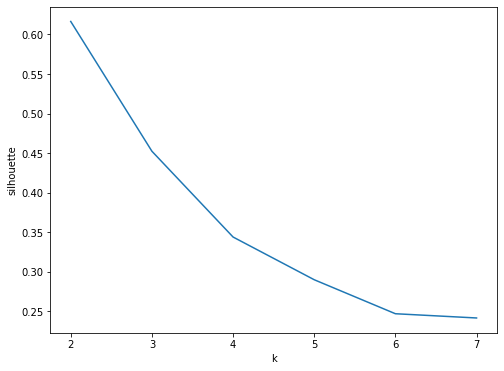

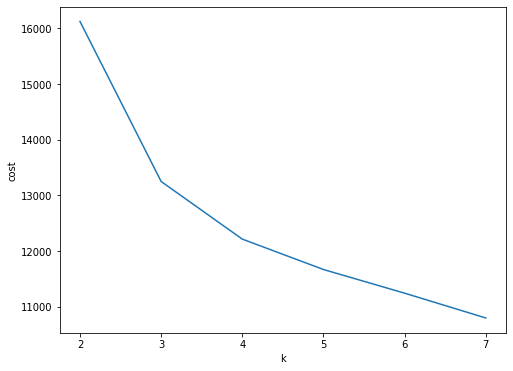

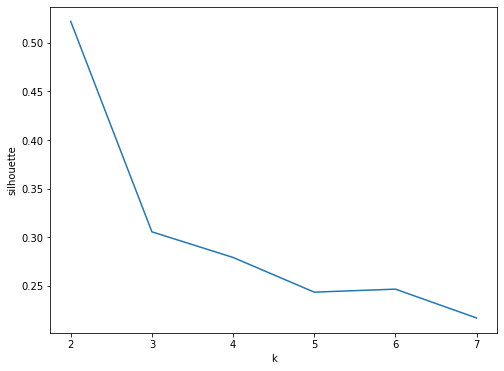

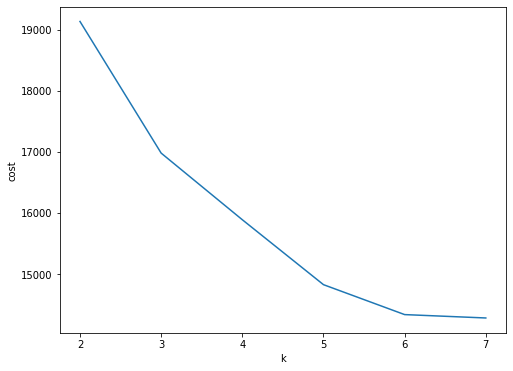

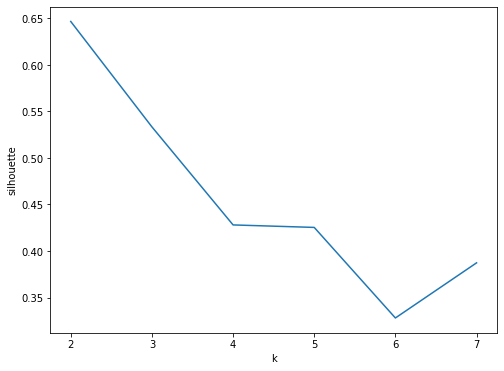

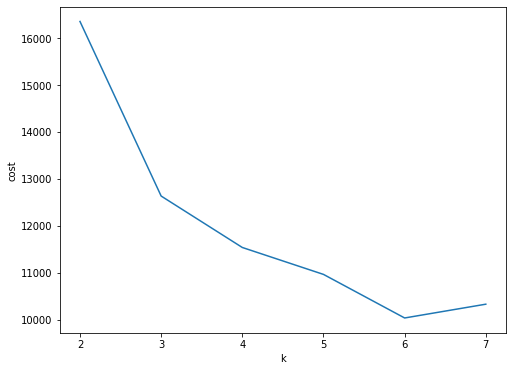

In [41]:
# model tree
def call_model_with_tree(sdf):
    id_list = get_ids(sdf)

    # create statistics dataframe
    statistics_schema = StructType([
        StructField("id", StringType()),
        StructField("k", IntegerType()),
        StructField("Silhouette", FloatType()),
        StructField("n_per_k", ArrayType(IntegerType())),
        StructField("dtc_acc", ArrayType(FloatType())),
        StructField("dtc_auroc", ArrayType(FloatType())),
        StructField("dtc_auprc", ArrayType(FloatType())),
        StructField("rfc_acc", ArrayType(FloatType())),
        StructField("rfc_auroc", ArrayType(FloatType())),
        StructField("rfc_auprc", ArrayType(FloatType())),
        StructField("gbt_acc", ArrayType(FloatType())),
        StructField("gbt_auroc", ArrayType(FloatType())),
        StructField("gbt_auprc", ArrayType(FloatType()))])

    statistics = spark.createDataFrame([], statistics_schema)

    iteration = 1
    for i in np.nditer(id_list):
        sdf_by_id = sdf.filter(sdf.uid.like(str(i)+"-"+"%"))  # filter IDs
        print("customer " + str(iteration)+": " + str(i))

        sdf_kmeans = prepare_for_kmeans(sdf_by_id)

        # sdf_kmeans=pca_for_kmeans(sdf_kmeans)

        #train_data,test_data = sdf_kmeans.randomSplit([0.7,0.3])
        kmeans_model, best_k, silhouette = kmeans(sdf_kmeans)
        print("Silhouette with squared euclidean distance = " + str(silhouette))
        print("best k= " + str(best_k))

        transformed = kmeans_model.transform(
            sdf_kmeans).select('uid', 'prediction', 'features')
        # transformed.show()
        sdf_join = transformed.join(sdf_by_id, on=['uid'], how='inner')
        # sdf_join.show()

        # define statistics variables
        n_per_k = []
        dtc_acc_list = []
        dtc_auroc_list = []
        dtc_auprc_list = []
        rfc_acc_list = []
        rfc_auroc_list = []
        rfc_auprc_list = []
        gbt_acc_list = []
        gbt_auroc_list = []
        gbt_auprc_list = []

        for k in range(0, best_k):
            temp_sdf = sdf_join.filter(sdf_join.prediction == k)
            temp_sdf_malicious = create_malicious_df(temp_sdf)
            temp_sdf_mixed = temp_sdf.union(temp_sdf_malicious)
            tree_data = prepare_for_decision_tree_methods(temp_sdf_mixed)

            # tree_data=pca_for_tree(tree_data)

            train_data, test_data = tree_data.randomSplit([0.7, 0.3])
            dtc_model,rfc_model,gbt_model,dtc_acc, dtc_auroc, dtc_auprc, rfc_acc, rfc_auroc, rfc_auprc, gbt_acc, gbt_auroc, gbt_auprc = decision_tree(
                train_data, test_data)
            print('A single decision tree had an accuracy of: {0:2.2f}%'.format(
                dtc_acc*100))
            print("DT Area under ROC Curve: {:.4f}".format(dtc_auroc))
            print("DT Area under PR Curve: {:.4f}".format(dtc_auprc))
            print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(
                rfc_acc*100))
            print("RF Area under ROC Curve: {:.4f}".format(rfc_auroc))
            print("RF Area under PR Curve: {:.4f}".format(rfc_auprc))
            print('A ensemble using GBT had an accuracy of: {0:2.2f}%'.format(
                gbt_acc*100))
            print("GB Area under ROC Curve: {:.4f}".format(gbt_auroc))
            print("GB Area under PR Curve: {:.4f}".format(gbt_auprc))

            n_per_k.append(int(temp_sdf.count()))
            dtc_acc_list.append(float(dtc_acc))
            dtc_auroc_list.append(float(dtc_auroc))
            dtc_auprc_list.append(float(dtc_auprc))
            rfc_acc_list.append(float(rfc_acc))
            rfc_auroc_list.append(float(rfc_auroc))
            rfc_auprc_list.append(float(rfc_auprc))
            gbt_acc_list.append(float(gbt_acc))
            gbt_auroc_list.append(float(gbt_auroc))
            gbt_auprc_list.append(float(gbt_auprc))

        # update statistics
        newRow_for_statistics = spark.createDataFrame([(str(i), int(best_k), float(silhouette), n_per_k,
                                                        dtc_acc_list, dtc_auroc_list, dtc_auprc_list,
                                                        rfc_acc_list, rfc_auroc_list, rfc_auprc_list,
                                                        gbt_acc_list, gbt_auroc_list, gbt_auprc_list)])
        statistics = statistics.union(newRow_for_statistics)

        iteration += 1

    return statistics

statistics=call_model_with_tree(sdf)
statistics.show()

# save
# result_pdf = statistics.select("*").toPandas()
# result_pdf.to_pickle(os.path.join(BASE_PATH, 'statistics.pkl'))


# load
#df = pd.read_pickle(os.path.join(BASE_PATH, 'all_statistics_trees_k2to5.pkl'))
#df.head()

# output of model
#df['dtc_acc_agg'] = [np.dot(df.n_per_k.to_numpy()[i],df.dtc.to_numpy()[i])/sum(df.n_per_k.to_numpy()[i]) for i in range(0,len(df.n_per_k.to_numpy()))]
#df['rfc_acc_agg'] = [np.dot(df.n_per_k.to_numpy()[i],df.rfc.to_numpy()[i])/sum(df.n_per_k.to_numpy()[i]) for i in range(0,len(df.n_per_k.to_numpy()))]
#df['gbt_acc_agg'] = [np.dot(df.n_per_k.to_numpy()[i],df.gbt.to_numpy()[i])/sum(df.n_per_k.to_numpy()[i]) for i in range(0,len(df.n_per_k.to_numpy()))]
# df.head(20)
# df.describe()

### **Run MLP Model**

In [24]:
# model mlp
def call_model_with_mlp(sdf):
    id_list = get_ids(sdf)

    # create statistics dataframe
    statistics_schema = StructType([
        StructField("id", StringType()),
        StructField("k", IntegerType()),
        StructField("Silhouette", FloatType()),
        StructField("n_per_k", ArrayType(IntegerType())),
        StructField("mlp", ArrayType(FloatType()))])

    statistics = spark.createDataFrame([], statistics_schema)

    iteration = 1
    for i in np.nditer(id_list):
        sdf_by_id = sdf.filter(sdf.uid.like(str(i)+"-"+"%"))  # filter IDs
        print("customer " + str(iteration)+": " + str(i))

        sdf_kmeans = prepare_for_kmeans(sdf_by_id)

        # sdf_kmeans=pca_for_kmeans(sdf_kmeans)

        #train_data,test_data = sdf_kmeans.randomSplit([0.7,0.3])
        kmeans_model, best_k, silhouette = kmeans(sdf_kmeans)
        print("Silhouette with squared euclidean distance = " + str(silhouette))
        print("best k= " + str(best_k))

        transformed = kmeans_model.transform(
            sdf_kmeans).select('uid', 'prediction', 'features')
        # transformed.show()
        sdf_join = transformed.join(sdf_by_id, on=['uid'], how='inner')
        # sdf_join.show()

        # define statistics variables
        n_per_k = []
        mlp_acc = []

        for k in range(0, best_k):
            temp_sdf = sdf_join.filter(sdf_join.prediction == k)
            temp_sdf_malicious = create_malicious_df(temp_sdf)
            temp_sdf_mixed = temp_sdf.union(temp_sdf_malicious)

            sdf_mlp = prepare_for_mlp(temp_sdf_mixed)
            # sdf_mlp.show()
            train_data, test_data = sdf_mlp.randomSplit([0.7, 0.3])

            acc = mlp(train_data, test_data)
            mlp_acc.append(float(acc))

            print('A MLP had an accuracy of: {0:2.2f}%'.format(acc*100))

            n_per_k.append(int(temp_sdf.count()))

        # update statistics
        newRow_for_statistics = spark.createDataFrame(
            [(str(i), int(best_k), float(silhouette), n_per_k, mlp_acc)])
        statistics = statistics.union(newRow_for_statistics)

        iteration += 1

    return statistics

# statistics=call_model_with_mlp(sdf)
# statistics.show()

# save
#result_pdf = statistics.select("*").toPandas()
# result_pdf.to_pickle(os.path.join(BASE_PATH, 'statistics.pkl'))

# load
#df = pd.read_pickle(os.path.join(BASE_PATH, 'statistics_tree_pca.pkl'))
#df = pd.read_pickle(os.path.join(BASE_PATH, 'statistics.pkl'))
# df.head()

# output of model
#df = statistics.select("*").toPandas()
#df['mlp_acc'] = [np.dot(df.n_per_k.to_numpy()[i],df.mlp.to_numpy()[i])/sum(df.n_per_k.to_numpy()[i]) for i in range(0,len(df.n_per_k.to_numpy()))]
# df.describe()

# **Streaming**

customer 1: Apt107
maximum value of silhouette is: 0.7305354921534114 in index: 2
Silhouette with squared euclidean distance = 0.7305354921534114
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt107/kmeans
A single decision tree had an accuracy of: 85.58%
DT Area under ROC Curve: 0.8471
DT Area under PR Curve: 0.8387
A random forest ensemble had an accuracy of: 92.31%
RF Area under ROC Curve: 0.9624
RF Area under PR Curve: 0.9465
A ensemble using GBT had an accuracy of: 81.73%
GB Area under ROC Curve: 0.8960
GB Area under PR Curve: 0.8824
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt107/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt107/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt107/gbt_0
A single decision tree had an accuracy of: 85.71%
DT Area under ROC Curve: 0.8798
DT Area under PR Curve: 0.937

model dtc_1 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt87/dtc_1
model rfc_1 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt87/rfc_1
model gbt_1 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt87/gbt_1
customer 7: Apt41
maximum value of silhouette is: 0.5311571589822339 in index: 2
Silhouette with squared euclidean distance = 0.5311571589822339
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt41/kmeans
A single decision tree had an accuracy of: 82.83%
DT Area under ROC Curve: 0.8499
DT Area under PR Curve: 0.7860
A random forest ensemble had an accuracy of: 87.88%
RF Area under ROC Curve: 0.9468
RF Area under PR Curve: 0.8933
A ensemble using GBT had an accuracy of: 81.82%
GB Area under ROC Curve: 0.9205
GB Area under PR Curve: 0.9259
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt41/dtc_0
model rfc_0 saved i

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.8372371807661406 in index: 2
Silhouette with squared euclidean distance = 0.8372371807661406
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt42/kmeans
A single decision tree had an accuracy of: 91.67%
DT Area under ROC Curve: 0.7054
DT Area under PR Curve: 0.8960
A random forest ensemble had an accuracy of: 92.86%
RF Area under ROC Curve: 0.9841
RF Area under PR Curve: 0.9596
A ensemble using GBT had an accuracy of: 91.67%
GB Area under ROC Curve: 0.9787
GB Area under PR Curve: 0.9079
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt42/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt42/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt42/gbt_0
A single decision tree had an accuracy of: 77.91%
DT Area under ROC Curve: 0.8726
DT Area under PR Curve: 0.9731
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.619076468541582 in index: 2
Silhouette with squared euclidean distance = 0.619076468541582
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt70/kmeans
A single decision tree had an accuracy of: 85.26%
DT Area under ROC Curve: 0.8788
DT Area under PR Curve: 0.8983
A random forest ensemble had an accuracy of: 91.58%
RF Area under ROC Curve: 0.9902
RF Area under PR Curve: 0.9976
A ensemble using GBT had an accuracy of: 88.42%
GB Area under ROC Curve: 0.9047
GB Area under PR Curve: 0.8702
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt70/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt70/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt70/gbt_0
A single decision tree had an accuracy of: 81.44%
DT Area under ROC Curve: 0.7444
DT Area under PR Curve: 0.8294
A random forest ensembl

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.5876059240011652 in index: 2
Silhouette with squared euclidean distance = 0.5876059240011652
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt93/kmeans
A single decision tree had an accuracy of: 86.21%
DT Area under ROC Curve: 0.8125
DT Area under PR Curve: 0.9177
A random forest ensemble had an accuracy of: 95.40%
RF Area under ROC Curve: 0.9634
RF Area under PR Curve: 0.9876
A ensemble using GBT had an accuracy of: 87.36%
GB Area under ROC Curve: 0.9669
GB Area under PR Curve: 0.9085
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt93/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt93/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt93/gbt_0
A single decision tree had an accuracy of: 78.15%
DT Area under ROC Curve: 0.8331
DT Area under PR Curve: 0.7842
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.598202050757304 in index: 2
Silhouette with squared euclidean distance = 0.598202050757304
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt46/kmeans
A single decision tree had an accuracy of: 86.55%
DT Area under ROC Curve: 0.7770
DT Area under PR Curve: 0.8200
A random forest ensemble had an accuracy of: 78.99%
RF Area under ROC Curve: 0.9344
RF Area under PR Curve: 0.9458
A ensemble using GBT had an accuracy of: 78.99%
GB Area under ROC Curve: 0.9558
GB Area under PR Curve: 0.9433
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt46/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt46/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt46/gbt_0
A single decision tree had an accuracy of: 87.13%
DT Area under ROC Curve: 0.8400
DT Area under PR Curve: 0.8753
A random forest ensembl

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.569074480039285 in index: 2
Silhouette with squared euclidean distance = 0.5659535380445724
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt58/kmeans
A single decision tree had an accuracy of: 89.89%
DT Area under ROC Curve: 0.8723
DT Area under PR Curve: 0.9880
A random forest ensemble had an accuracy of: 93.26%
RF Area under ROC Curve: 0.9783
RF Area under PR Curve: 0.9889
A ensemble using GBT had an accuracy of: 85.39%
GB Area under ROC Curve: 0.9376
GB Area under PR Curve: 0.9233
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt58/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt58/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt58/gbt_0
A single decision tree had an accuracy of: 87.50%
DT Area under ROC Curve: 0.8010
DT Area under PR Curve: 0.8419
A random forest ensemb

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.8905206542997007 in index: 2
Silhouette with squared euclidean distance = 0.8905206542997007
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt12/kmeans
A single decision tree had an accuracy of: 98.00%
DT Area under ROC Curve: 0.7173
DT Area under PR Curve: 0.8026
A random forest ensemble had an accuracy of: 92.00%
RF Area under ROC Curve: 0.9864
RF Area under PR Curve: 0.9580
A ensemble using GBT had an accuracy of: 92.00%
GB Area under ROC Curve: 0.9423
GB Area under PR Curve: 0.9130
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt12/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt12/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt12/gbt_0
A single decision tree had an accuracy of: 82.98%
DT Area under ROC Curve: 0.5301
DT Area under PR Curve: 0.6879
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6979063392289987 in index: 2
Silhouette with squared euclidean distance = 0.6979063392289987
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt94/kmeans
A single decision tree had an accuracy of: 81.82%
DT Area under ROC Curve: 0.6747
DT Area under PR Curve: 0.6142
A random forest ensemble had an accuracy of: 79.55%
RF Area under ROC Curve: 0.9158
RF Area under PR Curve: 0.9281
A ensemble using GBT had an accuracy of: 77.27%
GB Area under ROC Curve: 0.7989
GB Area under PR Curve: 0.8979
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt94/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt94/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt94/gbt_0
A single decision tree had an accuracy of: 75.21%
DT Area under ROC Curve: 0.6895
DT Area under PR Curve: 0.6071
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7096903802783618 in index: 2
Silhouette with squared euclidean distance = 0.7096903802783618
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt86/kmeans
A single decision tree had an accuracy of: 95.00%
DT Area under ROC Curve: 0.7331
DT Area under PR Curve: 0.9113
A random forest ensemble had an accuracy of: 96.00%
RF Area under ROC Curve: 0.9971
RF Area under PR Curve: 0.9806
A ensemble using GBT had an accuracy of: 86.00%
GB Area under ROC Curve: 0.9504
GB Area under PR Curve: 0.9729
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt86/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt86/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt86/gbt_0
A single decision tree had an accuracy of: 83.51%
DT Area under ROC Curve: 0.8381
DT Area under PR Curve: 0.9382
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6293393503371242 in index: 2
Silhouette with squared euclidean distance = 0.6293393503371242
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt73/kmeans
A single decision tree had an accuracy of: 89.90%
DT Area under ROC Curve: 0.9477
DT Area under PR Curve: 0.9666
A random forest ensemble had an accuracy of: 92.93%
RF Area under ROC Curve: 0.9659
RF Area under PR Curve: 0.9604
A ensemble using GBT had an accuracy of: 80.81%
GB Area under ROC Curve: 0.9182
GB Area under PR Curve: 0.9457
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt73/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt73/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt73/gbt_0
A single decision tree had an accuracy of: 85.33%
DT Area under ROC Curve: 0.8589
DT Area under PR Curve: 0.9483
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6654823346934992 in index: 2
Silhouette with squared euclidean distance = 0.6654823346934992
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt83/kmeans
A single decision tree had an accuracy of: 83.33%
DT Area under ROC Curve: 0.7928
DT Area under PR Curve: 0.8324
A random forest ensemble had an accuracy of: 89.81%
RF Area under ROC Curve: 0.9822
RF Area under PR Curve: 0.9724
A ensemble using GBT had an accuracy of: 78.70%
GB Area under ROC Curve: 0.8668
GB Area under PR Curve: 0.9035
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt83/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt83/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt83/gbt_0
A single decision tree had an accuracy of: 90.59%
DT Area under ROC Curve: 0.7871
DT Area under PR Curve: 0.9024
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6879119212973649 in index: 2
Silhouette with squared euclidean distance = 0.6866299976377208
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt98/kmeans
A single decision tree had an accuracy of: 82.72%
DT Area under ROC Curve: 0.4963
DT Area under PR Curve: 0.6831
A random forest ensemble had an accuracy of: 88.89%
RF Area under ROC Curve: 0.9567
RF Area under PR Curve: 0.9516
A ensemble using GBT had an accuracy of: 82.72%
GB Area under ROC Curve: 0.9811
GB Area under PR Curve: 0.9818
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt98/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt98/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt98/gbt_0
A single decision tree had an accuracy of: 75.69%
DT Area under ROC Curve: 0.7909
DT Area under PR Curve: 0.8254
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.5162389113514358 in index: 2
Silhouette with squared euclidean distance = 0.5202256348817925
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt90/kmeans
A single decision tree had an accuracy of: 77.78%
DT Area under ROC Curve: 0.7775
DT Area under PR Curve: 0.8051
A random forest ensemble had an accuracy of: 85.19%
RF Area under ROC Curve: 0.9026
RF Area under PR Curve: 0.8853
A ensemble using GBT had an accuracy of: 71.30%
GB Area under ROC Curve: 0.8374
GB Area under PR Curve: 0.8225
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt90/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt90/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt90/gbt_0
A single decision tree had an accuracy of: 82.43%
DT Area under ROC Curve: 0.6568
DT Area under PR Curve: 0.8488
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.40834421100269996 in index: 2
Silhouette with squared euclidean distance = 0.40834421100269996
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt27/kmeans
A single decision tree had an accuracy of: 79.80%
DT Area under ROC Curve: 0.8239
DT Area under PR Curve: 0.7043
A random forest ensemble had an accuracy of: 90.91%
RF Area under ROC Curve: 0.9720
RF Area under PR Curve: 0.9568
A ensemble using GBT had an accuracy of: 87.88%
GB Area under ROC Curve: 0.8815
GB Area under PR Curve: 0.7552
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt27/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt27/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt27/gbt_0
A single decision tree had an accuracy of: 88.04%
DT Area under ROC Curve: 0.8660
DT Area under PR Curve: 0.7591
A random forest ens

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6364604693831281 in index: 2
Silhouette with squared euclidean distance = 0.6364604693831281
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt39/kmeans
A single decision tree had an accuracy of: 81.48%
DT Area under ROC Curve: 0.6689
DT Area under PR Curve: 0.8153
A random forest ensemble had an accuracy of: 89.81%
RF Area under ROC Curve: 0.9318
RF Area under PR Curve: 0.9022
A ensemble using GBT had an accuracy of: 84.26%
GB Area under ROC Curve: 0.9266
GB Area under PR Curve: 0.8836
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt39/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt39/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt39/gbt_0
A single decision tree had an accuracy of: 90.82%
DT Area under ROC Curve: 0.8069
DT Area under PR Curve: 0.8363
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6012314780395742 in index: 2
Silhouette with squared euclidean distance = 0.6012314780395742
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt63/kmeans
A single decision tree had an accuracy of: 88.46%
DT Area under ROC Curve: 0.8508
DT Area under PR Curve: 0.9057
A random forest ensemble had an accuracy of: 87.18%
RF Area under ROC Curve: 0.9821
RF Area under PR Curve: 0.9844
A ensemble using GBT had an accuracy of: 89.74%
GB Area under ROC Curve: 0.9389
GB Area under PR Curve: 0.8727
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt63/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt63/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt63/gbt_0
A single decision tree had an accuracy of: 74.00%
DT Area under ROC Curve: 0.7493
DT Area under PR Curve: 0.7984
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6593048331441164 in index: 2
Silhouette with squared euclidean distance = 0.6593048331441164
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt60/kmeans
A single decision tree had an accuracy of: 83.58%
DT Area under ROC Curve: 0.6952
DT Area under PR Curve: 0.7111
A random forest ensemble had an accuracy of: 89.55%
RF Area under ROC Curve: 0.9216
RF Area under PR Curve: 0.9729
A ensemble using GBT had an accuracy of: 80.60%
GB Area under ROC Curve: 0.9323
GB Area under PR Curve: 0.9194
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt60/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt60/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt60/gbt_0
A single decision tree had an accuracy of: 73.28%
DT Area under ROC Curve: 0.8362
DT Area under PR Curve: 0.8681
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6780038835688119 in index: 2
Silhouette with squared euclidean distance = 0.6780038835688119
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt35/kmeans
A single decision tree had an accuracy of: 90.00%
DT Area under ROC Curve: 0.7645
DT Area under PR Curve: 0.9315
A random forest ensemble had an accuracy of: 92.22%
RF Area under ROC Curve: 0.9906
RF Area under PR Curve: 0.9879
A ensemble using GBT had an accuracy of: 78.89%
GB Area under ROC Curve: 0.9926
GB Area under PR Curve: 0.9815
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt35/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt35/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt35/gbt_0
A single decision tree had an accuracy of: 82.86%
DT Area under ROC Curve: 0.8039
DT Area under PR Curve: 0.8645
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7611622388625708 in index: 2
Silhouette with squared euclidean distance = 0.7611622388625708
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt51/kmeans
A single decision tree had an accuracy of: 81.40%
DT Area under ROC Curve: 0.4376
DT Area under PR Curve: 0.6520
A random forest ensemble had an accuracy of: 87.60%
RF Area under ROC Curve: 0.9689
RF Area under PR Curve: 0.9656
A ensemble using GBT had an accuracy of: 93.02%
GB Area under ROC Curve: 0.9634
GB Area under PR Curve: 0.9310
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt51/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt51/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt51/gbt_0
A single decision tree had an accuracy of: 88.33%
DT Area under ROC Curve: 0.7463
DT Area under PR Curve: 0.7132
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6360891857919138 in index: 2
Silhouette with squared euclidean distance = 0.6383393836013201
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt106/kmeans
A single decision tree had an accuracy of: 79.84%
DT Area under ROC Curve: 0.8444
DT Area under PR Curve: 0.8511
A random forest ensemble had an accuracy of: 82.95%
RF Area under ROC Curve: 0.8509
RF Area under PR Curve: 0.8885
A ensemble using GBT had an accuracy of: 79.84%
GB Area under ROC Curve: 0.8840
GB Area under PR Curve: 0.9454
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt106/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt106/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt106/gbt_0
A single decision tree had an accuracy of: 89.41%
DT Area under ROC Curve: 0.8170
DT Area under PR Curve: 0.8354
A random forest e

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6798748670228334 in index: 2
Silhouette with squared euclidean distance = 0.6798748670228334
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt55/kmeans
A single decision tree had an accuracy of: 92.68%
DT Area under ROC Curve: 0.8884
DT Area under PR Curve: 0.9464
A random forest ensemble had an accuracy of: 91.06%
RF Area under ROC Curve: 0.9783
RF Area under PR Curve: 0.9597
A ensemble using GBT had an accuracy of: 86.18%
GB Area under ROC Curve: 0.8814
GB Area under PR Curve: 0.8990
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt55/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt55/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt55/gbt_0
A single decision tree had an accuracy of: 88.17%
DT Area under ROC Curve: 0.7683
DT Area under PR Curve: 0.8950
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7313756362995317 in index: 2
Silhouette with squared euclidean distance = 0.7313756362995317
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt91/kmeans
A single decision tree had an accuracy of: 83.67%
DT Area under ROC Curve: 0.7776
DT Area under PR Curve: 0.8388
A random forest ensemble had an accuracy of: 98.98%
RF Area under ROC Curve: 0.9953
RF Area under PR Curve: 0.9911
A ensemble using GBT had an accuracy of: 87.76%
GB Area under ROC Curve: 0.9552
GB Area under PR Curve: 0.9118
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt91/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt91/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt91/gbt_0
A single decision tree had an accuracy of: 86.07%
DT Area under ROC Curve: 0.6456
DT Area under PR Curve: 0.7562
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7603707248554644 in index: 2
Silhouette with squared euclidean distance = 0.7515579986565347
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt101/kmeans
A single decision tree had an accuracy of: 84.34%
DT Area under ROC Curve: 0.8129
DT Area under PR Curve: 0.8890
A random forest ensemble had an accuracy of: 86.75%
RF Area under ROC Curve: 0.9646
RF Area under PR Curve: 0.9563
A ensemble using GBT had an accuracy of: 89.16%
GB Area under ROC Curve: 0.9520
GB Area under PR Curve: 0.9859
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt101/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt101/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt101/gbt_0
A single decision tree had an accuracy of: 82.40%
DT Area under ROC Curve: 0.6829
DT Area under PR Curve: 0.7150
A random forest e

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7030900377771346 in index: 2
Silhouette with squared euclidean distance = 0.7025799405509511
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt103/kmeans
A single decision tree had an accuracy of: 81.36%
DT Area under ROC Curve: 0.7537
DT Area under PR Curve: 0.7115
A random forest ensemble had an accuracy of: 85.59%
RF Area under ROC Curve: 0.9512
RF Area under PR Curve: 0.9298
A ensemble using GBT had an accuracy of: 87.29%
GB Area under ROC Curve: 0.9522
GB Area under PR Curve: 0.9582
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt103/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt103/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt103/gbt_0
A single decision tree had an accuracy of: 90.48%
DT Area under ROC Curve: 0.9273
DT Area under PR Curve: 0.9238
A random forest e

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.728459553932799 in index: 2
Silhouette with squared euclidean distance = 0.728459553932799
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt104/kmeans
A single decision tree had an accuracy of: 87.84%
DT Area under ROC Curve: 0.8192
DT Area under PR Curve: 0.8393
A random forest ensemble had an accuracy of: 97.30%
RF Area under ROC Curve: 0.9621
RF Area under PR Curve: 0.9976
A ensemble using GBT had an accuracy of: 85.14%
GB Area under ROC Curve: 0.9490
GB Area under PR Curve: 0.9835
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt104/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt104/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt104/gbt_0
A single decision tree had an accuracy of: 85.95%
DT Area under ROC Curve: 0.4788
DT Area under PR Curve: 0.7769
A random forest ens

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7433432414027523 in index: 2
Silhouette with squared euclidean distance = 0.7433432414027523
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt53/kmeans
A single decision tree had an accuracy of: 94.74%
DT Area under ROC Curve: 0.8747
DT Area under PR Curve: 0.9784
A random forest ensemble had an accuracy of: 78.95%
RF Area under ROC Curve: 0.9839
RF Area under PR Curve: 0.9455
A ensemble using GBT had an accuracy of: 96.49%
GB Area under ROC Curve: 0.9541
GB Area under PR Curve: 0.9723
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt53/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt53/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt53/gbt_0
A single decision tree had an accuracy of: 90.32%
DT Area under ROC Curve: 0.7421
DT Area under PR Curve: 0.8256
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7511497903742586 in index: 2
Silhouette with squared euclidean distance = 0.7511497903742586
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt45/kmeans
A single decision tree had an accuracy of: 77.24%
DT Area under ROC Curve: 0.6664
DT Area under PR Curve: 0.6920
A random forest ensemble had an accuracy of: 81.30%
RF Area under ROC Curve: 0.8427
RF Area under PR Curve: 0.9256
A ensemble using GBT had an accuracy of: 78.05%
GB Area under ROC Curve: 0.8844
GB Area under PR Curve: 0.8711
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt45/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt45/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt45/gbt_0
A single decision tree had an accuracy of: 81.48%
DT Area under ROC Curve: 0.7258
DT Area under PR Curve: 0.8798
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6771847179933117 in index: 2
Silhouette with squared euclidean distance = 0.6771847179933117
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt11/kmeans
A single decision tree had an accuracy of: 90.48%
DT Area under ROC Curve: 0.7783
DT Area under PR Curve: 0.8391
A random forest ensemble had an accuracy of: 88.89%
RF Area under ROC Curve: 0.9333
RF Area under PR Curve: 0.9979
A ensemble using GBT had an accuracy of: 79.37%
GB Area under ROC Curve: 0.9747
GB Area under PR Curve: 0.9728
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt11/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt11/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt11/gbt_0
A single decision tree had an accuracy of: 80.74%
DT Area under ROC Curve: 0.5372
DT Area under PR Curve: 0.6073
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6430692499540913 in index: 2
Silhouette with squared euclidean distance = 0.6430692499540913
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt74/kmeans
A single decision tree had an accuracy of: 91.36%
DT Area under ROC Curve: 0.8005
DT Area under PR Curve: 0.9573
A random forest ensemble had an accuracy of: 92.59%
RF Area under ROC Curve: 0.9939
RF Area under PR Curve: 0.9891
A ensemble using GBT had an accuracy of: 85.19%
GB Area under ROC Curve: 0.9529
GB Area under PR Curve: 0.9440
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt74/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt74/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt74/gbt_0
A single decision tree had an accuracy of: 75.82%
DT Area under ROC Curve: 0.7628
DT Area under PR Curve: 0.8797
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7121133474731051 in index: 2
Silhouette with squared euclidean distance = 0.71133633308719
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt24/kmeans
A single decision tree had an accuracy of: 89.41%
DT Area under ROC Curve: 0.8543
DT Area under PR Curve: 0.8367
A random forest ensemble had an accuracy of: 96.47%
RF Area under ROC Curve: 0.9977
RF Area under PR Curve: 0.9962
A ensemble using GBT had an accuracy of: 78.82%
GB Area under ROC Curve: 0.9036
GB Area under PR Curve: 0.8955
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt24/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt24/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt24/gbt_0
A single decision tree had an accuracy of: 83.33%
DT Area under ROC Curve: 0.8677
DT Area under PR Curve: 0.8852
A random forest ensembl

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7544211619772708 in index: 2
Silhouette with squared euclidean distance = 0.7544211619772708
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt112/kmeans
A single decision tree had an accuracy of: 80.00%
DT Area under ROC Curve: 0.8349
DT Area under PR Curve: 0.8888
A random forest ensemble had an accuracy of: 78.00%
RF Area under ROC Curve: 0.9447
RF Area under PR Curve: 0.8989
A ensemble using GBT had an accuracy of: 86.00%
GB Area under ROC Curve: 0.8285
GB Area under PR Curve: 0.8335
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt112/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt112/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt112/gbt_0
A single decision tree had an accuracy of: 83.78%
DT Area under ROC Curve: 0.8385
DT Area under PR Curve: 0.7845
A random forest e

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6772589362032008 in index: 2
Silhouette with squared euclidean distance = 0.6772589362032008
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt32/kmeans
A single decision tree had an accuracy of: 84.38%
DT Area under ROC Curve: 0.6476
DT Area under PR Curve: 0.7379
A random forest ensemble had an accuracy of: 85.94%
RF Area under ROC Curve: 0.9341
RF Area under PR Curve: 0.9515
A ensemble using GBT had an accuracy of: 85.16%
GB Area under ROC Curve: 0.9232
GB Area under PR Curve: 0.9325
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt32/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt32/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt32/gbt_0
A single decision tree had an accuracy of: 95.89%
DT Area under ROC Curve: 0.7853
DT Area under PR Curve: 0.8764
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6609338352088163 in index: 2
Silhouette with squared euclidean distance = 0.6609338352088163
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt18/kmeans
A single decision tree had an accuracy of: 78.47%
DT Area under ROC Curve: 0.7595
DT Area under PR Curve: 0.6977
A random forest ensemble had an accuracy of: 81.94%
RF Area under ROC Curve: 0.8947
RF Area under PR Curve: 0.8262
A ensemble using GBT had an accuracy of: 81.25%
GB Area under ROC Curve: 0.8543
GB Area under PR Curve: 0.8363
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt18/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt18/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt18/gbt_0
A single decision tree had an accuracy of: 94.55%
DT Area under ROC Curve: 0.7373
DT Area under PR Curve: 0.8523
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6251624012341876 in index: 2
Silhouette with squared euclidean distance = 0.6251624012341876
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt17/kmeans
A single decision tree had an accuracy of: 90.48%
DT Area under ROC Curve: 0.7318
DT Area under PR Curve: 0.9129
A random forest ensemble had an accuracy of: 97.62%
RF Area under ROC Curve: 0.9890
RF Area under PR Curve: 0.9960
A ensemble using GBT had an accuracy of: 88.10%
GB Area under ROC Curve: 0.9890
GB Area under PR Curve: 0.9654
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt17/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt17/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt17/gbt_0
A single decision tree had an accuracy of: 77.23%
DT Area under ROC Curve: 0.7602
DT Area under PR Curve: 0.8875
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.789923259231314 in index: 2
Silhouette with squared euclidean distance = 0.789923259231314
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt82/kmeans
A single decision tree had an accuracy of: 92.31%
DT Area under ROC Curve: 0.7827
DT Area under PR Curve: 0.8611
A random forest ensemble had an accuracy of: 91.03%
RF Area under ROC Curve: 0.9875
RF Area under PR Curve: 0.9939
A ensemble using GBT had an accuracy of: 93.59%
GB Area under ROC Curve: 0.9796
GB Area under PR Curve: 0.9947
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt82/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt82/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt82/gbt_0
A single decision tree had an accuracy of: 80.80%
DT Area under ROC Curve: 0.7896
DT Area under PR Curve: 0.8603
A random forest ensembl

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6713475555364767 in index: 2
Silhouette with squared euclidean distance = 0.6703847205375663
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt33/kmeans
A single decision tree had an accuracy of: 84.62%
DT Area under ROC Curve: 0.8303
DT Area under PR Curve: 0.9282
A random forest ensemble had an accuracy of: 88.46%
RF Area under ROC Curve: 0.9625
RF Area under PR Curve: 0.9697
A ensemble using GBT had an accuracy of: 85.90%
GB Area under ROC Curve: 0.9822
GB Area under PR Curve: 0.9663
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt33/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt33/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt33/gbt_0
A single decision tree had an accuracy of: 90.91%
DT Area under ROC Curve: 0.8274
DT Area under PR Curve: 0.9326
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6652501250224502 in index: 2
Silhouette with squared euclidean distance = 0.6587032361741694
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt111/kmeans
A single decision tree had an accuracy of: 87.70%
DT Area under ROC Curve: 0.8323
DT Area under PR Curve: 0.9149
A random forest ensemble had an accuracy of: 89.34%
RF Area under ROC Curve: 0.9529
RF Area under PR Curve: 0.9552
A ensemble using GBT had an accuracy of: 94.26%
GB Area under ROC Curve: 0.9438
GB Area under PR Curve: 0.9334
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt111/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt111/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt111/gbt_0
A single decision tree had an accuracy of: 86.44%
DT Area under ROC Curve: 0.8500
DT Area under PR Curve: 0.8857
A random forest e

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6565178048367645 in index: 2
Silhouette with squared euclidean distance = 0.6565178048367645
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt52/kmeans
A single decision tree had an accuracy of: 76.79%
DT Area under ROC Curve: 0.8236
DT Area under PR Curve: 0.8719
A random forest ensemble had an accuracy of: 86.61%
RF Area under ROC Curve: 0.9652
RF Area under PR Curve: 0.9455
A ensemble using GBT had an accuracy of: 82.14%
GB Area under ROC Curve: 0.9199
GB Area under PR Curve: 0.8680
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt52/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt52/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt52/gbt_0
A single decision tree had an accuracy of: 84.09%
DT Area under ROC Curve: 0.6253
DT Area under PR Curve: 0.7896
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6493538304324413 in index: 2
Silhouette with squared euclidean distance = 0.6493538304324413
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt64/kmeans
A single decision tree had an accuracy of: 81.40%
DT Area under ROC Curve: 0.7259
DT Area under PR Curve: 0.7970
A random forest ensemble had an accuracy of: 87.21%
RF Area under ROC Curve: 0.9753
RF Area under PR Curve: 0.9604
A ensemble using GBT had an accuracy of: 80.23%
GB Area under ROC Curve: 0.9161
GB Area under PR Curve: 0.9609
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt64/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt64/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt64/gbt_0
A single decision tree had an accuracy of: 84.69%
DT Area under ROC Curve: 0.7955
DT Area under PR Curve: 0.8661
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7317462180425519 in index: 2
Silhouette with squared euclidean distance = 0.7317462180425519
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt81/kmeans
A single decision tree had an accuracy of: 91.07%
DT Area under ROC Curve: 0.8351
DT Area under PR Curve: 0.8882
A random forest ensemble had an accuracy of: 91.96%
RF Area under ROC Curve: 0.9780
RF Area under PR Curve: 0.9554
A ensemble using GBT had an accuracy of: 91.07%
GB Area under ROC Curve: 0.9384
GB Area under PR Curve: 0.9162
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt81/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt81/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt81/gbt_0
A single decision tree had an accuracy of: 93.41%
DT Area under ROC Curve: 0.8048
DT Area under PR Curve: 0.8603
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7324857933953792 in index: 2
Silhouette with squared euclidean distance = 0.7324857933953792
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt56/kmeans
A single decision tree had an accuracy of: 81.60%
DT Area under ROC Curve: 0.8094
DT Area under PR Curve: 0.8863
A random forest ensemble had an accuracy of: 86.40%
RF Area under ROC Curve: 0.9323
RF Area under PR Curve: 0.9272
A ensemble using GBT had an accuracy of: 86.40%
GB Area under ROC Curve: 0.8624
GB Area under PR Curve: 0.9201
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt56/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt56/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt56/gbt_0
A single decision tree had an accuracy of: 86.25%
DT Area under ROC Curve: 0.6595
DT Area under PR Curve: 0.6651
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7409250751560765 in index: 2
Silhouette with squared euclidean distance = 0.7409250751560765
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt47/kmeans
A single decision tree had an accuracy of: 80.00%
DT Area under ROC Curve: 0.7957
DT Area under PR Curve: 0.8028
A random forest ensemble had an accuracy of: 85.56%
RF Area under ROC Curve: 0.9206
RF Area under PR Curve: 0.9580
A ensemble using GBT had an accuracy of: 88.89%
GB Area under ROC Curve: 0.8845
GB Area under PR Curve: 0.9154
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt47/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt47/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt47/gbt_0
A single decision tree had an accuracy of: 80.87%
DT Area under ROC Curve: 0.6529
DT Area under PR Curve: 0.7559
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6590528397273828 in index: 2
Silhouette with squared euclidean distance = 0.6607053453085502
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt80/kmeans
A single decision tree had an accuracy of: 92.47%
DT Area under ROC Curve: 0.6027
DT Area under PR Curve: 0.7451
A random forest ensemble had an accuracy of: 87.67%
RF Area under ROC Curve: 0.9560
RF Area under PR Curve: 0.9743
A ensemble using GBT had an accuracy of: 90.41%
GB Area under ROC Curve: 0.9642
GB Area under PR Curve: 0.9623
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt80/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt80/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt80/gbt_0
A single decision tree had an accuracy of: 92.19%
DT Area under ROC Curve: 0.9049
DT Area under PR Curve: 0.9511
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6094113446093908 in index: 2
Silhouette with squared euclidean distance = 0.6094113446093908
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt97/kmeans
A single decision tree had an accuracy of: 80.00%
DT Area under ROC Curve: 0.7420
DT Area under PR Curve: 0.7422
A random forest ensemble had an accuracy of: 83.75%
RF Area under ROC Curve: 0.9692
RF Area under PR Curve: 0.9506
A ensemble using GBT had an accuracy of: 81.25%
GB Area under ROC Curve: 0.9142
GB Area under PR Curve: 0.8258
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt97/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt97/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt97/gbt_0
A single decision tree had an accuracy of: 85.34%
DT Area under ROC Curve: 0.6590
DT Area under PR Curve: 0.7263
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6406581607170226 in index: 2
Silhouette with squared euclidean distance = 0.6416742739550026
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt96/kmeans
A single decision tree had an accuracy of: 82.30%
DT Area under ROC Curve: 0.8066
DT Area under PR Curve: 0.8439
A random forest ensemble had an accuracy of: 92.92%
RF Area under ROC Curve: 0.9573
RF Area under PR Curve: 0.9413
A ensemble using GBT had an accuracy of: 84.96%
GB Area under ROC Curve: 0.9318
GB Area under PR Curve: 0.9314
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt96/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt96/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt96/gbt_0
A single decision tree had an accuracy of: 90.00%
DT Area under ROC Curve: 0.8256
DT Area under PR Curve: 0.8920
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7003982313937477 in index: 2
Silhouette with squared euclidean distance = 0.7003982313937477
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt105/kmeans
A single decision tree had an accuracy of: 85.98%
DT Area under ROC Curve: 0.9106
DT Area under PR Curve: 0.9429
A random forest ensemble had an accuracy of: 89.72%
RF Area under ROC Curve: 0.9700
RF Area under PR Curve: 0.9548
A ensemble using GBT had an accuracy of: 82.24%
GB Area under ROC Curve: 0.9088
GB Area under PR Curve: 0.9716
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt105/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt105/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt105/gbt_0
A single decision tree had an accuracy of: 81.48%
DT Area under ROC Curve: 0.7926
DT Area under PR Curve: 0.8480
A random forest e

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7749858834228733 in index: 2
Silhouette with squared euclidean distance = 0.7749858834228733
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt48/kmeans
A single decision tree had an accuracy of: 66.67%
DT Area under ROC Curve: 0.6446
DT Area under PR Curve: 0.7727
A random forest ensemble had an accuracy of: 83.81%
RF Area under ROC Curve: 0.9463
RF Area under PR Curve: 0.9574
A ensemble using GBT had an accuracy of: 86.67%
GB Area under ROC Curve: 0.9504
GB Area under PR Curve: 0.9262
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt48/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt48/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt48/gbt_0
A single decision tree had an accuracy of: 82.22%
DT Area under ROC Curve: 0.8588
DT Area under PR Curve: 0.9116
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7154372711770968 in index: 2
Silhouette with squared euclidean distance = 0.7154372711770968
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt78/kmeans
A single decision tree had an accuracy of: 88.78%
DT Area under ROC Curve: 0.7590
DT Area under PR Curve: 0.8120
A random forest ensemble had an accuracy of: 87.76%
RF Area under ROC Curve: 0.9544
RF Area under PR Curve: 0.9446
A ensemble using GBT had an accuracy of: 83.67%
GB Area under ROC Curve: 0.8951
GB Area under PR Curve: 0.8405
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt78/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt78/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt78/gbt_0
A single decision tree had an accuracy of: 80.85%
DT Area under ROC Curve: 0.8429
DT Area under PR Curve: 0.8293
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.4629262121714027 in index: 2
Silhouette with squared euclidean distance = 0.4629262121714027
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt88/kmeans
A single decision tree had an accuracy of: 96.00%
DT Area under ROC Curve: 0.7984
DT Area under PR Curve: 0.8527
A random forest ensemble had an accuracy of: 77.33%
RF Area under ROC Curve: 0.9669
RF Area under PR Curve: 0.9535
A ensemble using GBT had an accuracy of: 82.67%
GB Area under ROC Curve: 0.9787
GB Area under PR Curve: 0.9703
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt88/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt88/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt88/gbt_0
A single decision tree had an accuracy of: 83.33%
DT Area under ROC Curve: 0.7696
DT Area under PR Curve: 0.8200
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6831988063915274 in index: 3
Silhouette with squared euclidean distance = 0.5468980826754873
best k= 3
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt66/kmeans
A single decision tree had an accuracy of: 91.67%
DT Area under ROC Curve: 0.8771
DT Area under PR Curve: 0.9126
A random forest ensemble had an accuracy of: 95.83%
RF Area under ROC Curve: 0.9957
RF Area under PR Curve: 0.9925
A ensemble using GBT had an accuracy of: 82.29%
GB Area under ROC Curve: 0.9312
GB Area under PR Curve: 0.8964
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt66/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt66/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt66/gbt_0
A single decision tree had an accuracy of: 86.11%
DT Area under ROC Curve: 0.9056
DT Area under PR Curve: 0.8657
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6936127230218485 in index: 2
Silhouette with squared euclidean distance = 0.6936127230218485
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt2/kmeans
A single decision tree had an accuracy of: 95.88%
DT Area under ROC Curve: 0.8596
DT Area under PR Curve: 0.9257
A random forest ensemble had an accuracy of: 98.97%
RF Area under ROC Curve: 0.9910
RF Area under PR Curve: 0.9966
A ensemble using GBT had an accuracy of: 85.57%
GB Area under ROC Curve: 0.9483
GB Area under PR Curve: 0.8433
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt2/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt2/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt2/gbt_0
A single decision tree had an accuracy of: 85.04%
DT Area under ROC Curve: 0.7495
DT Area under PR Curve: 0.7960
A random forest ensemble 

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7231434214581457 in index: 2
Silhouette with squared euclidean distance = 0.7231434214581457
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt108/kmeans
A single decision tree had an accuracy of: 81.15%
DT Area under ROC Curve: 0.6403
DT Area under PR Curve: 0.7194
A random forest ensemble had an accuracy of: 90.98%
RF Area under ROC Curve: 0.9675
RF Area under PR Curve: 0.9597
A ensemble using GBT had an accuracy of: 86.07%
GB Area under ROC Curve: 0.9264
GB Area under PR Curve: 0.9018
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt108/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt108/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt108/gbt_0
A single decision tree had an accuracy of: 89.33%
DT Area under ROC Curve: 0.6011
DT Area under PR Curve: 0.9196
A random forest e

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.8334072234427794 in index: 2
Silhouette with squared euclidean distance = 0.8334072234427794
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt1/kmeans
A single decision tree had an accuracy of: 83.78%
DT Area under ROC Curve: 0.8457
DT Area under PR Curve: 0.9229
A random forest ensemble had an accuracy of: 92.79%
RF Area under ROC Curve: 0.9751
RF Area under PR Curve: 0.8886
A ensemble using GBT had an accuracy of: 82.88%
GB Area under ROC Curve: 0.9074
GB Area under PR Curve: 0.9574
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt1/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt1/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt1/gbt_0
A single decision tree had an accuracy of: 94.25%
DT Area under ROC Curve: 0.7745
DT Area under PR Curve: 0.8505
A random forest ensemble 

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.5434944613426556 in index: 2
Silhouette with squared euclidean distance = 0.5434944613426556
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt92/kmeans
A single decision tree had an accuracy of: 90.65%
DT Area under ROC Curve: 0.7715
DT Area under PR Curve: 0.8913
A random forest ensemble had an accuracy of: 93.46%
RF Area under ROC Curve: 0.9727
RF Area under PR Curve: 0.9522
A ensemble using GBT had an accuracy of: 96.26%
GB Area under ROC Curve: 0.9811
GB Area under PR Curve: 0.9783
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt92/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt92/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt92/gbt_0
A single decision tree had an accuracy of: 97.33%
DT Area under ROC Curve: 0.7564
DT Area under PR Curve: 0.9561
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7504499375583046 in index: 2
Silhouette with squared euclidean distance = 0.7504499375583046
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt19/kmeans
A single decision tree had an accuracy of: 83.70%
DT Area under ROC Curve: 0.5616
DT Area under PR Curve: 0.7184
A random forest ensemble had an accuracy of: 85.87%
RF Area under ROC Curve: 0.9318
RF Area under PR Curve: 0.9529
A ensemble using GBT had an accuracy of: 78.26%
GB Area under ROC Curve: 0.8542
GB Area under PR Curve: 0.8257
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt19/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt19/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt19/gbt_0
A single decision tree had an accuracy of: 90.18%
DT Area under ROC Curve: 0.8973
DT Area under PR Curve: 0.9279
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7313499137243403 in index: 2
Silhouette with squared euclidean distance = 0.7313499137243403
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt72/kmeans
A single decision tree had an accuracy of: 92.41%
DT Area under ROC Curve: 0.7857
DT Area under PR Curve: 0.9089
A random forest ensemble had an accuracy of: 91.14%
RF Area under ROC Curve: 0.9994
RF Area under PR Curve: 0.9866
A ensemble using GBT had an accuracy of: 88.61%
GB Area under ROC Curve: 0.9727
GB Area under PR Curve: 0.9608
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt72/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt72/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt72/gbt_0
A single decision tree had an accuracy of: 81.31%
DT Area under ROC Curve: 0.7313
DT Area under PR Curve: 0.8452
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6720085904736346 in index: 2
Silhouette with squared euclidean distance = 0.6720085904736346
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt23/kmeans
A single decision tree had an accuracy of: 85.26%
DT Area under ROC Curve: 0.8064
DT Area under PR Curve: 0.8387
A random forest ensemble had an accuracy of: 95.79%
RF Area under ROC Curve: 1.0000
RF Area under PR Curve: 0.9740
A ensemble using GBT had an accuracy of: 87.37%
GB Area under ROC Curve: 0.9629
GB Area under PR Curve: 0.8862
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt23/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt23/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt23/gbt_0
A single decision tree had an accuracy of: 84.21%
DT Area under ROC Curve: 0.6702
DT Area under PR Curve: 0.7938
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6822649882699485 in index: 2
Silhouette with squared euclidean distance = 0.6822649882699485
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt68/kmeans
A single decision tree had an accuracy of: 87.60%
DT Area under ROC Curve: 0.7285
DT Area under PR Curve: 0.8716
A random forest ensemble had an accuracy of: 90.91%
RF Area under ROC Curve: 0.9495
RF Area under PR Curve: 0.9639
A ensemble using GBT had an accuracy of: 82.64%
GB Area under ROC Curve: 0.9247
GB Area under PR Curve: 0.9415
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt68/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt68/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt68/gbt_0
A single decision tree had an accuracy of: 88.24%
DT Area under ROC Curve: 0.9130
DT Area under PR Curve: 0.8493
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.9932909705896138 in index: 2
Silhouette with squared euclidean distance = 0.9932909705896138
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt59/kmeans
A single decision tree had an accuracy of: 83.64%
DT Area under ROC Curve: 0.6156
DT Area under PR Curve: 0.7365
A random forest ensemble had an accuracy of: 85.05%
RF Area under ROC Curve: 0.9205
RF Area under PR Curve: 0.9133
A ensemble using GBT had an accuracy of: 85.98%
GB Area under ROC Curve: 0.9315
GB Area under PR Curve: 0.9271
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt59/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt59/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt59/gbt_0
An exception occurred in Apt59 cluster 1
customer 69: Apt67


/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6517000837695781 in index: 4
Silhouette with squared euclidean distance = 0.6517000837695781
best k= 4
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt67/kmeans
A single decision tree had an accuracy of: 93.42%
DT Area under ROC Curve: 0.7951
DT Area under PR Curve: 0.8474
A random forest ensemble had an accuracy of: 84.21%
RF Area under ROC Curve: 0.9847
RF Area under PR Curve: 0.9825
A ensemble using GBT had an accuracy of: 77.63%
GB Area under ROC Curve: 0.9451
GB Area under PR Curve: 0.9061
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt67/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt67/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt67/gbt_0
An exception occurred in Apt67 cluster 1
A single decision tree had an accuracy of: 85.71%
DT Area under ROC Curve: 0.8115
DT Area und

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7406257682540904 in index: 2
Silhouette with squared euclidean distance = 0.7406257682540904
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt14/kmeans
A single decision tree had an accuracy of: 88.10%
DT Area under ROC Curve: 0.9645
DT Area under PR Curve: 0.9597
A random forest ensemble had an accuracy of: 85.71%
RF Area under ROC Curve: 0.9519
RF Area under PR Curve: 0.9621
A ensemble using GBT had an accuracy of: 88.10%
GB Area under ROC Curve: 0.9691
GB Area under PR Curve: 0.9780
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt14/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt14/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt14/gbt_0
A single decision tree had an accuracy of: 78.15%
DT Area under ROC Curve: 0.6958
DT Area under PR Curve: 0.7860
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6402722371466287 in index: 2
Silhouette with squared euclidean distance = 0.6402722371466287
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt77/kmeans
A single decision tree had an accuracy of: 79.07%
DT Area under ROC Curve: 0.7841
DT Area under PR Curve: 0.8388
A random forest ensemble had an accuracy of: 90.70%
RF Area under ROC Curve: 0.9365
RF Area under PR Curve: 0.9623
A ensemble using GBT had an accuracy of: 84.50%
GB Area under ROC Curve: 0.9216
GB Area under PR Curve: 0.9304
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt77/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt77/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt77/gbt_0
A single decision tree had an accuracy of: 92.21%
DT Area under ROC Curve: 0.7071
DT Area under PR Curve: 0.8510
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.5253607291794703 in index: 2
Silhouette with squared euclidean distance = 0.5214648610692769
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt13/kmeans
A single decision tree had an accuracy of: 90.59%
DT Area under ROC Curve: 0.7634
DT Area under PR Curve: 0.8693
A random forest ensemble had an accuracy of: 94.12%
RF Area under ROC Curve: 0.9457
RF Area under PR Curve: 0.9766
A ensemble using GBT had an accuracy of: 81.18%
GB Area under ROC Curve: 0.8883
GB Area under PR Curve: 0.9549
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt13/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt13/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt13/gbt_0
A single decision tree had an accuracy of: 82.18%
DT Area under ROC Curve: 0.6134
DT Area under PR Curve: 0.7219
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7118025217197234 in index: 2
Silhouette with squared euclidean distance = 0.7118025217197234
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt25/kmeans
A single decision tree had an accuracy of: 73.39%
DT Area under ROC Curve: 0.6601
DT Area under PR Curve: 0.6523
A random forest ensemble had an accuracy of: 76.15%
RF Area under ROC Curve: 0.8549
RF Area under PR Curve: 0.8783
A ensemble using GBT had an accuracy of: 78.90%
GB Area under ROC Curve: 0.8618
GB Area under PR Curve: 0.9142
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt25/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt25/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt25/gbt_0
A single decision tree had an accuracy of: 90.91%
DT Area under ROC Curve: 0.7518
DT Area under PR Curve: 0.8259
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7150103458331218 in index: 2
Silhouette with squared euclidean distance = 0.7150103458331218
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt29/kmeans
A single decision tree had an accuracy of: 89.42%
DT Area under ROC Curve: 0.8330
DT Area under PR Curve: 0.8206
A random forest ensemble had an accuracy of: 87.50%
RF Area under ROC Curve: 0.9619
RF Area under PR Curve: 0.9489
A ensemble using GBT had an accuracy of: 87.50%
GB Area under ROC Curve: 0.9133
GB Area under PR Curve: 0.8002
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt29/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt29/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt29/gbt_0
A single decision tree had an accuracy of: 85.06%
DT Area under ROC Curve: 0.8802
DT Area under PR Curve: 0.8047
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.5890193749667768 in index: 2
Silhouette with squared euclidean distance = 0.5890193749667768
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt6/kmeans
A single decision tree had an accuracy of: 94.59%
DT Area under ROC Curve: 0.9547
DT Area under PR Curve: 0.9762
A random forest ensemble had an accuracy of: 86.49%
RF Area under ROC Curve: 0.9620
RF Area under PR Curve: 0.9614
A ensemble using GBT had an accuracy of: 91.89%
GB Area under ROC Curve: 0.9444
GB Area under PR Curve: 0.9973
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt6/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt6/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt6/gbt_0
A single decision tree had an accuracy of: 82.14%
DT Area under ROC Curve: 0.8268
DT Area under PR Curve: 0.7894
A random forest ensemble 

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6458425564674359 in index: 2
Silhouette with squared euclidean distance = 0.6458425564674359
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt102/kmeans
A single decision tree had an accuracy of: 75.81%
DT Area under ROC Curve: 0.7210
DT Area under PR Curve: 0.6843
A random forest ensemble had an accuracy of: 87.90%
RF Area under ROC Curve: 0.9404
RF Area under PR Curve: 0.8871
A ensemble using GBT had an accuracy of: 81.45%
GB Area under ROC Curve: 0.8919
GB Area under PR Curve: 0.8496
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt102/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt102/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt102/gbt_0
A single decision tree had an accuracy of: 88.00%
DT Area under ROC Curve: 0.5546
DT Area under PR Curve: 0.8107
A random forest e

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.607351140917241 in index: 2
Silhouette with squared euclidean distance = 0.606291938292254
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt109/kmeans
A single decision tree had an accuracy of: 79.31%
DT Area under ROC Curve: 0.8619
DT Area under PR Curve: 0.8869
A random forest ensemble had an accuracy of: 87.93%
RF Area under ROC Curve: 0.9563
RF Area under PR Curve: 0.9563
A ensemble using GBT had an accuracy of: 86.21%
GB Area under ROC Curve: 0.8949
GB Area under PR Curve: 0.9402
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt109/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt109/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt109/gbt_0
A single decision tree had an accuracy of: 83.54%
DT Area under ROC Curve: 0.8844
DT Area under PR Curve: 0.7882
A random forest ens

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7312539569803271 in index: 2
Silhouette with squared euclidean distance = 0.7303477776816449
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt85/kmeans
A single decision tree had an accuracy of: 79.71%
DT Area under ROC Curve: 0.7357
DT Area under PR Curve: 0.6856
A random forest ensemble had an accuracy of: 75.36%
RF Area under ROC Curve: 0.9175
RF Area under PR Curve: 0.8912
A ensemble using GBT had an accuracy of: 79.71%
GB Area under ROC Curve: 0.9192
GB Area under PR Curve: 0.8668
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt85/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt85/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt85/gbt_0
A single decision tree had an accuracy of: 80.74%
DT Area under ROC Curve: 0.7039
DT Area under PR Curve: 0.7738
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6072344020788285 in index: 2
Silhouette with squared euclidean distance = 0.6072344020788285
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt95/kmeans
A single decision tree had an accuracy of: 89.19%
DT Area under ROC Curve: 0.6063
DT Area under PR Curve: 0.8681
A random forest ensemble had an accuracy of: 91.89%
RF Area under ROC Curve: 0.9606
RF Area under PR Curve: 0.9790
A ensemble using GBT had an accuracy of: 90.54%
GB Area under ROC Curve: 0.9419
GB Area under PR Curve: 0.9815
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt95/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt95/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt95/gbt_0
A single decision tree had an accuracy of: 86.40%
DT Area under ROC Curve: 0.8222
DT Area under PR Curve: 0.8586
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7307296587372893 in index: 2
Silhouette with squared euclidean distance = 0.7307296587372893
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt62/kmeans
A single decision tree had an accuracy of: 86.96%
DT Area under ROC Curve: 0.7166
DT Area under PR Curve: 0.7638
A random forest ensemble had an accuracy of: 88.41%
RF Area under ROC Curve: 0.9312
RF Area under PR Curve: 0.9671
A ensemble using GBT had an accuracy of: 88.41%
GB Area under ROC Curve: 0.9434
GB Area under PR Curve: 0.9727
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt62/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt62/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt62/gbt_0
A single decision tree had an accuracy of: 78.81%
DT Area under ROC Curve: 0.6445
DT Area under PR Curve: 0.7876
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.8568875218482804 in index: 2
Silhouette with squared euclidean distance = 0.8568875218482804
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt54/kmeans
A single decision tree had an accuracy of: 72.73%
DT Area under ROC Curve: 0.6749
DT Area under PR Curve: 0.7935
A random forest ensemble had an accuracy of: 83.47%
RF Area under ROC Curve: 0.9342
RF Area under PR Curve: 0.9169
A ensemble using GBT had an accuracy of: 83.47%
GB Area under ROC Curve: 0.9101
GB Area under PR Curve: 0.9201
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt54/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt54/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt54/gbt_0
A single decision tree had an accuracy of: 83.33%
DT Area under ROC Curve: 0.7396
DT Area under PR Curve: 0.8828
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6489611155536447 in index: 2
Silhouette with squared euclidean distance = 0.6489611155536447
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt15/kmeans
A single decision tree had an accuracy of: 91.49%
DT Area under ROC Curve: 0.8494
DT Area under PR Curve: 0.8950
A random forest ensemble had an accuracy of: 91.49%
RF Area under ROC Curve: 0.9570
RF Area under PR Curve: 0.9301
A ensemble using GBT had an accuracy of: 86.17%
GB Area under ROC Curve: 0.9672
GB Area under PR Curve: 0.9071
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt15/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt15/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt15/gbt_0
A single decision tree had an accuracy of: 83.75%
DT Area under ROC Curve: 0.5947
DT Area under PR Curve: 0.7922
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7655884305617807 in index: 2
Silhouette with squared euclidean distance = 0.7655884305617807
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt100/kmeans
A single decision tree had an accuracy of: 87.23%
DT Area under ROC Curve: 0.7966
DT Area under PR Curve: 0.9670
A random forest ensemble had an accuracy of: 94.68%
RF Area under ROC Curve: 0.9873
RF Area under PR Curve: 0.9694
A ensemble using GBT had an accuracy of: 90.43%
GB Area under ROC Curve: 0.9651
GB Area under PR Curve: 0.9567
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt100/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt100/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt100/gbt_0
A single decision tree had an accuracy of: 89.52%
DT Area under ROC Curve: 0.6436
DT Area under PR Curve: 0.7104
A random forest e

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6937173360170288 in index: 2
Silhouette with squared euclidean distance = 0.6937173360170288
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt69/kmeans
A single decision tree had an accuracy of: 84.21%
DT Area under ROC Curve: 0.7826
DT Area under PR Curve: 0.7829
A random forest ensemble had an accuracy of: 84.21%
RF Area under ROC Curve: 0.8842
RF Area under PR Curve: 0.8196
A ensemble using GBT had an accuracy of: 72.81%
GB Area under ROC Curve: 0.8196
GB Area under PR Curve: 0.8132
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt69/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt69/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt69/gbt_0
A single decision tree had an accuracy of: 91.86%
DT Area under ROC Curve: 0.8321
DT Area under PR Curve: 0.8054
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.5786528863809386 in index: 2
Silhouette with squared euclidean distance = 0.5786528863809386
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt36/kmeans
A single decision tree had an accuracy of: 82.20%
DT Area under ROC Curve: 0.6820
DT Area under PR Curve: 0.7123
A random forest ensemble had an accuracy of: 83.05%
RF Area under ROC Curve: 0.8761
RF Area under PR Curve: 0.9466
A ensemble using GBT had an accuracy of: 79.66%
GB Area under ROC Curve: 0.9287
GB Area under PR Curve: 0.8909
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt36/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt36/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt36/gbt_0
A single decision tree had an accuracy of: 87.50%
DT Area under ROC Curve: 0.6654
DT Area under PR Curve: 0.6100
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7684065222970827 in index: 2
Silhouette with squared euclidean distance = 0.7684065222970827
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt84/kmeans
A single decision tree had an accuracy of: 89.55%
DT Area under ROC Curve: 0.6547
DT Area under PR Curve: 0.7787
A random forest ensemble had an accuracy of: 91.04%
RF Area under ROC Curve: 0.9288
RF Area under PR Curve: 0.9811
A ensemble using GBT had an accuracy of: 88.81%
GB Area under ROC Curve: 0.9376
GB Area under PR Curve: 0.9331
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt84/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt84/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt84/gbt_0
A single decision tree had an accuracy of: 87.10%
DT Area under ROC Curve: 0.7708
DT Area under PR Curve: 0.7708
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.8364652720804404 in index: 2
Silhouette with squared euclidean distance = 0.8398627672778266
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt3/kmeans
A single decision tree had an accuracy of: 91.74%
DT Area under ROC Curve: 0.9026
DT Area under PR Curve: 0.9056
A random forest ensemble had an accuracy of: 87.60%
RF Area under ROC Curve: 0.9709
RF Area under PR Curve: 0.9822
A ensemble using GBT had an accuracy of: 90.91%
GB Area under ROC Curve: 0.9557
GB Area under PR Curve: 0.9752
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt3/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt3/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt3/gbt_0
A single decision tree had an accuracy of: 85.71%
DT Area under ROC Curve: 0.8141
DT Area under PR Curve: 0.8495
A random forest ensemble 

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.5663194488729869 in index: 2
Silhouette with squared euclidean distance = 0.5663194488729869
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt75/kmeans
A single decision tree had an accuracy of: 81.74%
DT Area under ROC Curve: 0.8667
DT Area under PR Curve: 0.9469
A random forest ensemble had an accuracy of: 86.96%
RF Area under ROC Curve: 0.9501
RF Area under PR Curve: 0.9044
A ensemble using GBT had an accuracy of: 72.17%
GB Area under ROC Curve: 0.8732
GB Area under PR Curve: 0.7827
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt75/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt75/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt75/gbt_0
A single decision tree had an accuracy of: 90.11%
DT Area under ROC Curve: 0.7645
DT Area under PR Curve: 0.8356
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6755905591337438 in index: 2
Silhouette with squared euclidean distance = 0.6755905591337438
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt65/kmeans
A single decision tree had an accuracy of: 81.36%
DT Area under ROC Curve: 0.8957
DT Area under PR Curve: 0.8908
A random forest ensemble had an accuracy of: 88.98%
RF Area under ROC Curve: 0.9615
RF Area under PR Curve: 0.9414
A ensemble using GBT had an accuracy of: 81.36%
GB Area under ROC Curve: 0.9267
GB Area under PR Curve: 0.9228
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt65/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt65/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt65/gbt_0
A single decision tree had an accuracy of: 77.55%
DT Area under ROC Curve: 0.5758
DT Area under PR Curve: 0.7710
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.8230296312662532 in index: 2
Silhouette with squared euclidean distance = 0.8230296312662532
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt113/kmeans
A single decision tree had an accuracy of: 86.30%
DT Area under ROC Curve: 0.7733
DT Area under PR Curve: 0.8374
A random forest ensemble had an accuracy of: 94.52%
RF Area under ROC Curve: 0.8791
RF Area under PR Curve: 0.9486
A ensemble using GBT had an accuracy of: 84.93%
GB Area under ROC Curve: 0.8378
GB Area under PR Curve: 0.9560
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt113/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt113/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt113/gbt_0
A single decision tree had an accuracy of: 89.57%
DT Area under ROC Curve: 0.9023
DT Area under PR Curve: 0.7683
A random forest e

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.5701955671943565 in index: 2
Silhouette with squared euclidean distance = 0.5701955671943565
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt26/kmeans
A single decision tree had an accuracy of: 79.09%
DT Area under ROC Curve: 0.7021
DT Area under PR Curve: 0.7505
A random forest ensemble had an accuracy of: 85.45%
RF Area under ROC Curve: 0.9279
RF Area under PR Curve: 0.9338
A ensemble using GBT had an accuracy of: 80.91%
GB Area under ROC Curve: 0.9013
GB Area under PR Curve: 0.8292
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt26/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt26/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt26/gbt_0
A single decision tree had an accuracy of: 83.53%
DT Area under ROC Curve: 0.7223
DT Area under PR Curve: 0.8195
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7380618945630004 in index: 2
Silhouette with squared euclidean distance = 0.7380618945630004
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt7/kmeans
A single decision tree had an accuracy of: 75.47%
DT Area under ROC Curve: 0.7827
DT Area under PR Curve: 0.7472
A random forest ensemble had an accuracy of: 81.13%
RF Area under ROC Curve: 0.8169
RF Area under PR Curve: 0.8526
A ensemble using GBT had an accuracy of: 80.19%
GB Area under ROC Curve: 0.8353
GB Area under PR Curve: 0.8516
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt7/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt7/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt7/gbt_0
A single decision tree had an accuracy of: 81.52%
DT Area under ROC Curve: 0.7423
DT Area under PR Curve: 0.7676
A random forest ensemble 

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6597657694518827 in index: 2
Silhouette with squared euclidean distance = 0.6487182957205964
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt10/kmeans
A single decision tree had an accuracy of: 100.00%
DT Area under ROC Curve: 0.7885
DT Area under PR Curve: 0.9428
A random forest ensemble had an accuracy of: 95.24%
RF Area under ROC Curve: 0.9236
RF Area under PR Curve: 0.9892
A ensemble using GBT had an accuracy of: 93.65%
GB Area under ROC Curve: 0.9839
GB Area under PR Curve: 0.9287
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt10/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt10/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt10/gbt_0
A single decision tree had an accuracy of: 84.03%
DT Area under ROC Curve: 0.8228
DT Area under PR Curve: 0.8316
A random forest ense

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7798164183224275 in index: 2
Silhouette with squared euclidean distance = 0.7798164183224275
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt20/kmeans
A single decision tree had an accuracy of: 91.14%
DT Area under ROC Curve: 0.7950
DT Area under PR Curve: 0.8696
A random forest ensemble had an accuracy of: 92.41%
RF Area under ROC Curve: 0.9936
RF Area under PR Curve: 0.9630
A ensemble using GBT had an accuracy of: 77.22%
GB Area under ROC Curve: 0.9247
GB Area under PR Curve: 0.9378
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt20/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt20/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt20/gbt_0
A single decision tree had an accuracy of: 80.20%
DT Area under ROC Curve: 0.8557
DT Area under PR Curve: 0.9133
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.4967368915311747 in index: 2
Silhouette with squared euclidean distance = 0.4967368915311747
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt99/kmeans
A single decision tree had an accuracy of: 90.80%
DT Area under ROC Curve: 0.8107
DT Area under PR Curve: 0.8903
A random forest ensemble had an accuracy of: 96.55%
RF Area under ROC Curve: 0.9952
RF Area under PR Curve: 0.9822
A ensemble using GBT had an accuracy of: 87.36%
GB Area under ROC Curve: 0.9449
GB Area under PR Curve: 0.9359
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt99/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt99/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt99/gbt_0
A single decision tree had an accuracy of: 78.30%
DT Area under ROC Curve: 0.7789
DT Area under PR Curve: 0.5313
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6044877696088762 in index: 2
Silhouette with squared euclidean distance = 0.6044877696088762
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt31/kmeans
A single decision tree had an accuracy of: 77.00%
DT Area under ROC Curve: 0.7879
DT Area under PR Curve: 0.7726
A random forest ensemble had an accuracy of: 80.00%
RF Area under ROC Curve: 0.8738
RF Area under PR Curve: 0.8977
A ensemble using GBT had an accuracy of: 83.00%
GB Area under ROC Curve: 0.9454
GB Area under PR Curve: 0.9606
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt31/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt31/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt31/gbt_0
A single decision tree had an accuracy of: 87.10%
DT Area under ROC Curve: 0.8761
DT Area under PR Curve: 0.9226
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6462455828460799 in index: 2
Silhouette with squared euclidean distance = 0.6462455828460799
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt5/kmeans
A single decision tree had an accuracy of: 89.77%
DT Area under ROC Curve: 0.8023
DT Area under PR Curve: 0.8133
A random forest ensemble had an accuracy of: 94.32%
RF Area under ROC Curve: 0.9907
RF Area under PR Curve: 0.9908
A ensemble using GBT had an accuracy of: 80.68%
GB Area under ROC Curve: 0.9579
GB Area under PR Curve: 0.9175
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt5/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt5/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt5/gbt_0
A single decision tree had an accuracy of: 72.66%
DT Area under ROC Curve: 0.8357
DT Area under PR Curve: 0.7550
A random forest ensemble 

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.5921622825912417 in index: 2
Silhouette with squared euclidean distance = 0.5921622825912417
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt9/kmeans
A single decision tree had an accuracy of: 98.55%
DT Area under ROC Curve: 0.9107
DT Area under PR Curve: 0.9100
A random forest ensemble had an accuracy of: 89.86%
RF Area under ROC Curve: 0.9795
RF Area under PR Curve: 0.9722
A ensemble using GBT had an accuracy of: 95.65%
GB Area under ROC Curve: 0.9974
GB Area under PR Curve: 0.9989
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt9/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt9/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt9/gbt_0
A single decision tree had an accuracy of: 68.80%
DT Area under ROC Curve: 0.7174
DT Area under PR Curve: 0.6878
A random forest ensemble 

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.5601648324271609 in index: 2
Silhouette with squared euclidean distance = 0.5601648324271609
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt22/kmeans
A single decision tree had an accuracy of: 94.34%
DT Area under ROC Curve: 0.8182
DT Area under PR Curve: 0.8274
A random forest ensemble had an accuracy of: 83.02%
RF Area under ROC Curve: 0.9736
RF Area under PR Curve: 0.9868
A ensemble using GBT had an accuracy of: 92.45%
GB Area under ROC Curve: 0.9758
GB Area under PR Curve: 0.9774
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt22/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt22/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt22/gbt_0
A single decision tree had an accuracy of: 86.36%
DT Area under ROC Curve: 0.3305
DT Area under PR Curve: 0.3725
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6600452923158934 in index: 2
Silhouette with squared euclidean distance = 0.6600452923158934
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt71/kmeans
A single decision tree had an accuracy of: 86.46%
DT Area under ROC Curve: 0.6913
DT Area under PR Curve: 0.8566
A random forest ensemble had an accuracy of: 81.25%
RF Area under ROC Curve: 0.9300
RF Area under PR Curve: 0.8904
A ensemble using GBT had an accuracy of: 81.25%
GB Area under ROC Curve: 0.9278
GB Area under PR Curve: 0.9138
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt71/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt71/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt71/gbt_0
A single decision tree had an accuracy of: 87.50%
DT Area under ROC Curve: 0.7180
DT Area under PR Curve: 0.8485
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7298713771555648 in index: 2
Silhouette with squared euclidean distance = 0.7298713771555648
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt76/kmeans
A single decision tree had an accuracy of: 82.80%
DT Area under ROC Curve: 0.7917
DT Area under PR Curve: 0.8550
A random forest ensemble had an accuracy of: 89.25%
RF Area under ROC Curve: 0.9861
RF Area under PR Curve: 0.9722
A ensemble using GBT had an accuracy of: 81.72%
GB Area under ROC Curve: 0.9165
GB Area under PR Curve: 0.9134
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt76/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt76/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt76/gbt_0
A single decision tree had an accuracy of: 89.47%
DT Area under ROC Curve: 0.8791
DT Area under PR Curve: 0.9088
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7380488165451359 in index: 2
Silhouette with squared euclidean distance = 0.7380488165451359
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt43/kmeans
A single decision tree had an accuracy of: 79.56%
DT Area under ROC Curve: 0.7840
DT Area under PR Curve: 0.8585
A random forest ensemble had an accuracy of: 86.13%
RF Area under ROC Curve: 0.9399
RF Area under PR Curve: 0.9680
A ensemble using GBT had an accuracy of: 85.40%
GB Area under ROC Curve: 0.9087
GB Area under PR Curve: 0.9037
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt43/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt43/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt43/gbt_0
A single decision tree had an accuracy of: 82.09%
DT Area under ROC Curve: 0.5201
DT Area under PR Curve: 0.7374
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6422226000108227 in index: 2
Silhouette with squared euclidean distance = 0.6422226000108227
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt34/kmeans
A single decision tree had an accuracy of: 90.14%
DT Area under ROC Curve: 0.7696
DT Area under PR Curve: 0.9246
A random forest ensemble had an accuracy of: 88.73%
RF Area under ROC Curve: 0.9904
RF Area under PR Curve: 0.9934
A ensemble using GBT had an accuracy of: 87.32%
GB Area under ROC Curve: 0.9583
GB Area under PR Curve: 0.9836
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt34/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt34/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt34/gbt_0
A single decision tree had an accuracy of: 84.44%
DT Area under ROC Curve: 0.7880
DT Area under PR Curve: 0.7920
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.71699543976993 in index: 2
Silhouette with squared euclidean distance = 0.7164889732340816
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt79/kmeans
A single decision tree had an accuracy of: 89.13%
DT Area under ROC Curve: 0.8668
DT Area under PR Curve: 0.9339
A random forest ensemble had an accuracy of: 91.30%
RF Area under ROC Curve: 0.9769
RF Area under PR Curve: 0.9867
A ensemble using GBT had an accuracy of: 79.35%
GB Area under ROC Curve: 0.9043
GB Area under PR Curve: 0.8941
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt79/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt79/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt79/gbt_0
A single decision tree had an accuracy of: 71.43%
DT Area under ROC Curve: 0.7934
DT Area under PR Curve: 0.7180
A random forest ensembl

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7683136179128645 in index: 2
Silhouette with squared euclidean distance = 0.7683136179128645
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt16/kmeans
A single decision tree had an accuracy of: 93.85%
DT Area under ROC Curve: 0.5425
DT Area under PR Curve: 0.8136
A random forest ensemble had an accuracy of: 81.54%
RF Area under ROC Curve: 0.9450
RF Area under PR Curve: 0.9059
A ensemble using GBT had an accuracy of: 90.77%
GB Area under ROC Curve: 0.9252
GB Area under PR Curve: 0.8945
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt16/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt16/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt16/gbt_0
A single decision tree had an accuracy of: 77.46%
DT Area under ROC Curve: 0.7295
DT Area under PR Curve: 0.8209
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.5075840738066677 in index: 2
Silhouette with squared euclidean distance = 0.5075840738066677
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt110/kmeans
A single decision tree had an accuracy of: 87.30%
DT Area under ROC Curve: 0.9379
DT Area under PR Curve: 0.9697
A random forest ensemble had an accuracy of: 90.48%
RF Area under ROC Curve: 0.9838
RF Area under PR Curve: 0.9804
A ensemble using GBT had an accuracy of: 92.06%
GB Area under ROC Curve: 0.9308
GB Area under PR Curve: 0.9055
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt110/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt110/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt110/gbt_0
A single decision tree had an accuracy of: 82.78%
DT Area under ROC Curve: 0.5623
DT Area under PR Curve: 0.6737
A random forest e

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.611186991893242 in index: 2
Silhouette with squared euclidean distance = 0.611186991893242
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt61/kmeans
A single decision tree had an accuracy of: 94.62%
DT Area under ROC Curve: 0.9082
DT Area under PR Curve: 0.9390
A random forest ensemble had an accuracy of: 95.70%
RF Area under ROC Curve: 0.9977
RF Area under PR Curve: 0.9812
A ensemble using GBT had an accuracy of: 80.65%
GB Area under ROC Curve: 0.9477
GB Area under PR Curve: 0.9064
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt61/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt61/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt61/gbt_0
A single decision tree had an accuracy of: 83.93%
DT Area under ROC Curve: 0.6429
DT Area under PR Curve: 0.6991
A random forest ensembl

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.5043070572087622 in index: 2
Silhouette with squared euclidean distance = 0.5043070572087622
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt57/kmeans
A single decision tree had an accuracy of: 89.92%
DT Area under ROC Curve: 0.8190
DT Area under PR Curve: 0.8064
A random forest ensemble had an accuracy of: 84.87%
RF Area under ROC Curve: 0.9211
RF Area under PR Curve: 0.9133
A ensemble using GBT had an accuracy of: 88.24%
GB Area under ROC Curve: 0.9118
GB Area under PR Curve: 0.9585
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt57/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt57/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt57/gbt_0
A single decision tree had an accuracy of: 88.24%
DT Area under ROC Curve: 0.7603
DT Area under PR Curve: 0.8839
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6998406382444451 in index: 2
Silhouette with squared euclidean distance = 0.6998406382444451
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt89/kmeans
A single decision tree had an accuracy of: 78.68%
DT Area under ROC Curve: 0.8470
DT Area under PR Curve: 0.9065
A random forest ensemble had an accuracy of: 83.82%
RF Area under ROC Curve: 0.9569
RF Area under PR Curve: 0.9374
A ensemble using GBT had an accuracy of: 80.88%
GB Area under ROC Curve: 0.9400
GB Area under PR Curve: 0.9462
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt89/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt89/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt89/gbt_0
A single decision tree had an accuracy of: 88.41%
DT Area under ROC Curve: 0.8290
DT Area under PR Curve: 0.8340
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6667665190479989 in index: 2
Silhouette with squared euclidean distance = 0.6667665190479989
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt50/kmeans
A single decision tree had an accuracy of: 88.61%
DT Area under ROC Curve: 0.6948
DT Area under PR Curve: 0.7622
A random forest ensemble had an accuracy of: 79.75%
RF Area under ROC Curve: 0.9621
RF Area under PR Curve: 0.9919
A ensemble using GBT had an accuracy of: 81.01%
GB Area under ROC Curve: 0.8925
GB Area under PR Curve: 0.9217
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt50/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt50/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt50/gbt_0
A single decision tree had an accuracy of: 85.09%
DT Area under ROC Curve: 0.7519
DT Area under PR Curve: 0.8140
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.8442766263670936 in index: 2
Silhouette with squared euclidean distance = 0.8442766263670936
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt28/kmeans
A single decision tree had an accuracy of: 90.74%
DT Area under ROC Curve: 0.8127
DT Area under PR Curve: 0.9010
A random forest ensemble had an accuracy of: 99.07%
RF Area under ROC Curve: 0.9796
RF Area under PR Curve: 0.9737
A ensemble using GBT had an accuracy of: 92.59%
GB Area under ROC Curve: 0.9914
GB Area under PR Curve: 0.9483
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt28/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt28/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt28/gbt_0
A single decision tree had an accuracy of: 97.70%
DT Area under ROC Curve: 0.9199
DT Area under PR Curve: 0.9684
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.6686954517572852 in index: 2
Silhouette with squared euclidean distance = 0.6686954517572852
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt37/kmeans
A single decision tree had an accuracy of: 82.35%
DT Area under ROC Curve: 0.8682
DT Area under PR Curve: 0.8490
A random forest ensemble had an accuracy of: 95.29%
RF Area under ROC Curve: 0.9978
RF Area under PR Curve: 0.9821
A ensemble using GBT had an accuracy of: 87.06%
GB Area under ROC Curve: 0.9270
GB Area under PR Curve: 0.8523
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt37/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt37/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt37/gbt_0
A single decision tree had an accuracy of: 81.05%
DT Area under ROC Curve: 0.8364
DT Area under PR Curve: 0.7143
A random forest ensem

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.596687851434915 in index: 2
Silhouette with squared euclidean distance = 0.596687851434915
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt49/kmeans
A single decision tree had an accuracy of: 78.90%
DT Area under ROC Curve: 0.7736
DT Area under PR Curve: 0.7788
A random forest ensemble had an accuracy of: 88.07%
RF Area under ROC Curve: 0.9717
RF Area under PR Curve: 0.9031
A ensemble using GBT had an accuracy of: 75.23%
GB Area under ROC Curve: 0.8846
GB Area under PR Curve: 0.8910
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt49/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt49/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt49/gbt_0
A single decision tree had an accuracy of: 87.25%
DT Area under ROC Curve: 0.8030
DT Area under PR Curve: 0.9103
A random forest ensembl

/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/soroush/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


maximum value of silhouette is: 0.7724472350799053 in index: 2
Silhouette with squared euclidean distance = 0.7724472350799053
best k= 2
model kmeans saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt44/kmeans
A single decision tree had an accuracy of: 92.08%
DT Area under ROC Curve: 0.7500
DT Area under PR Curve: 0.8647
A random forest ensemble had an accuracy of: 91.09%
RF Area under ROC Curve: 0.9945
RF Area under PR Curve: 0.9845
A ensemble using GBT had an accuracy of: 93.07%
GB Area under ROC Curve: 0.9590
GB Area under PR Curve: 0.9795
model dtc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt44/dtc_0
model rfc_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt44/rfc_0
model gbt_0 saved in: /home/soroush/Desktop/Code/Datasets/Smart*/apartment/streaming/Apt44/gbt_0
A single decision tree had an accuracy of: 69.91%
DT Area under ROC Curve: 0.8157
DT Area under PR Curve: 0.7045
A random forest ensem

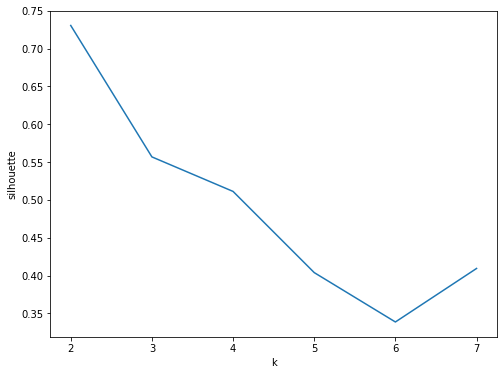

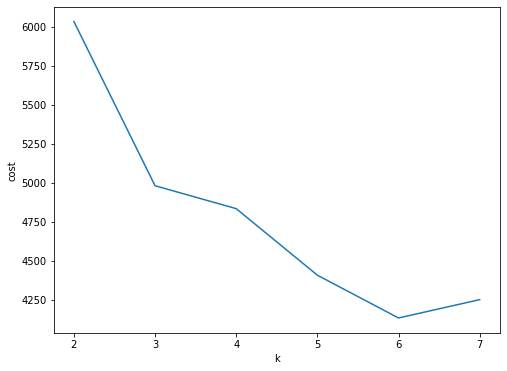

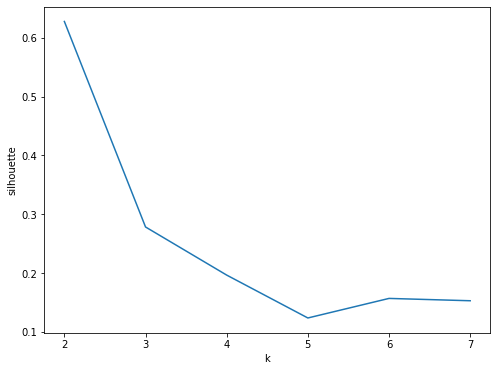

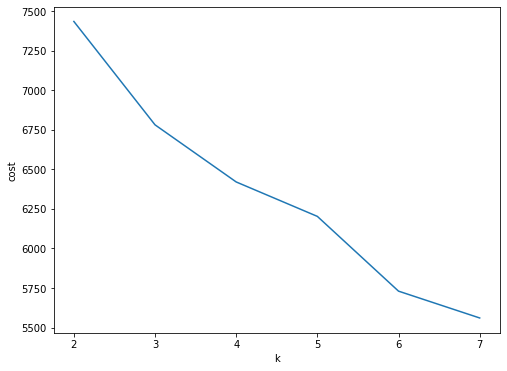

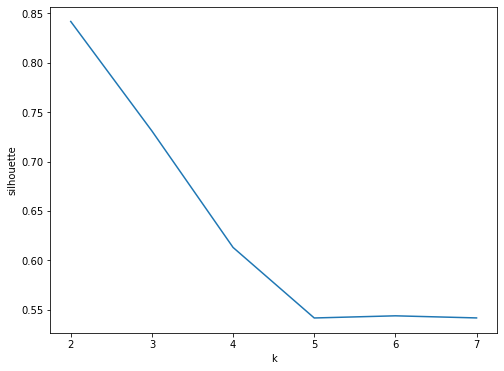

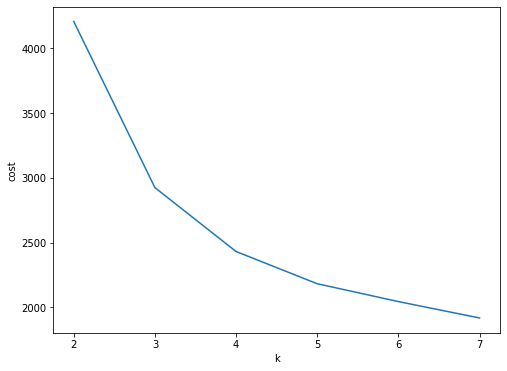

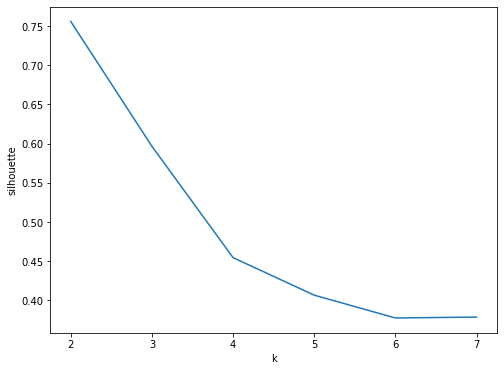

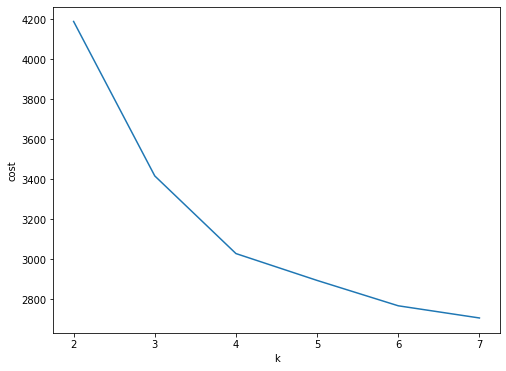

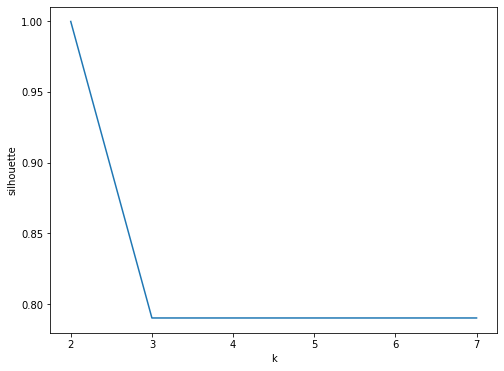

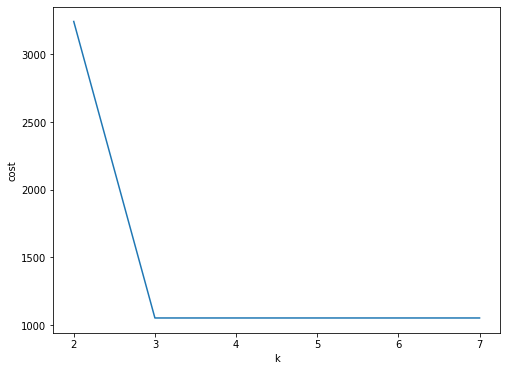

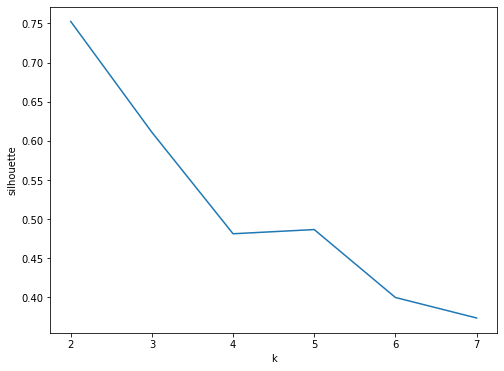

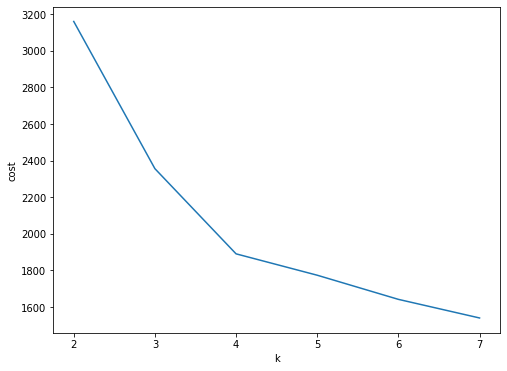

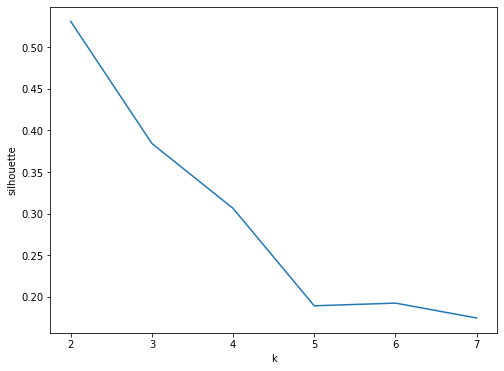

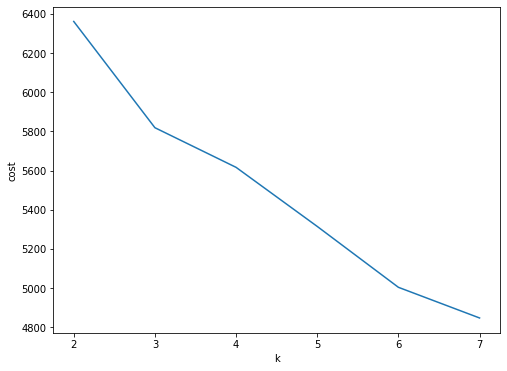

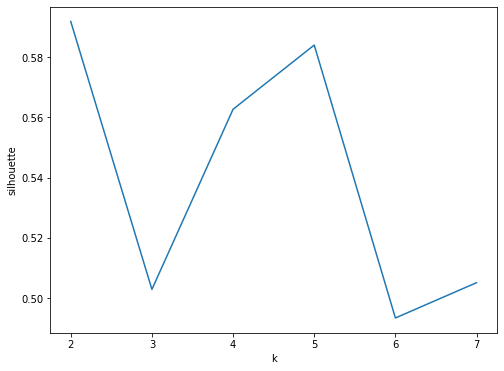

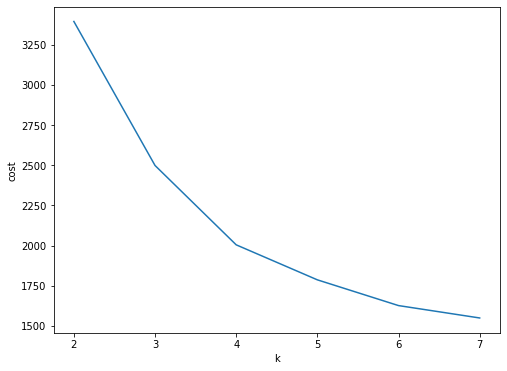

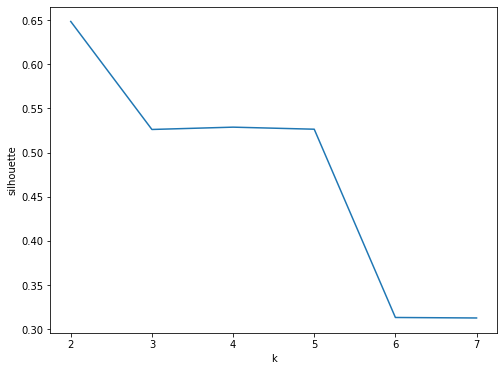

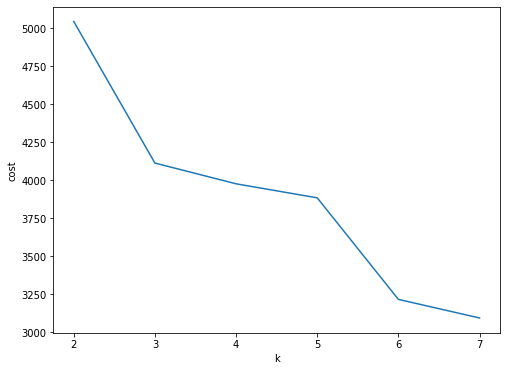

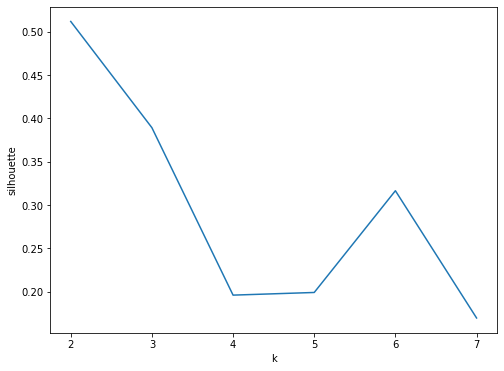

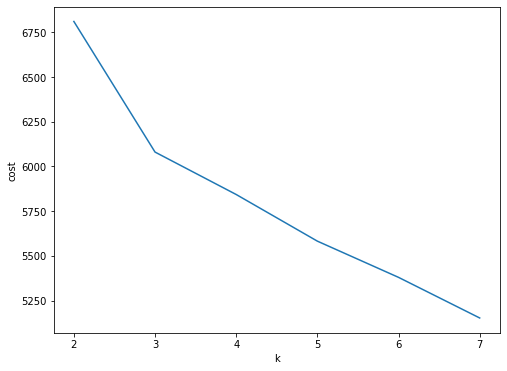

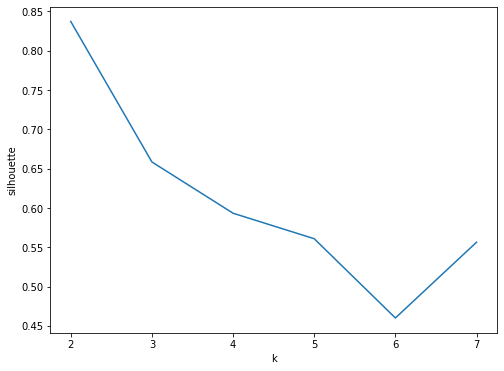

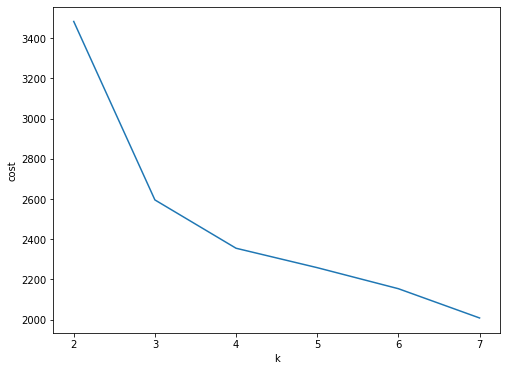

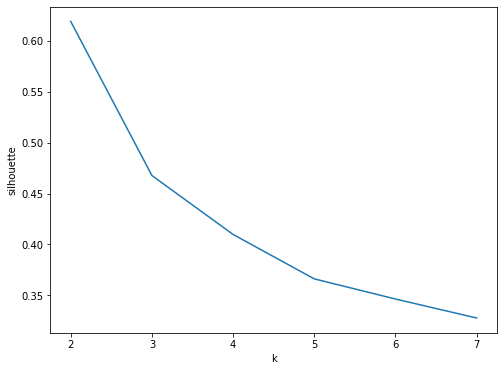

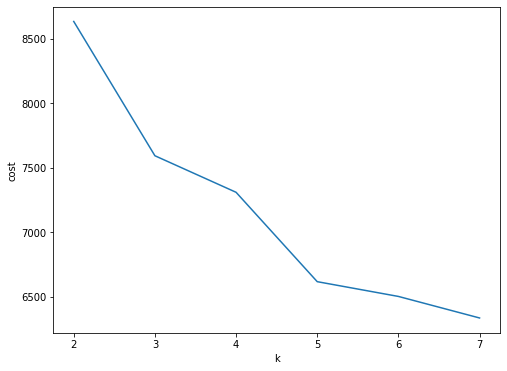

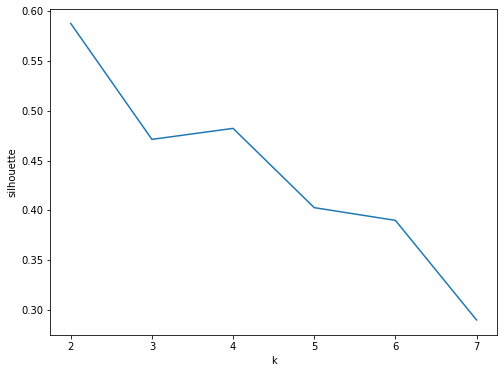

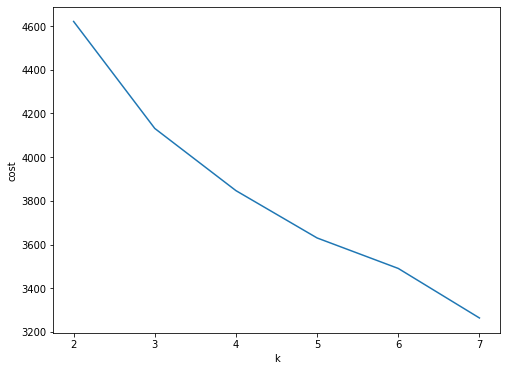

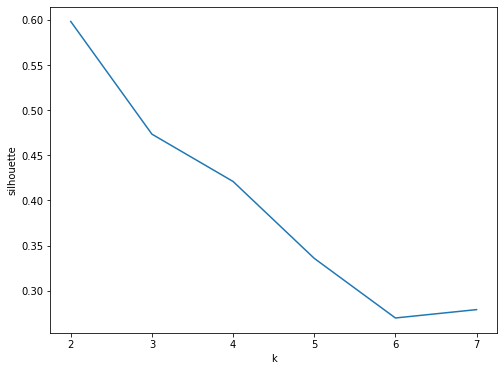

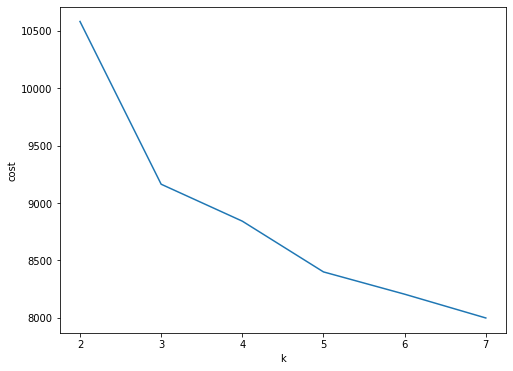

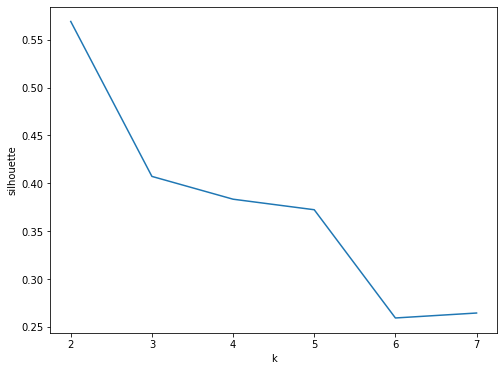

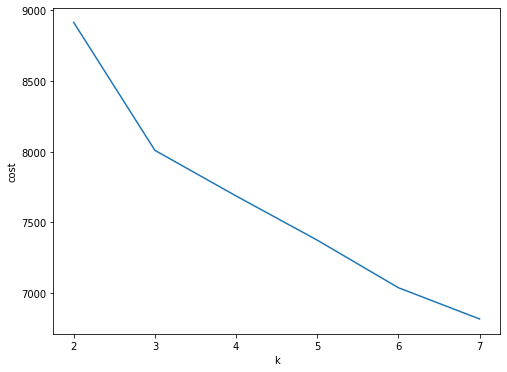

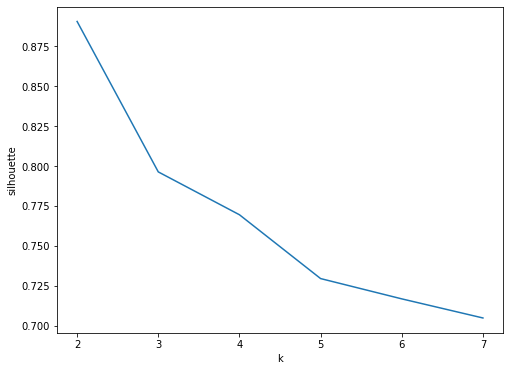

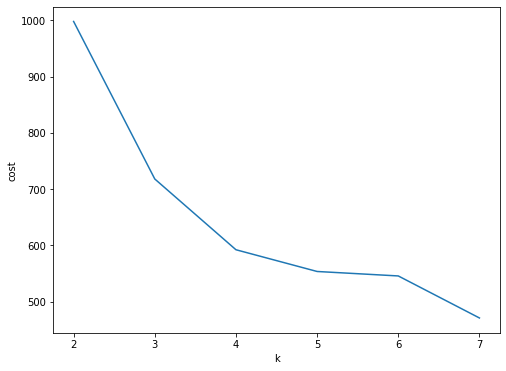

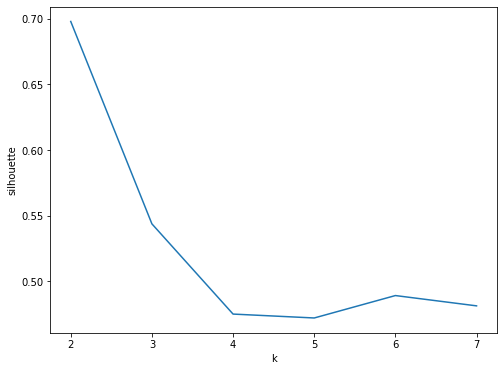

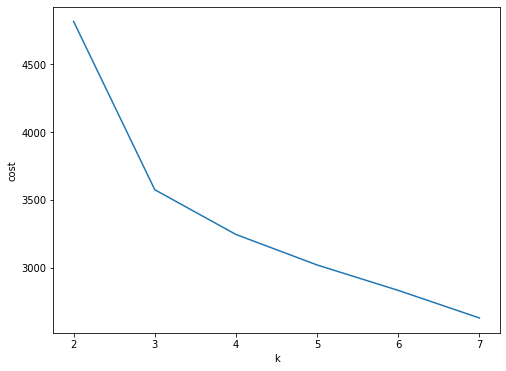

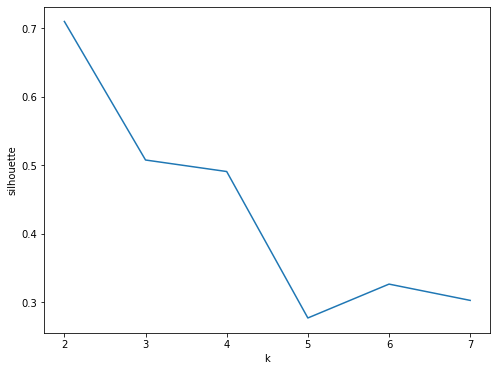

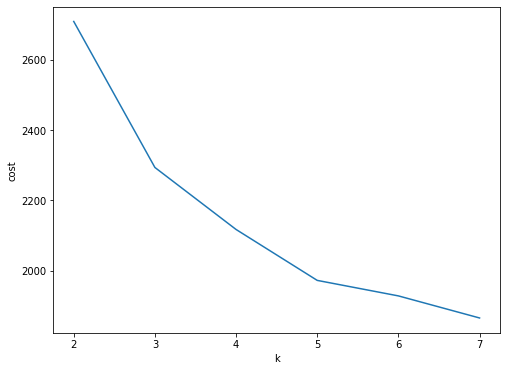

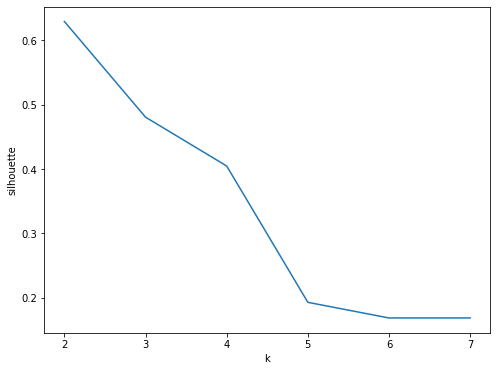

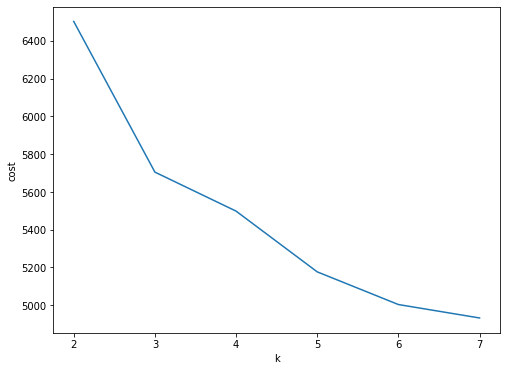

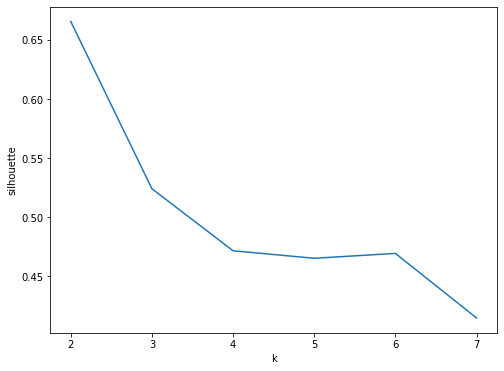

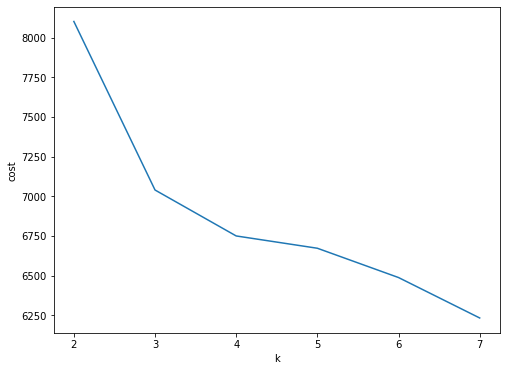

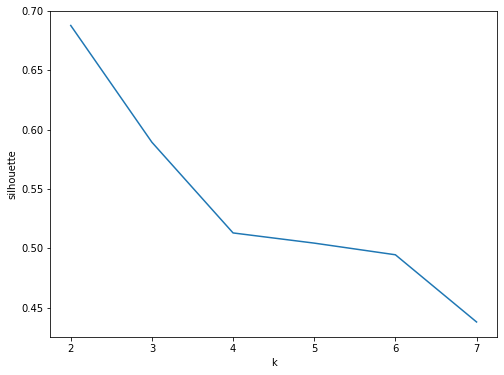

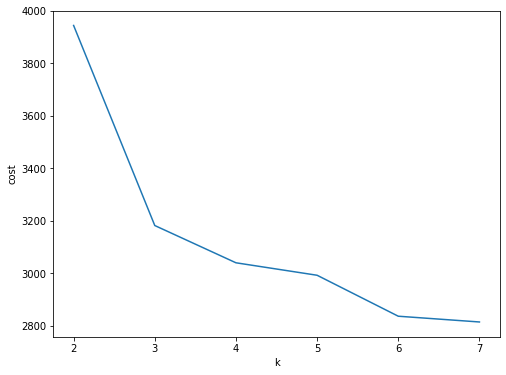

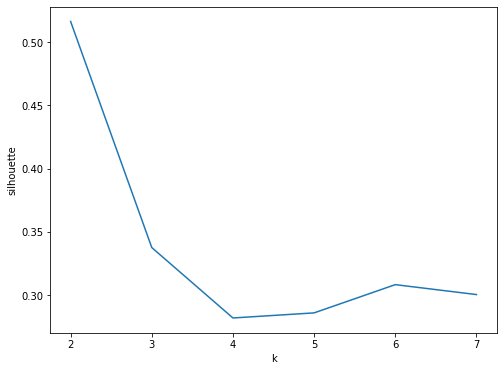

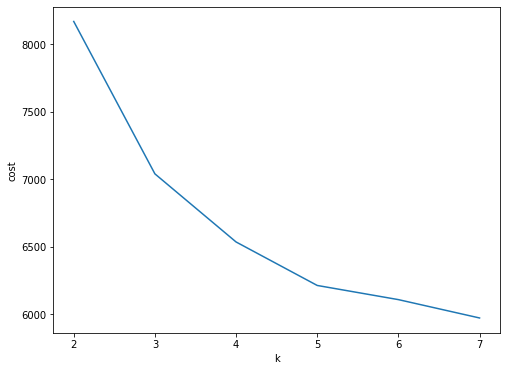

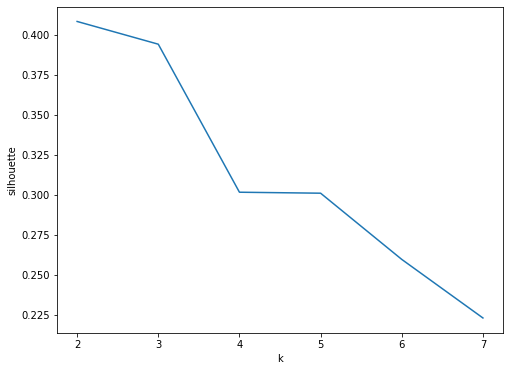

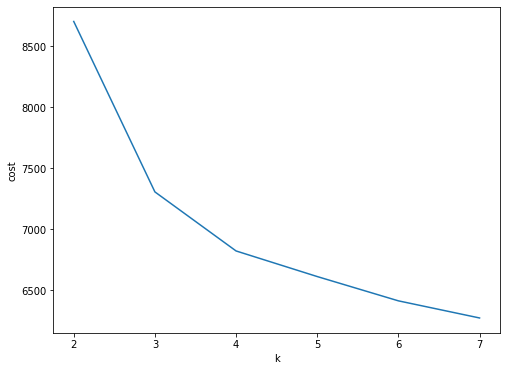

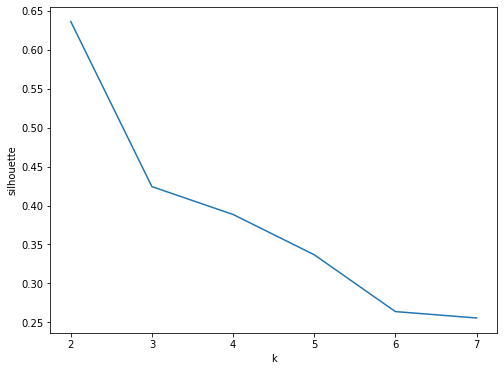

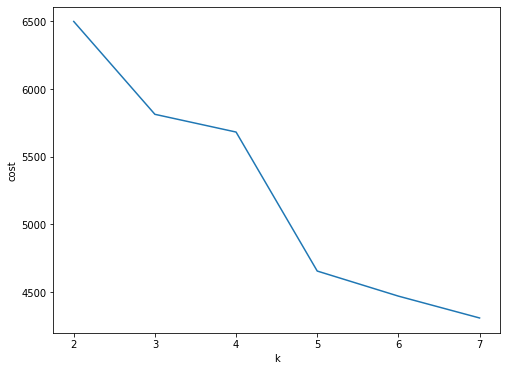

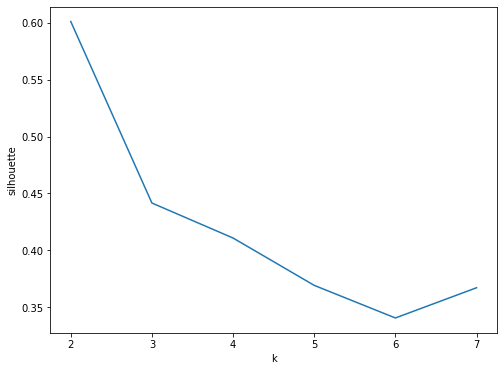

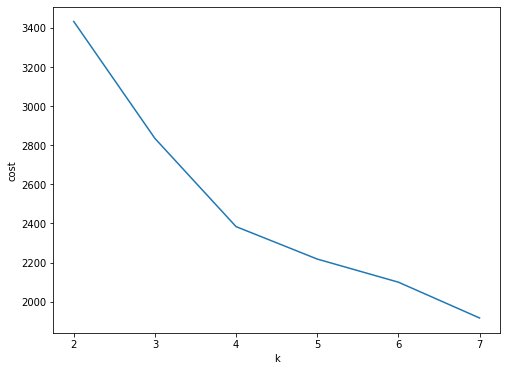

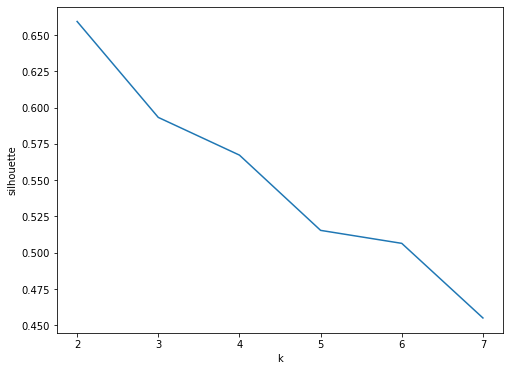

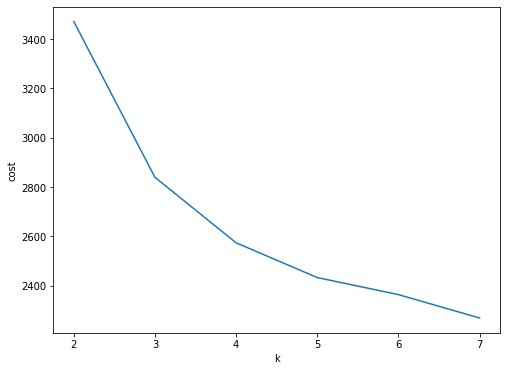

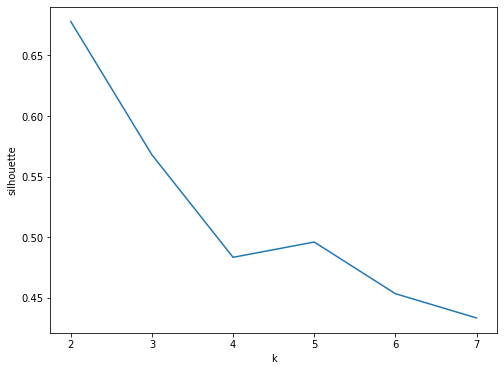

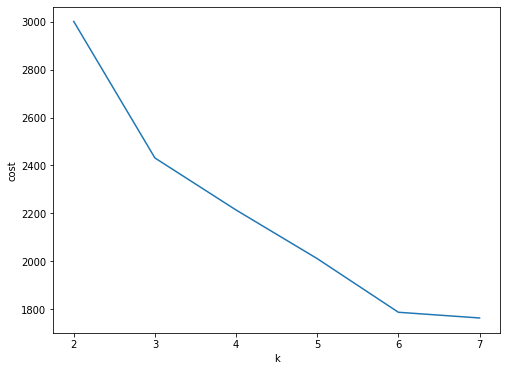

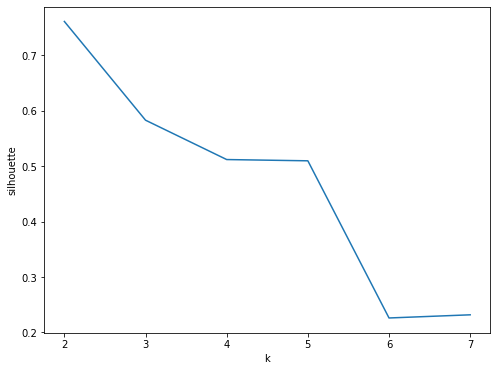

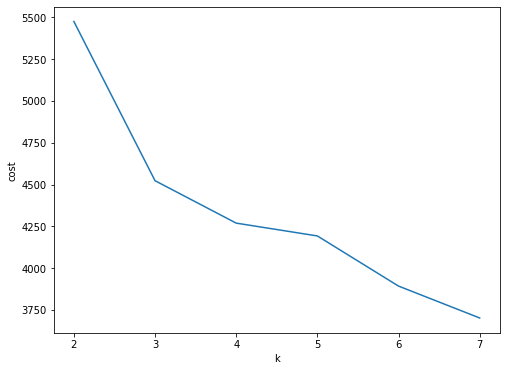

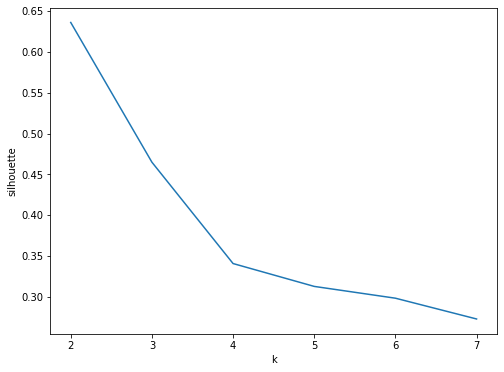

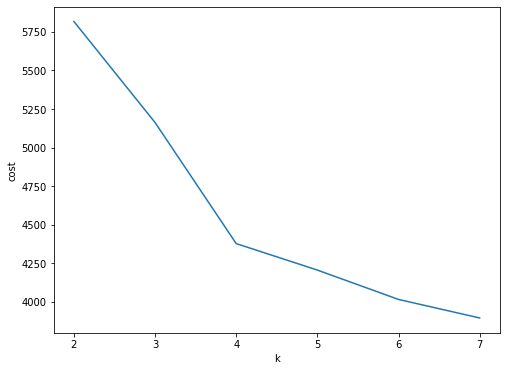

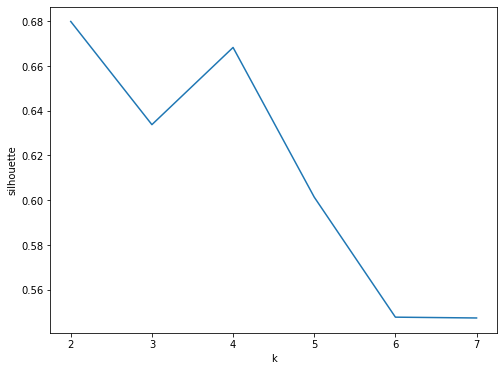

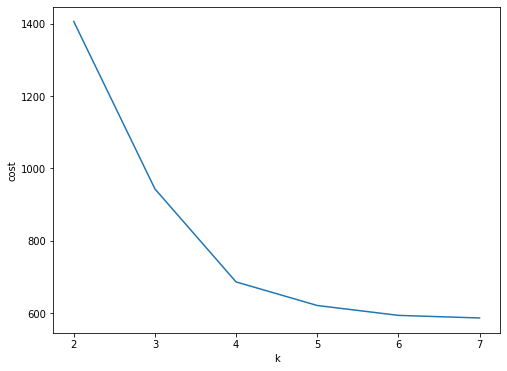

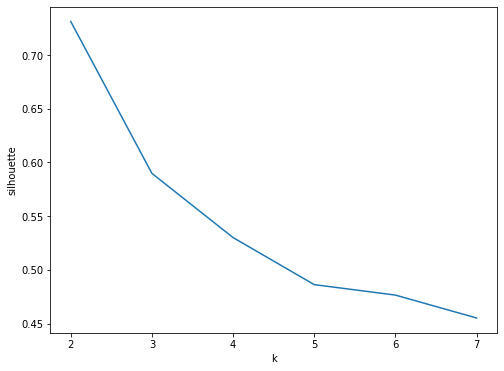

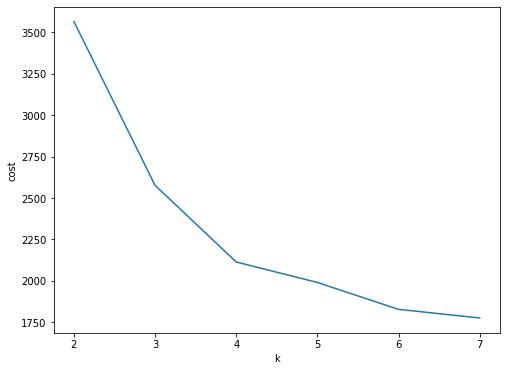

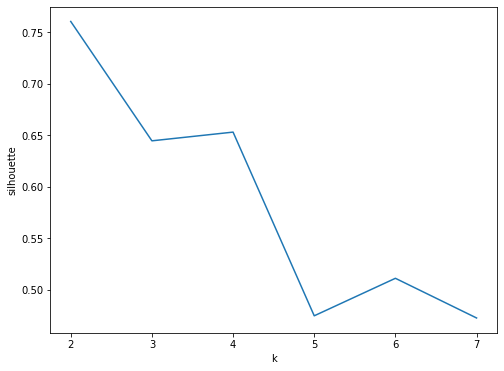

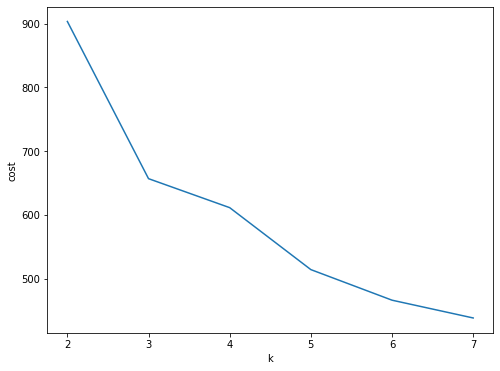

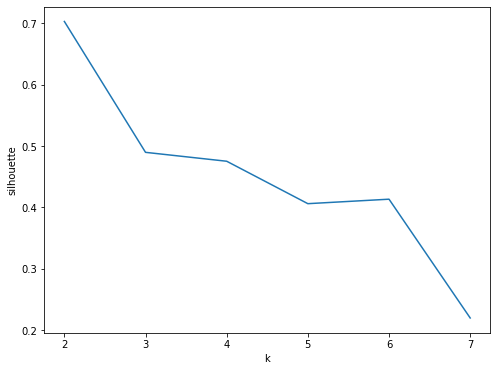

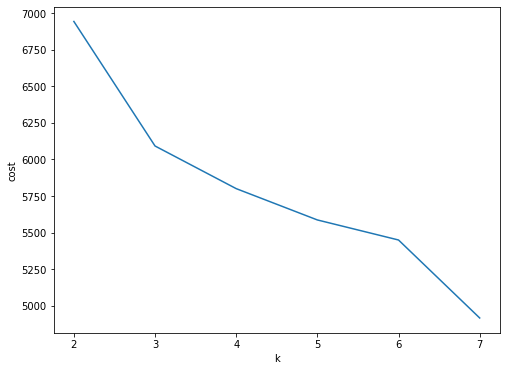

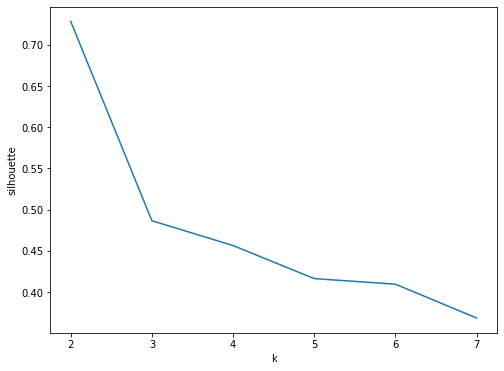

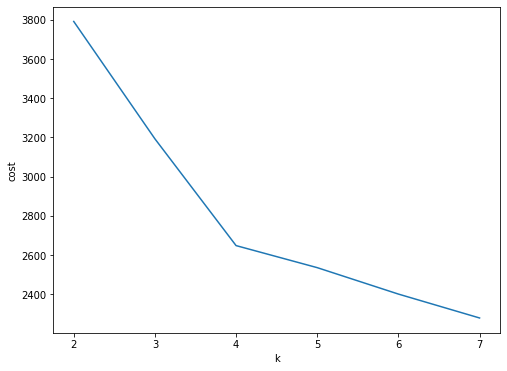

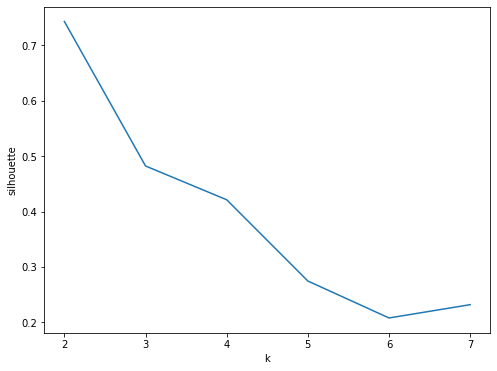

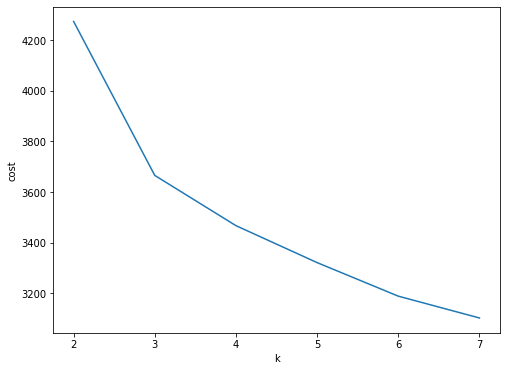

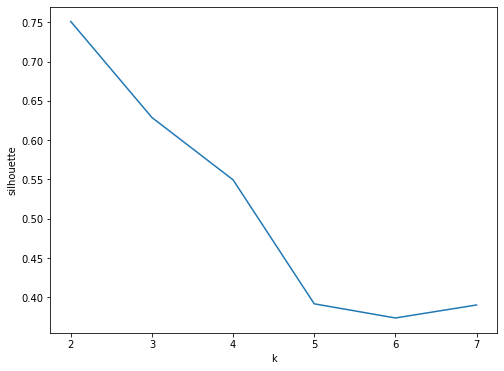

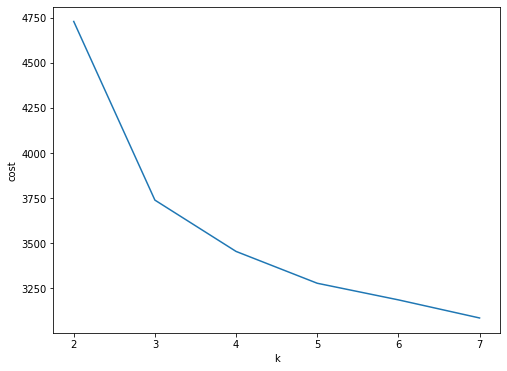

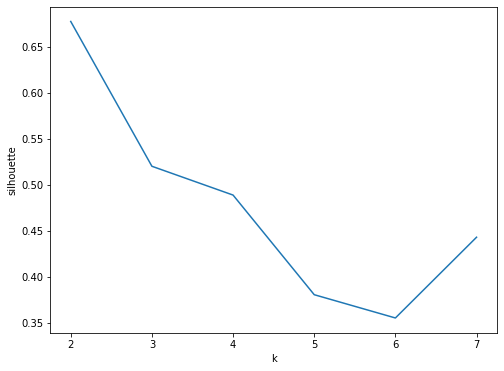

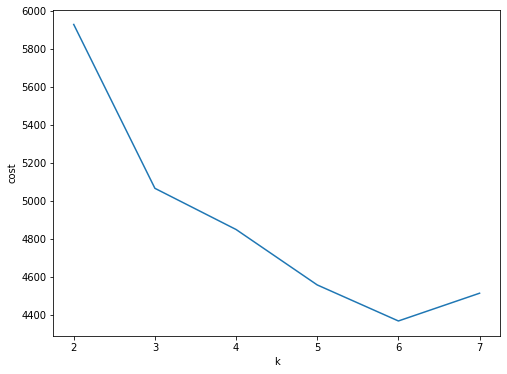

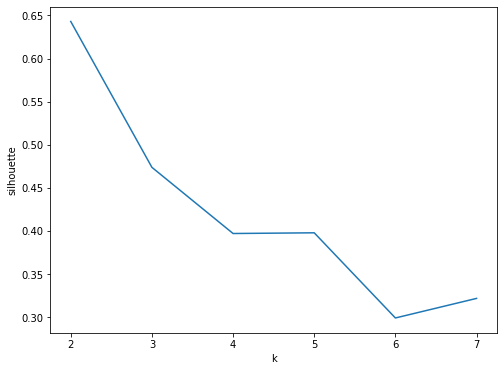

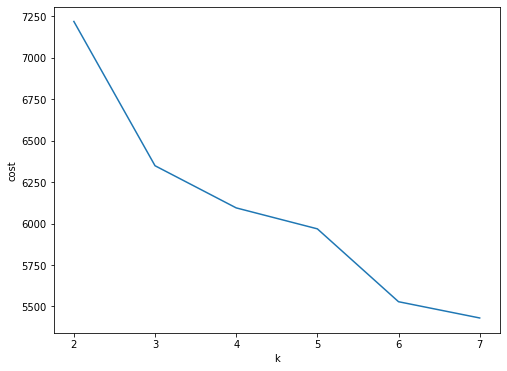

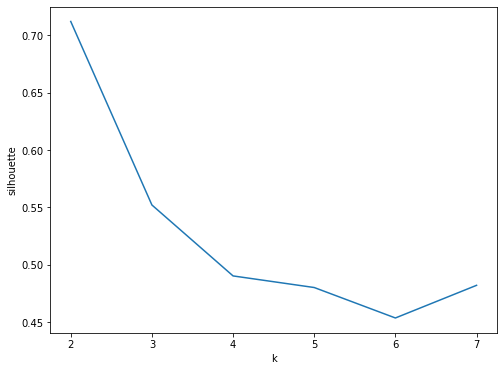

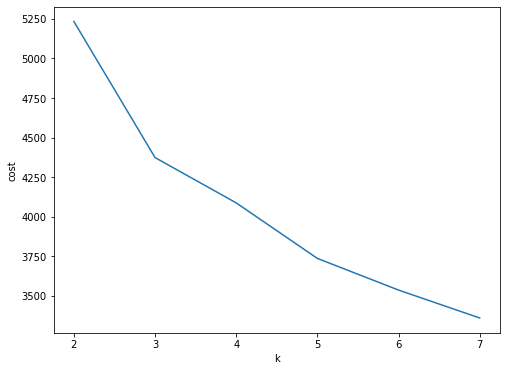

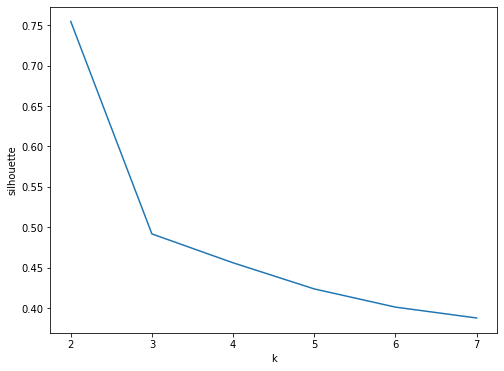

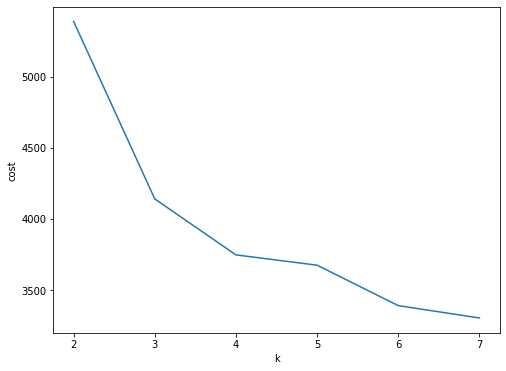

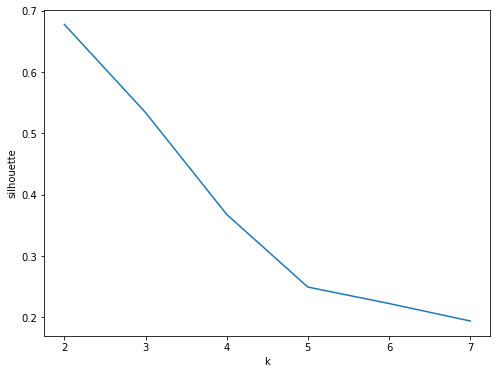

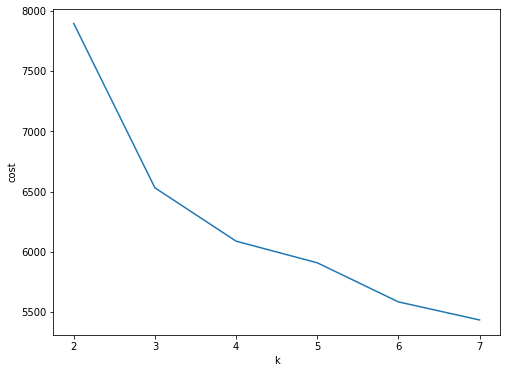

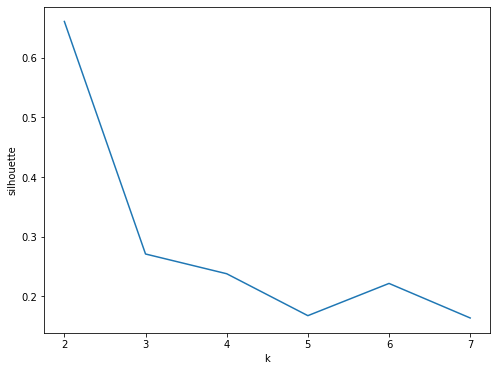

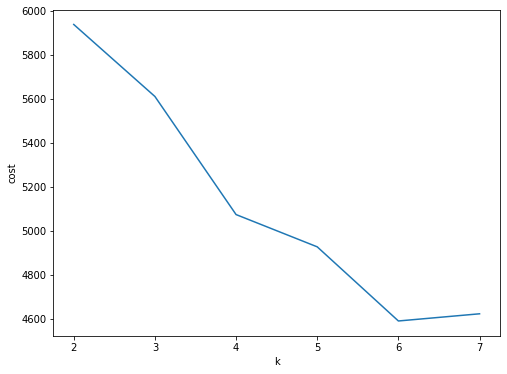

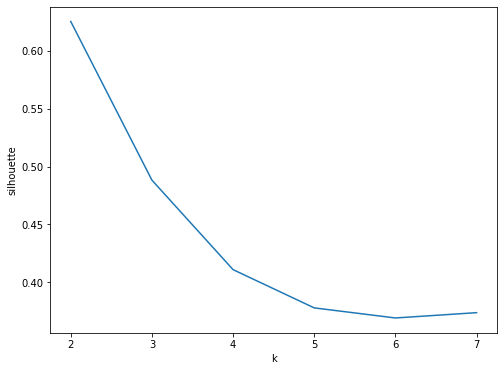

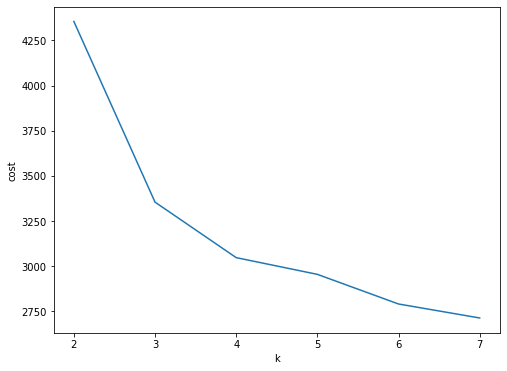

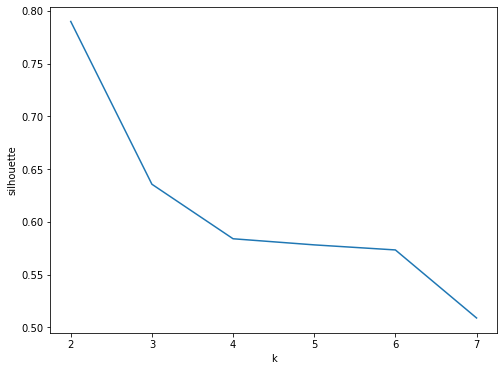

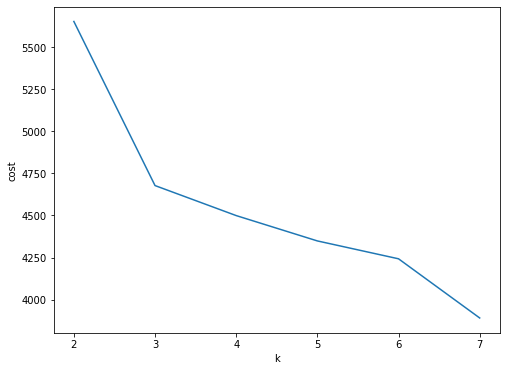

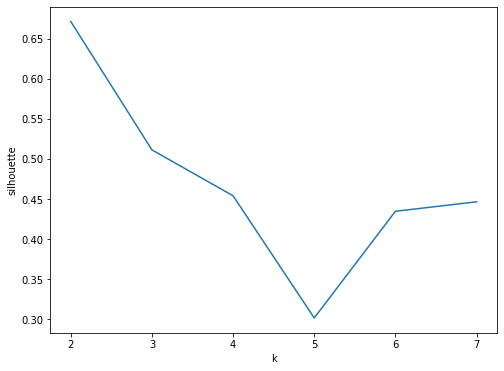

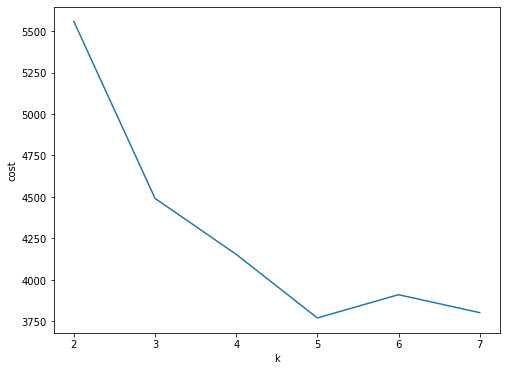

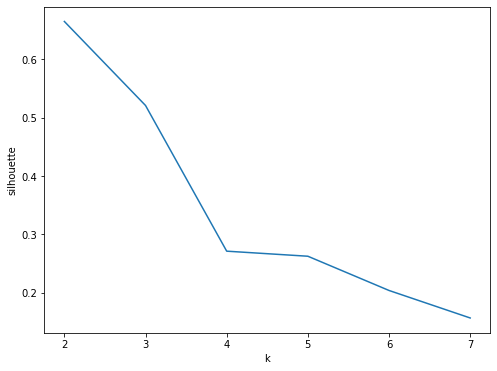

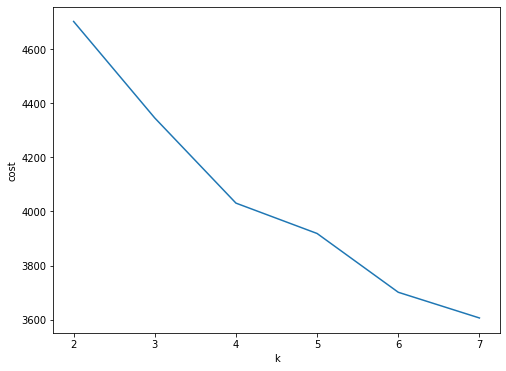

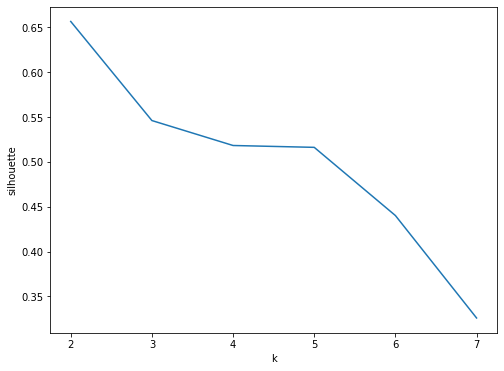

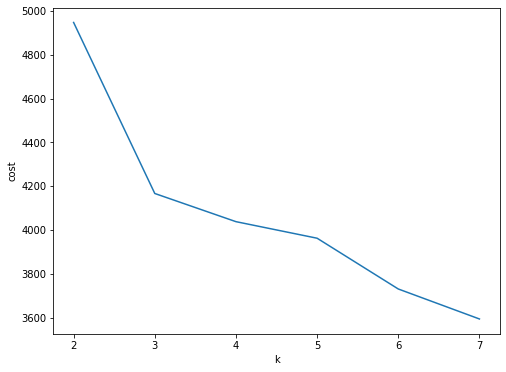

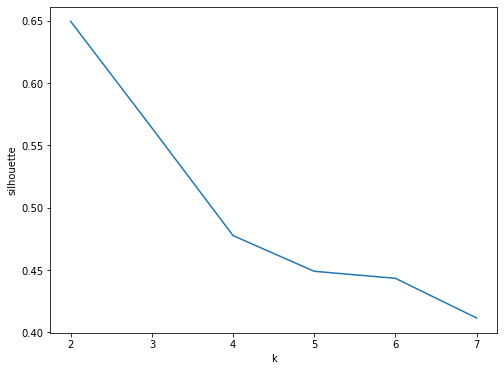

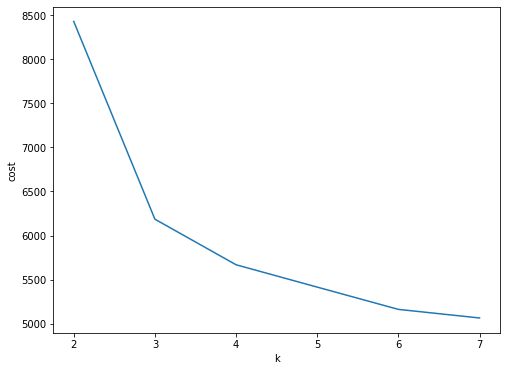

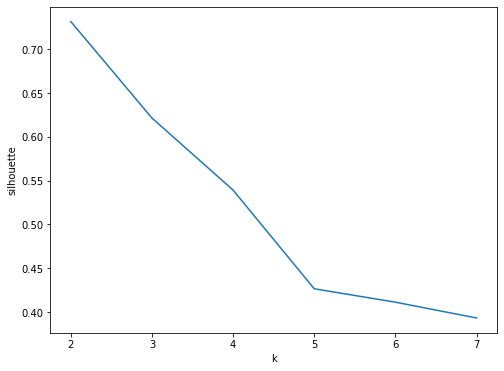

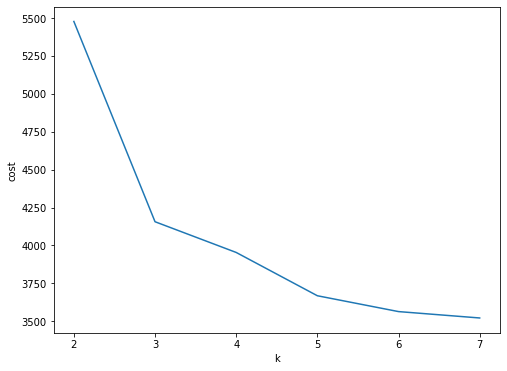

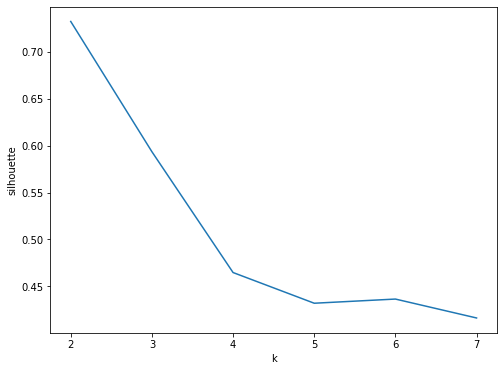

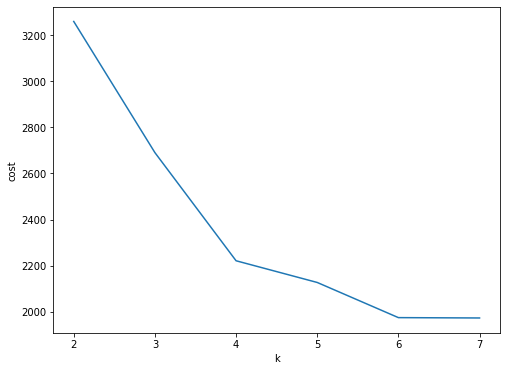

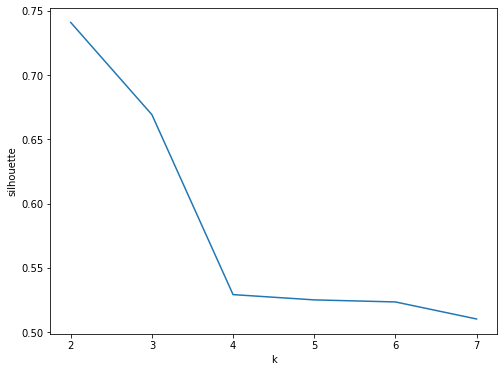

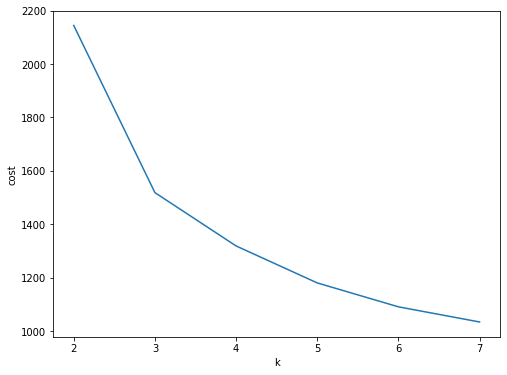

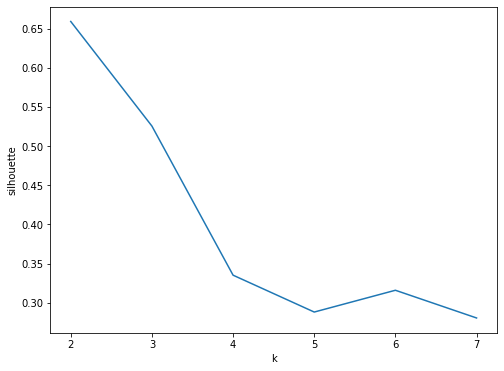

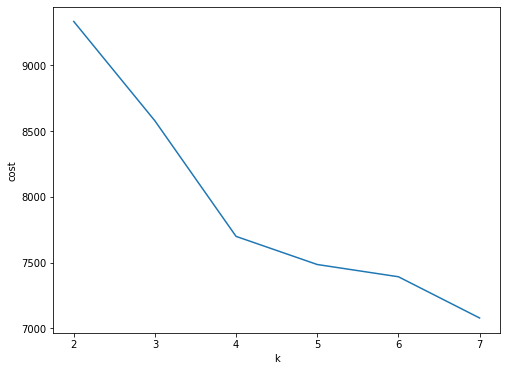

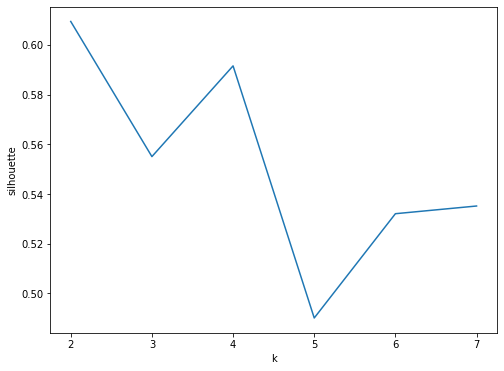

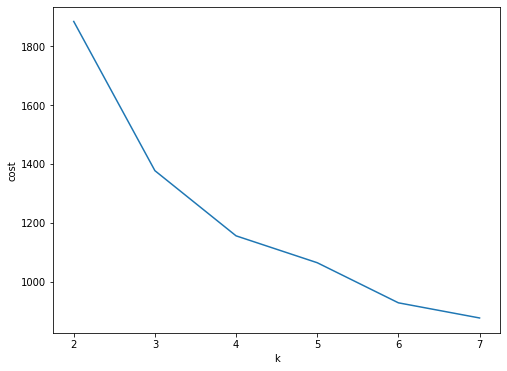

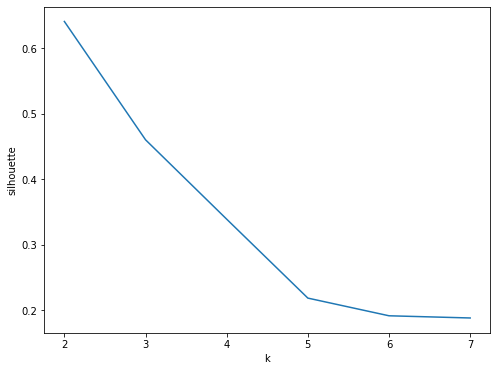

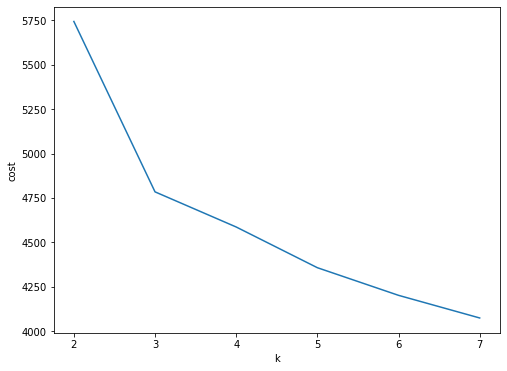

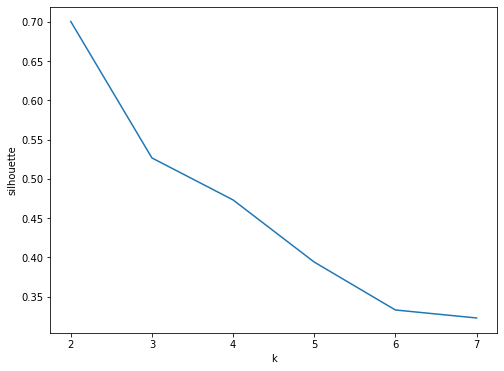

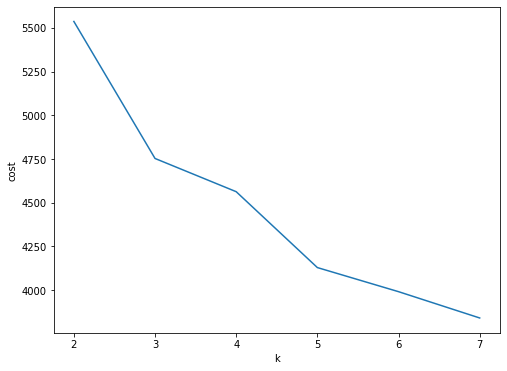

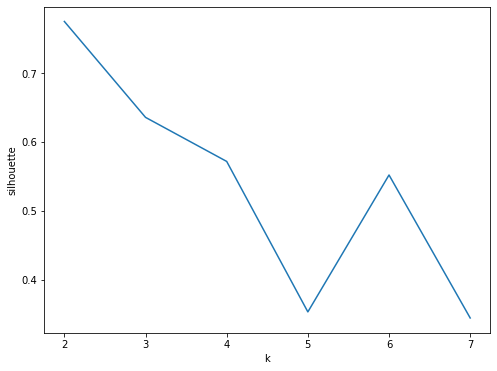

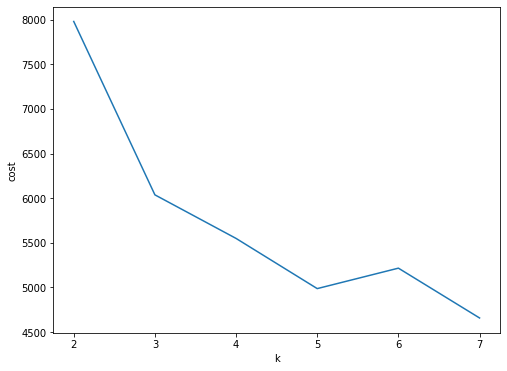

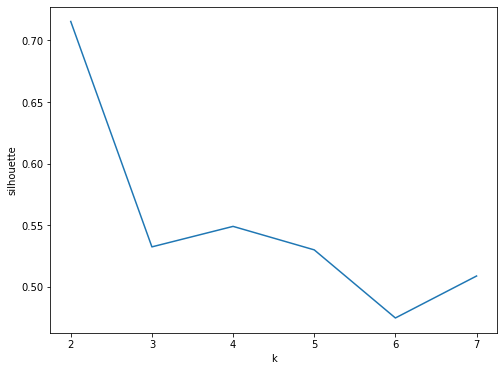

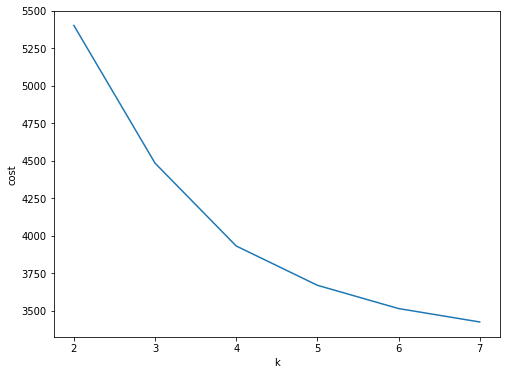

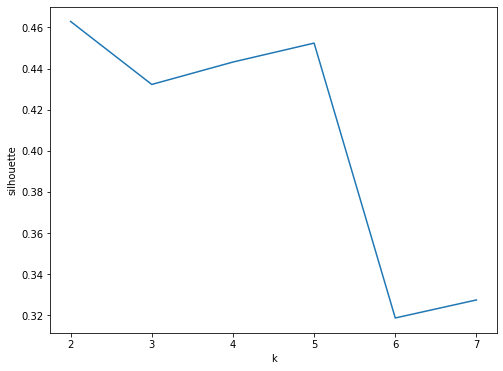

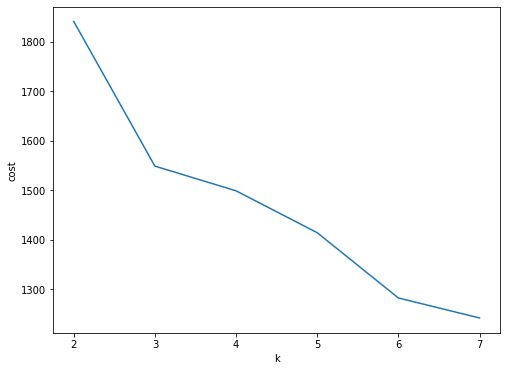

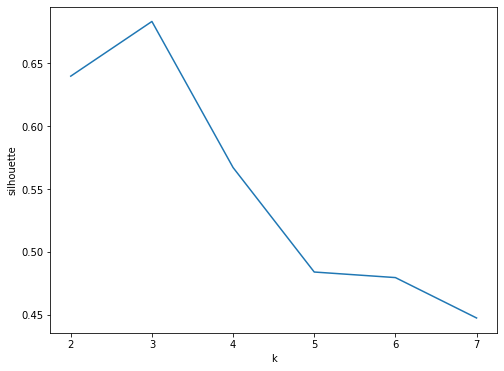

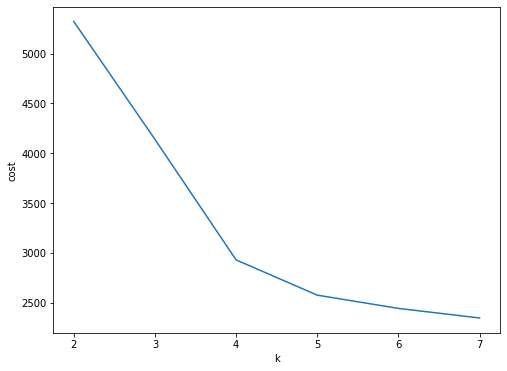

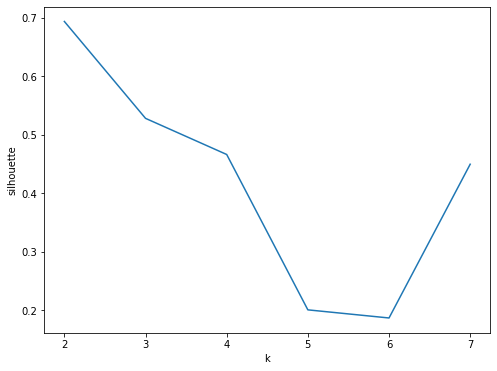

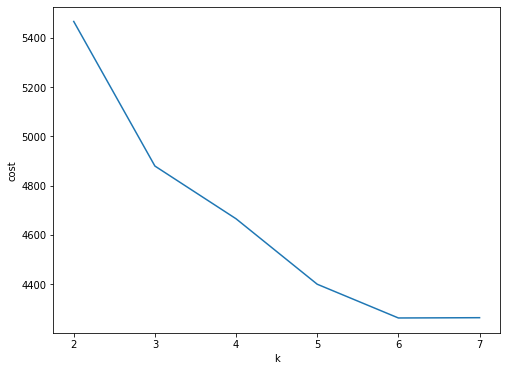

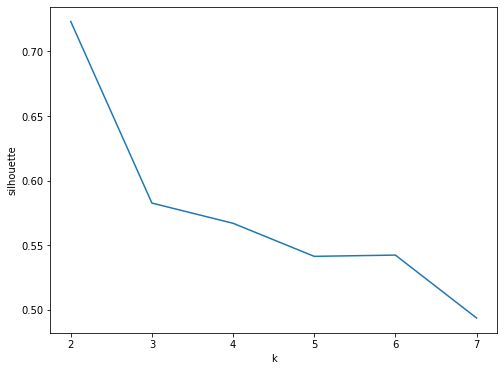

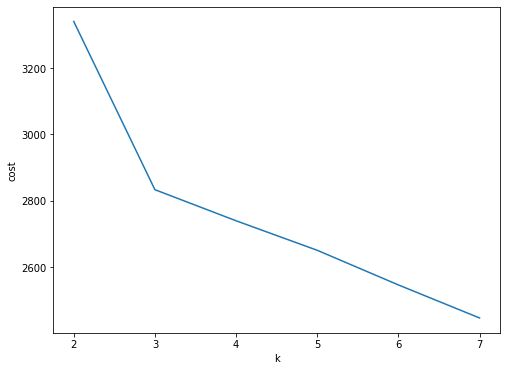

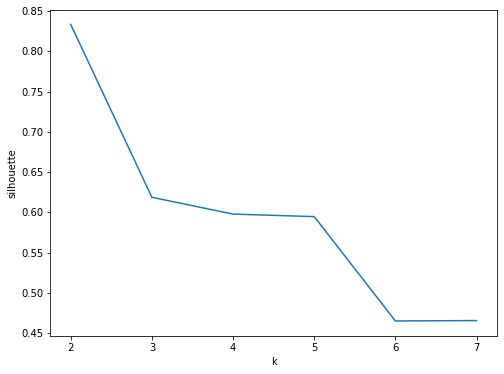

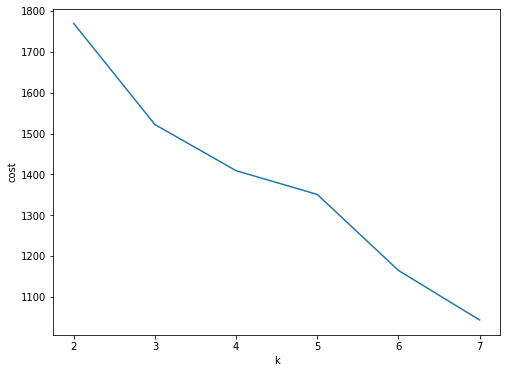

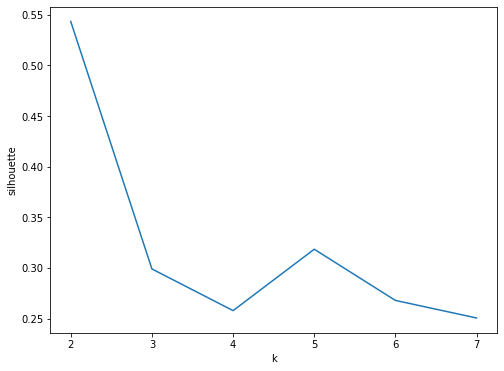

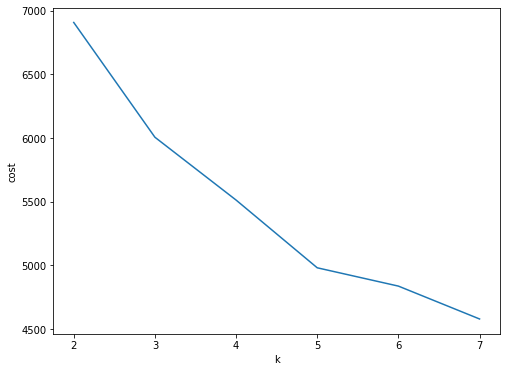

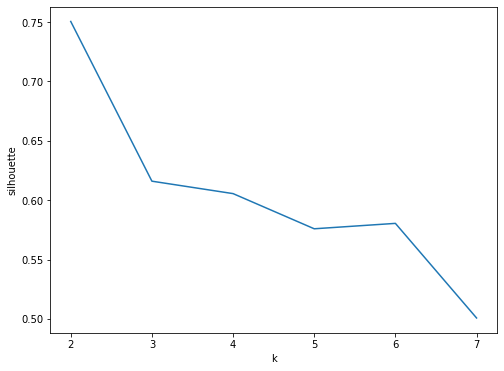

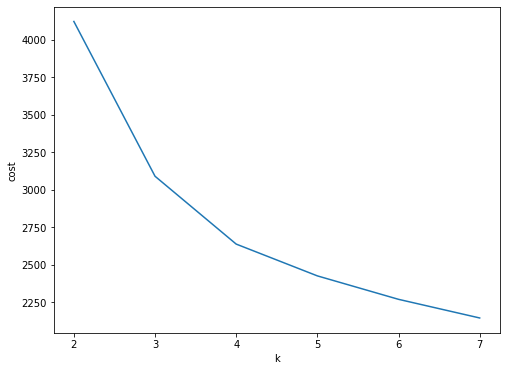

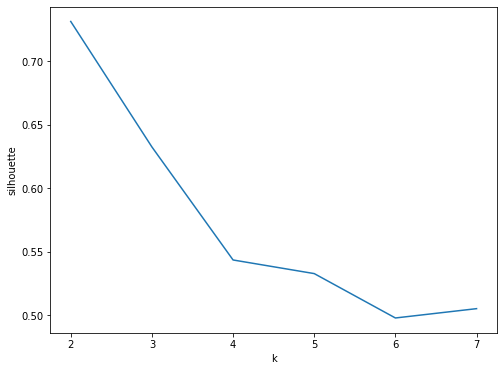

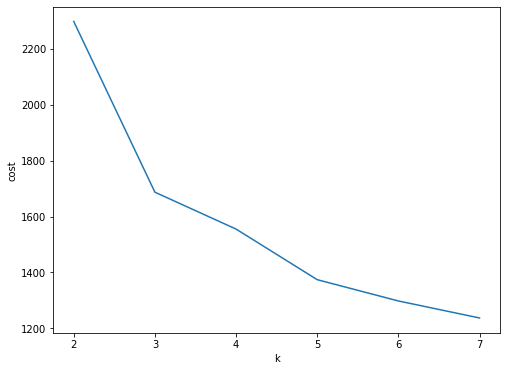

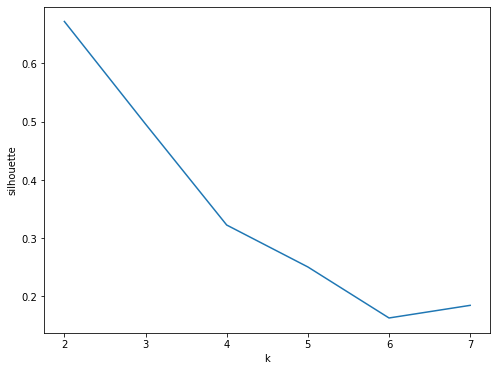

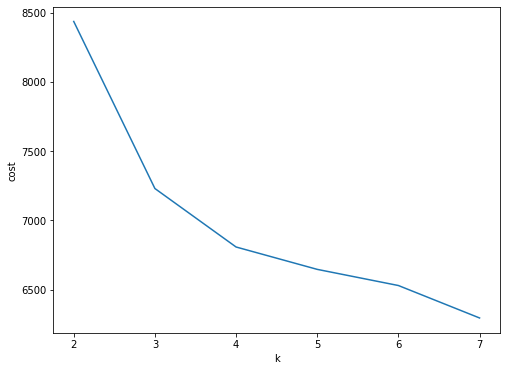

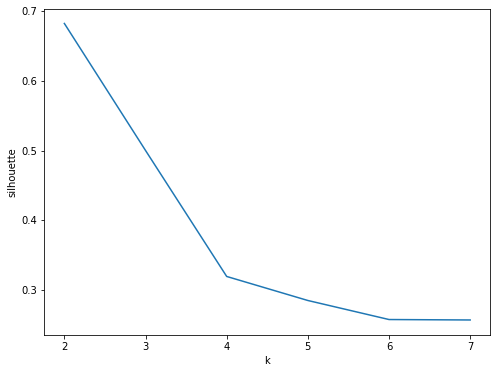

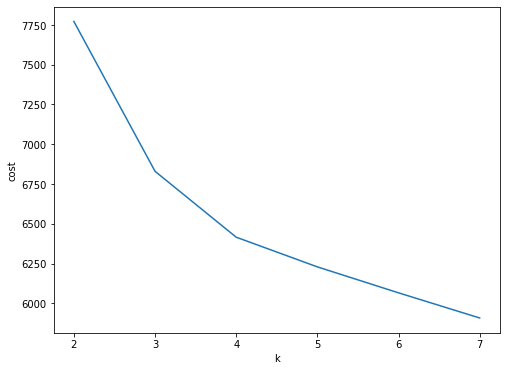

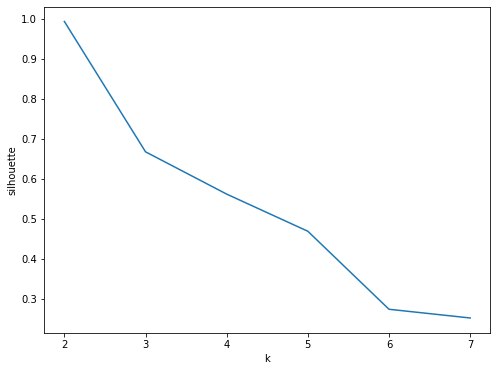

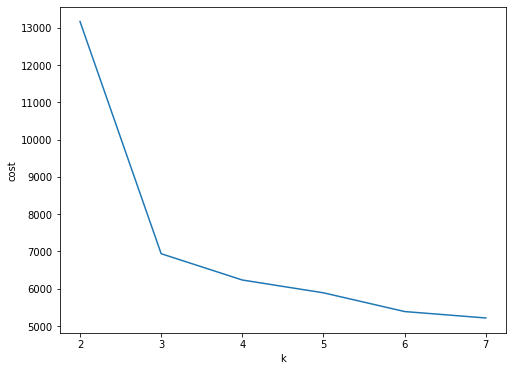

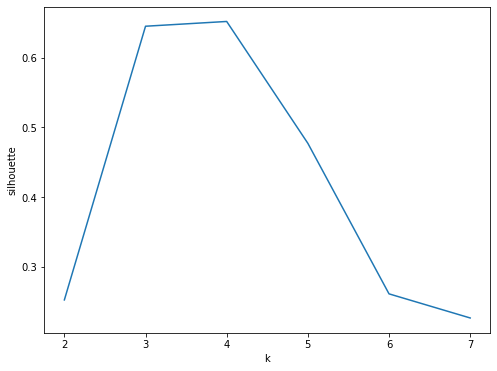

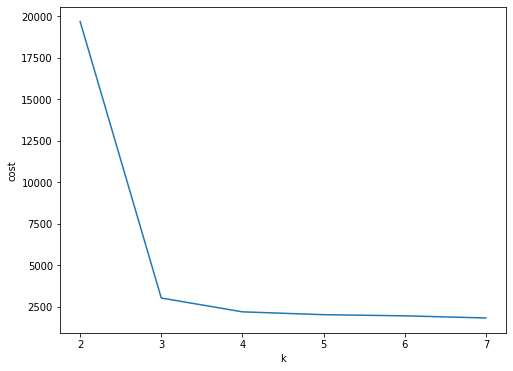

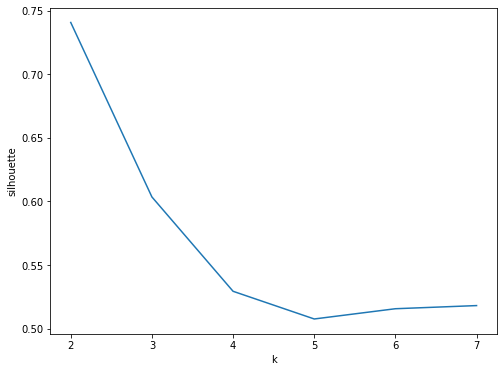

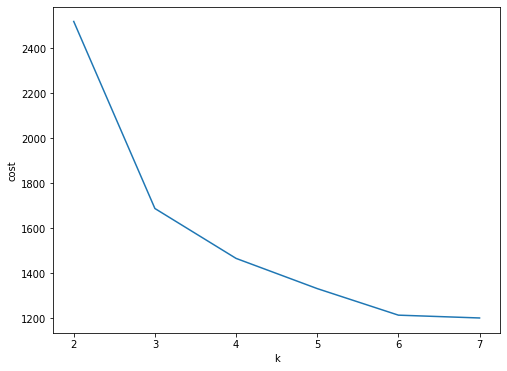

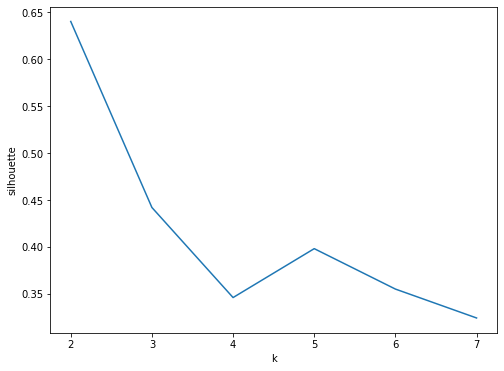

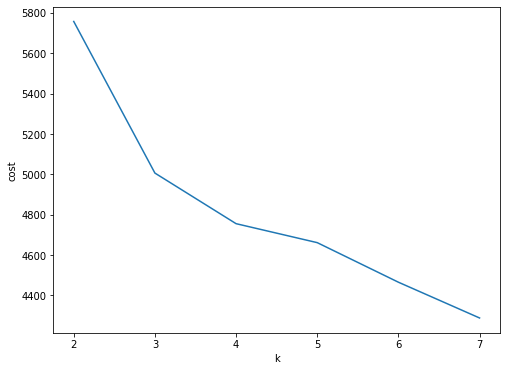

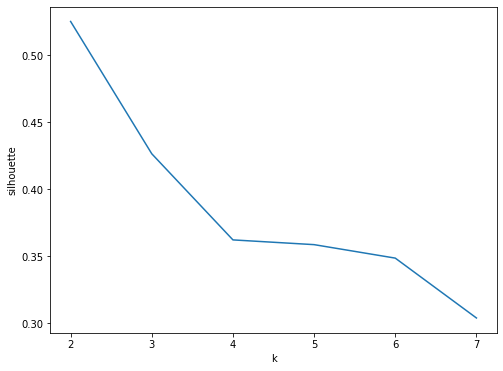

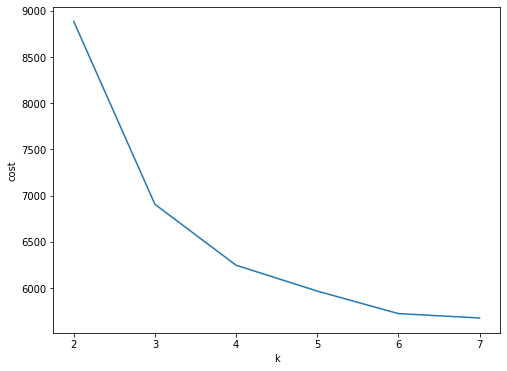

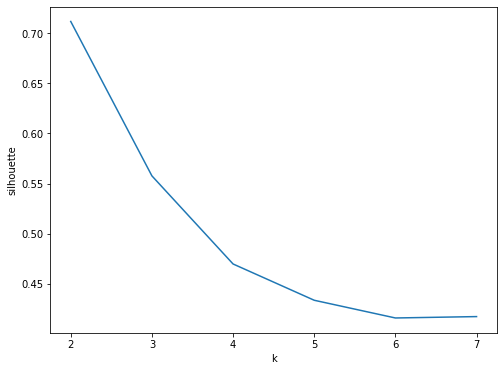

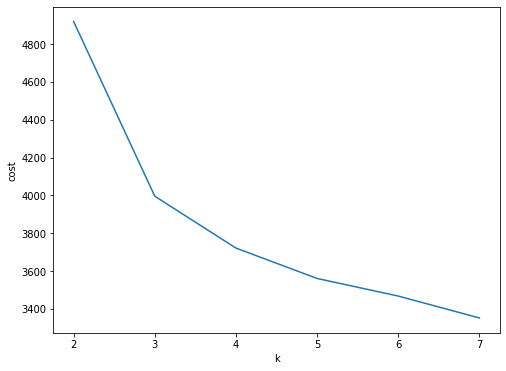

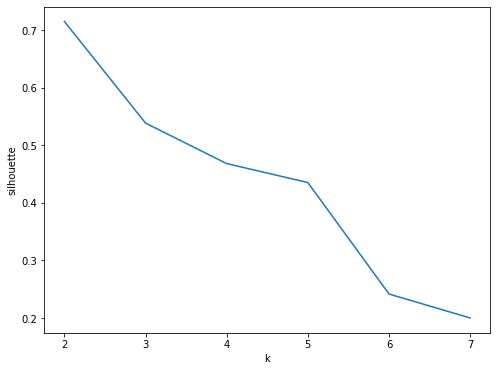

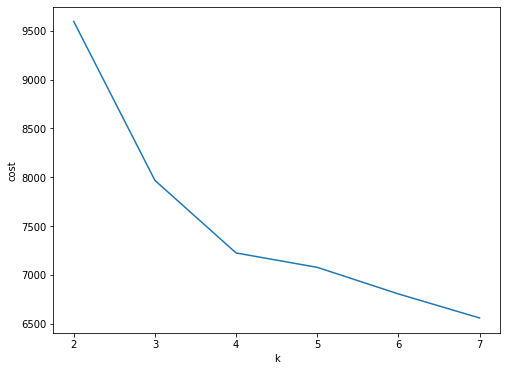

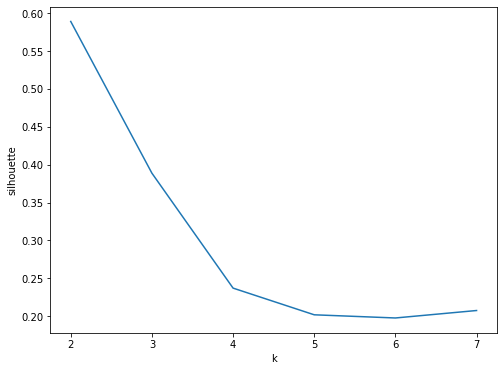

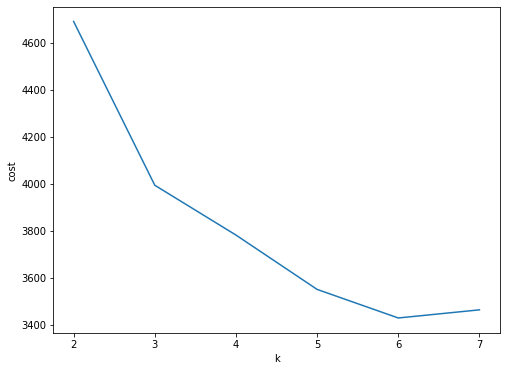

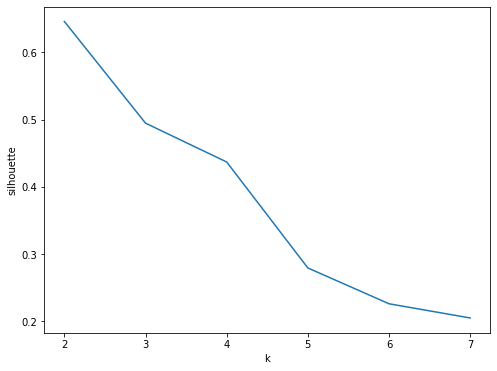

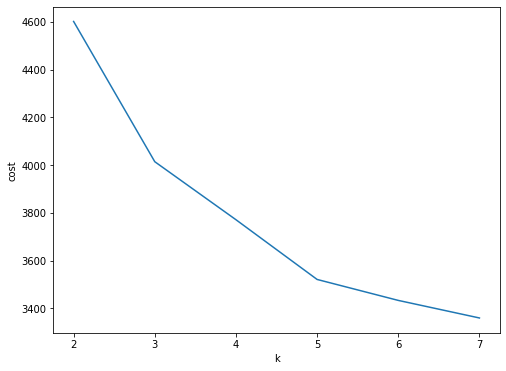

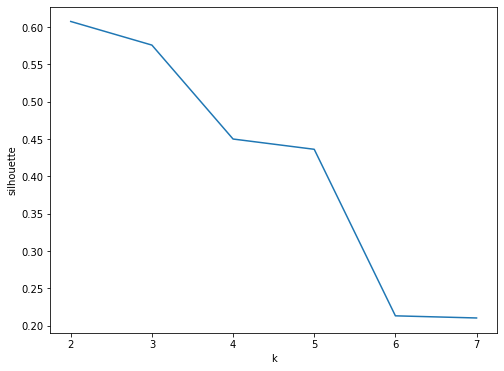

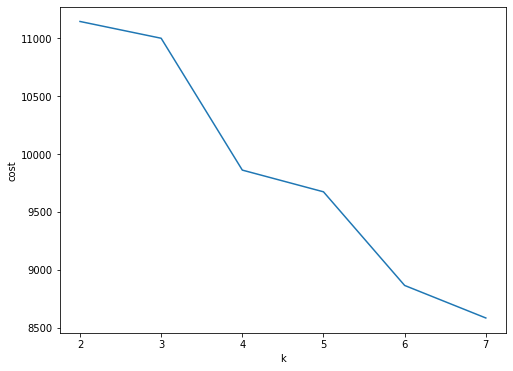

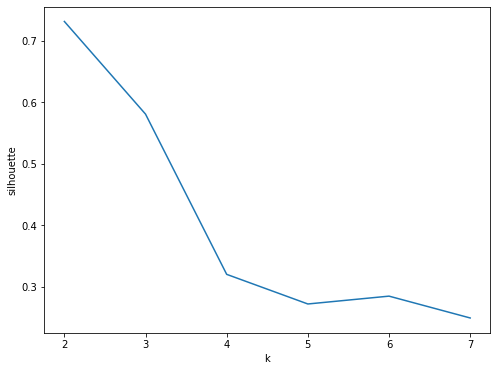

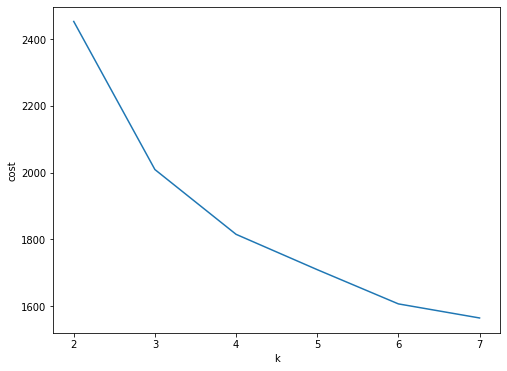

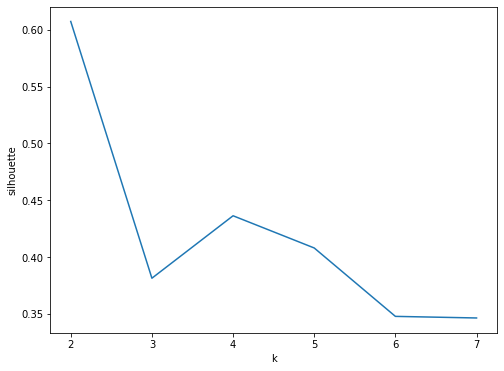

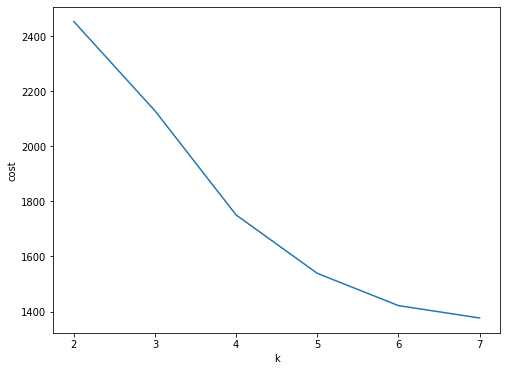

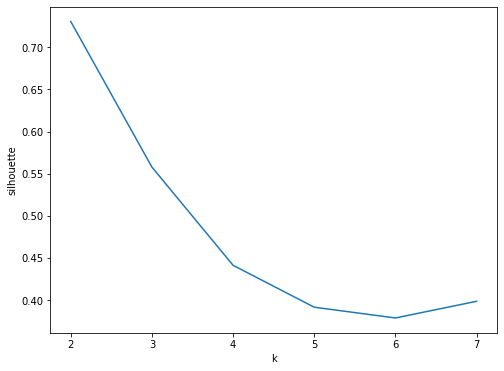

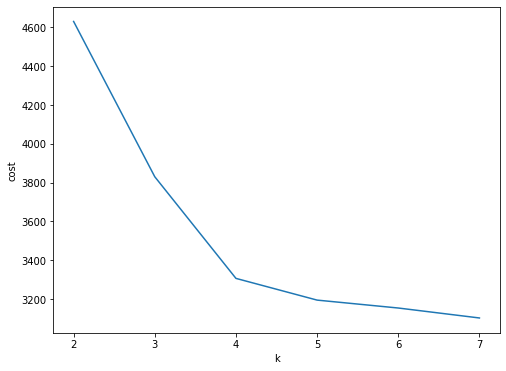

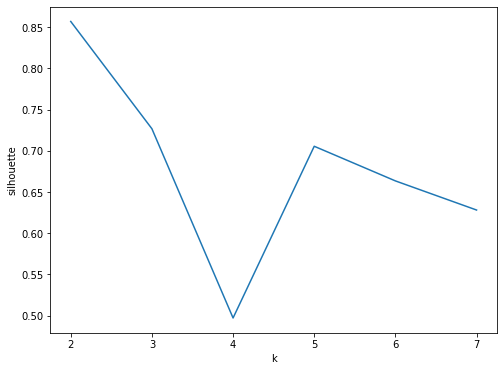

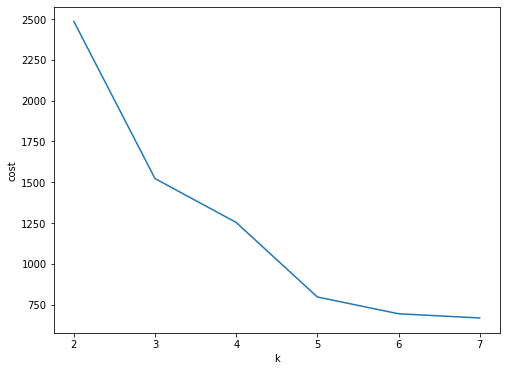

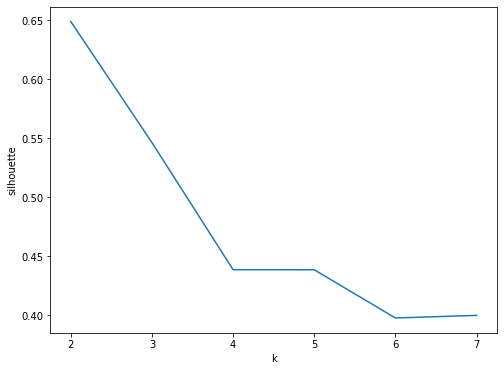

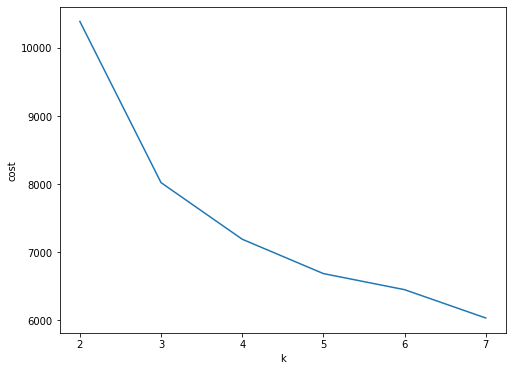

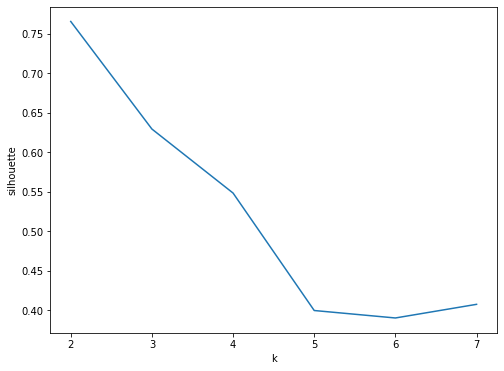

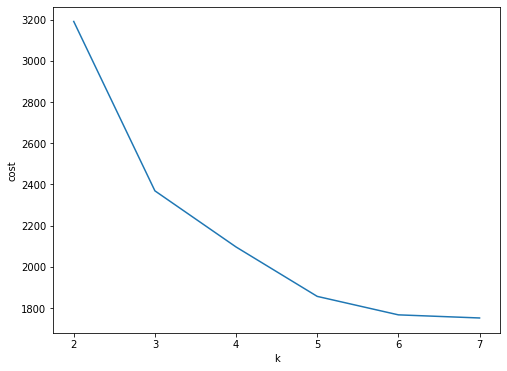

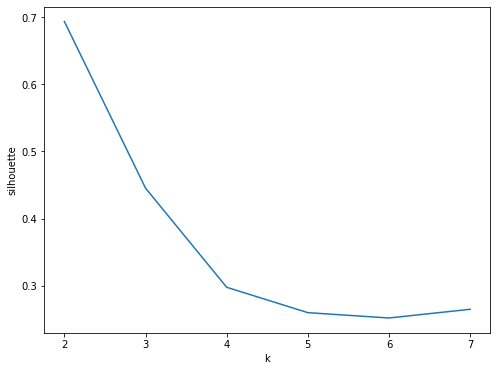

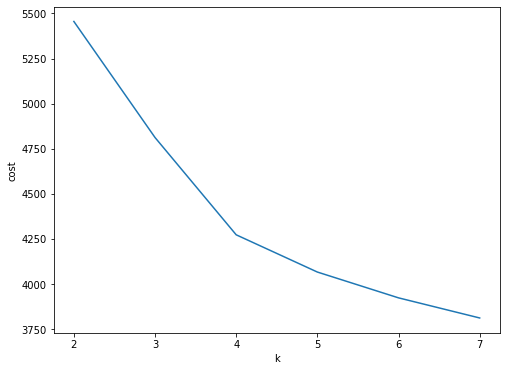

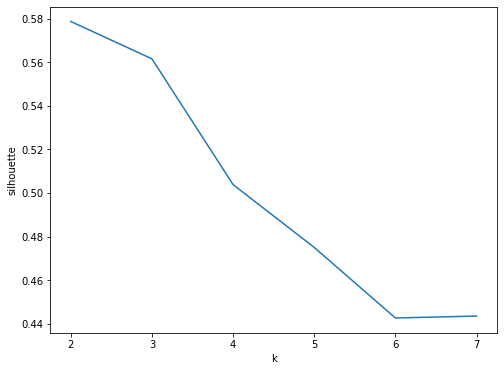

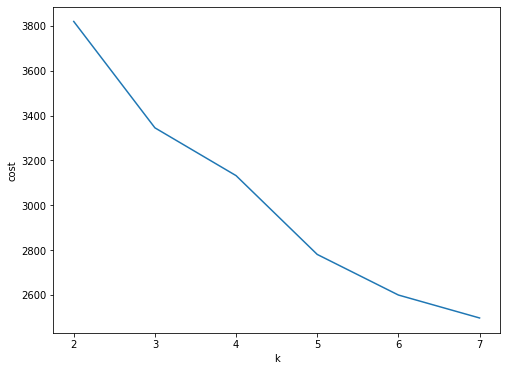

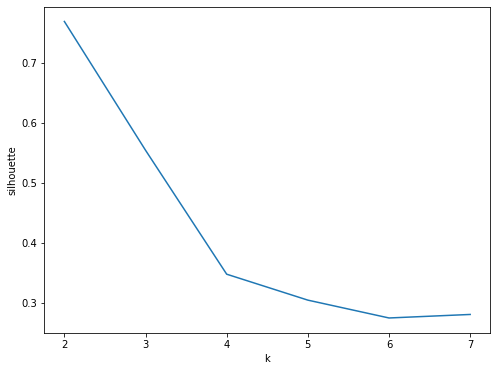

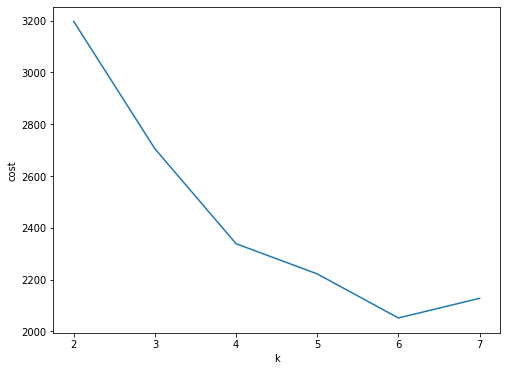

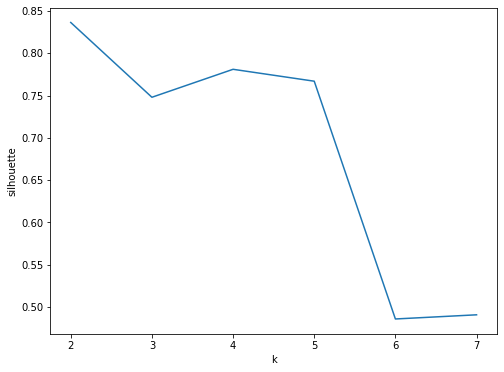

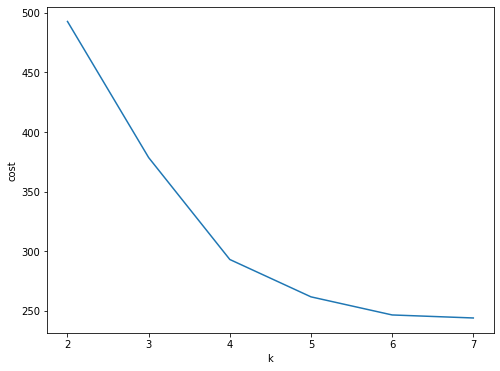

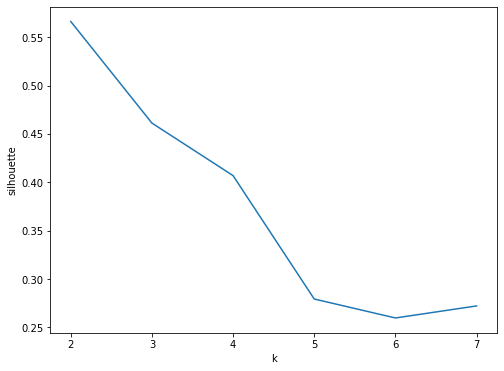

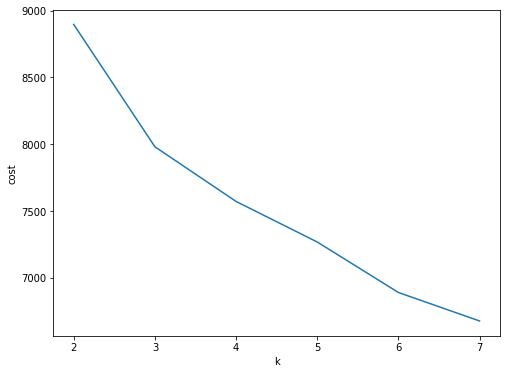

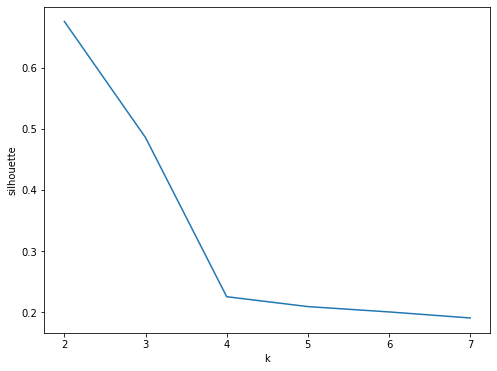

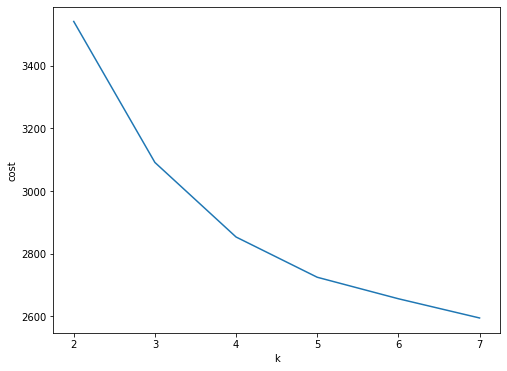

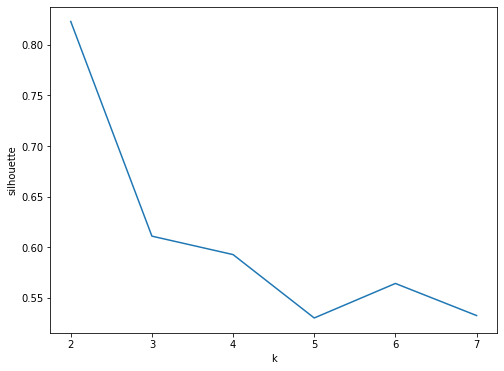

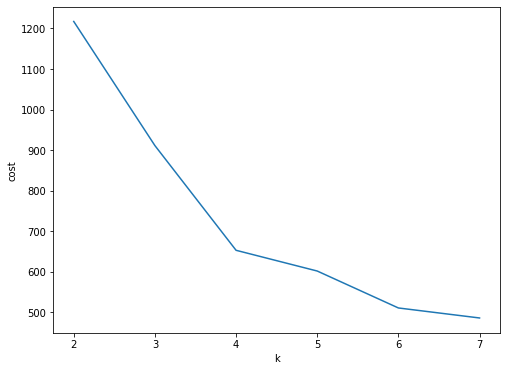

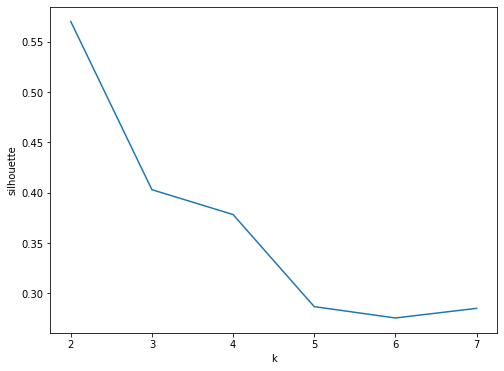

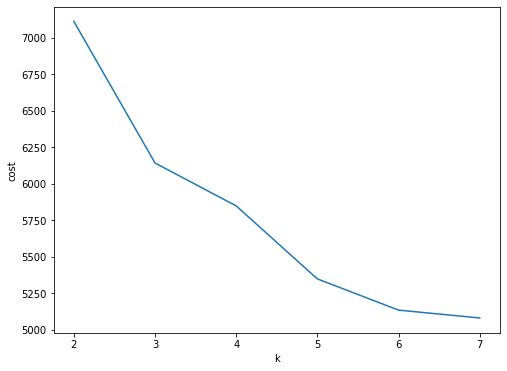

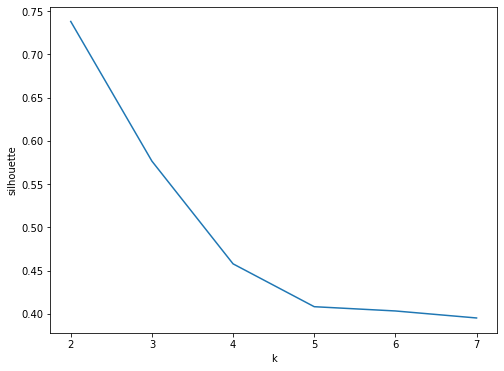

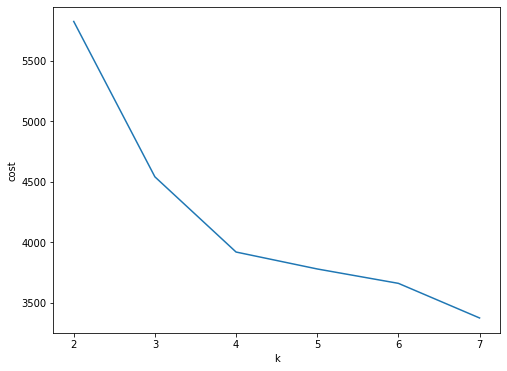

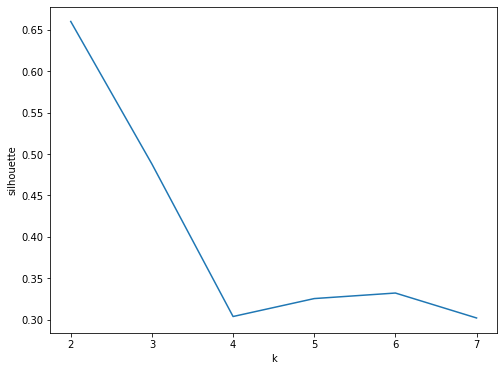

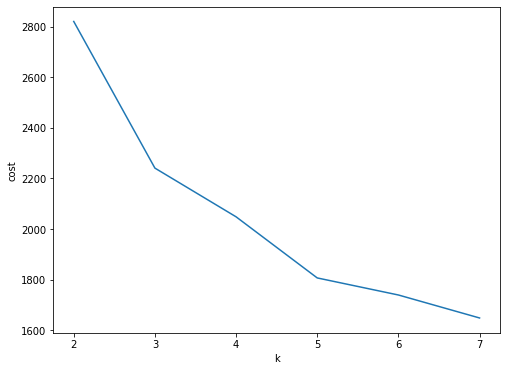

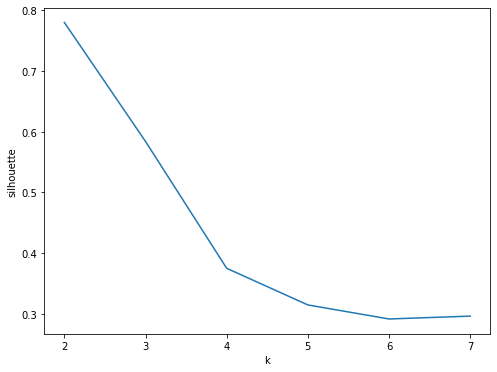

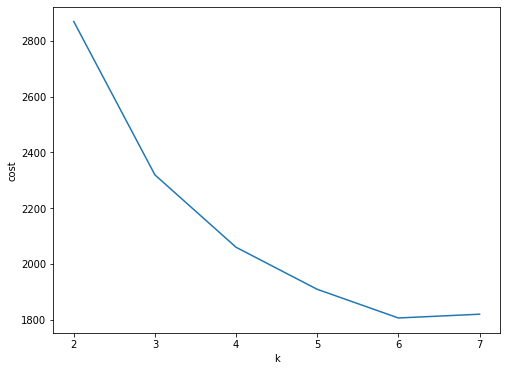

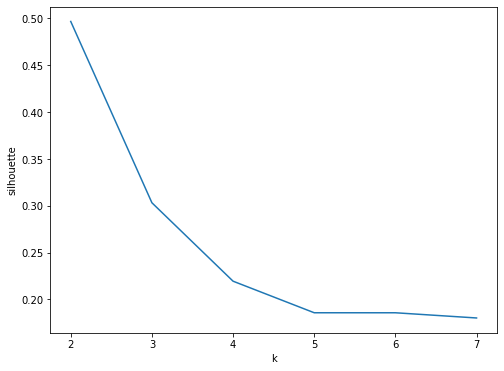

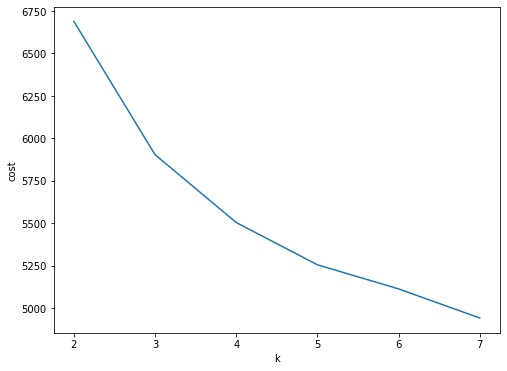

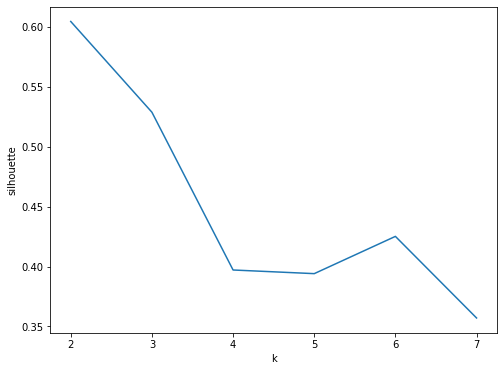

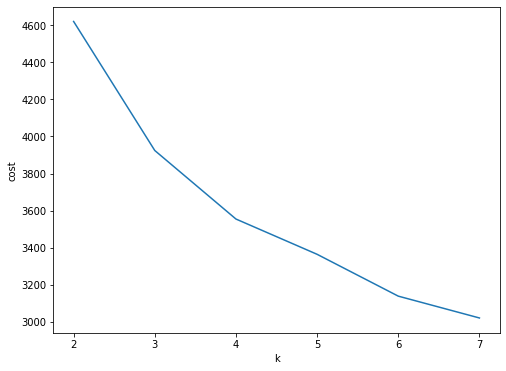

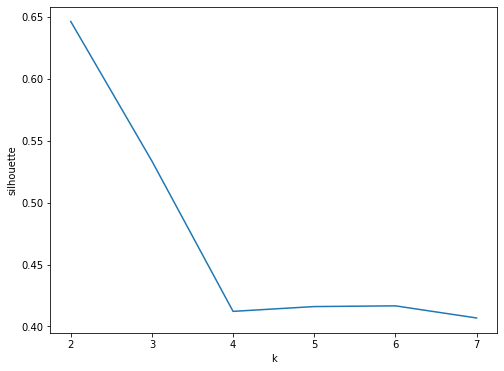

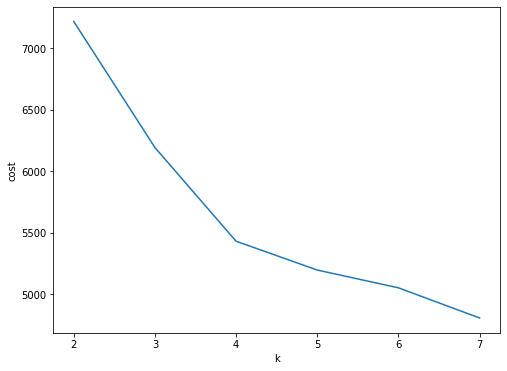

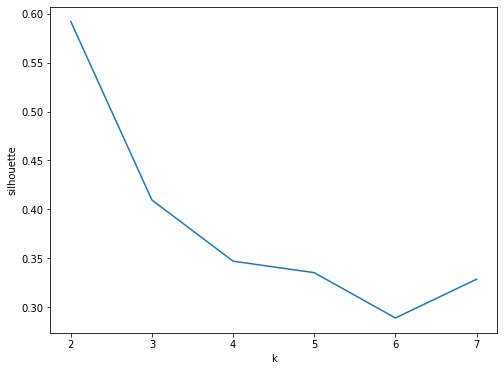

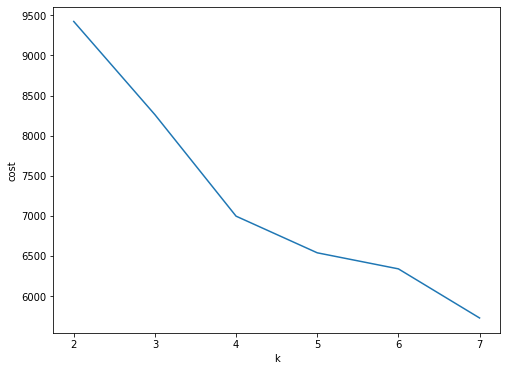

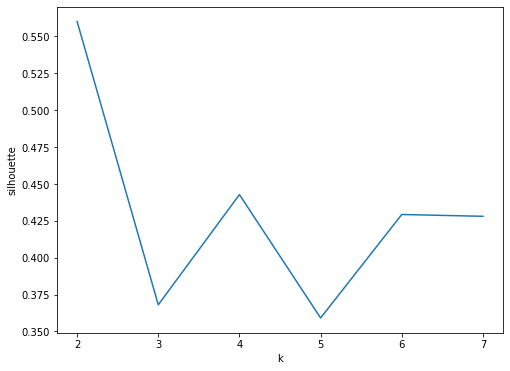

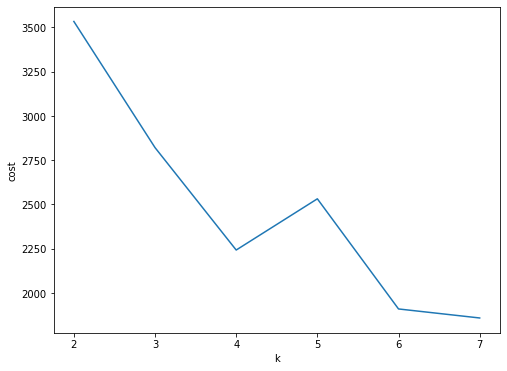

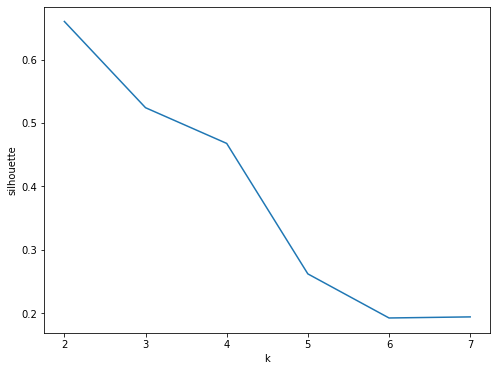

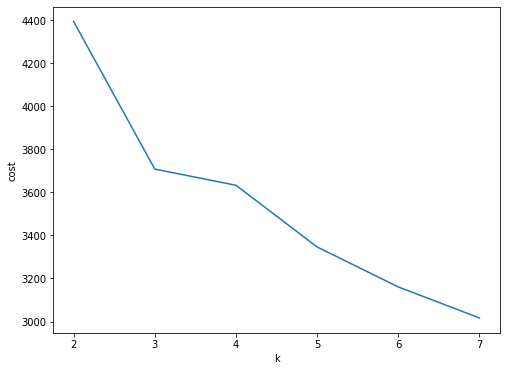

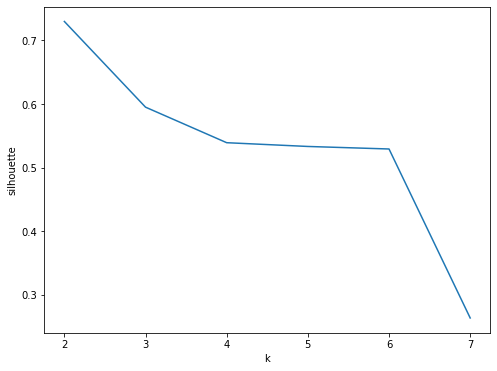

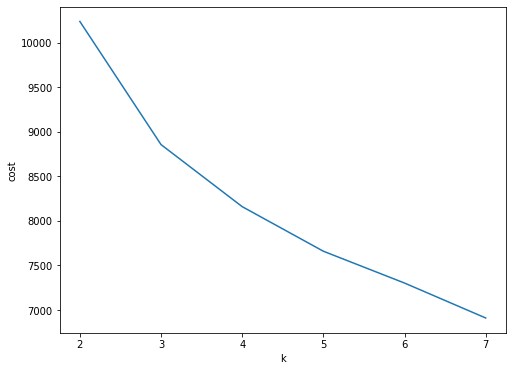

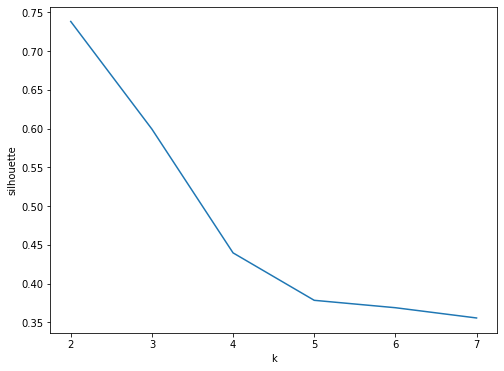

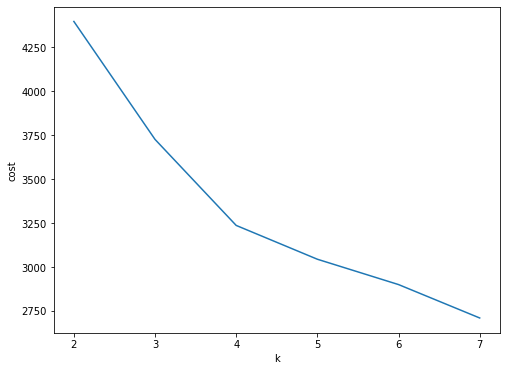

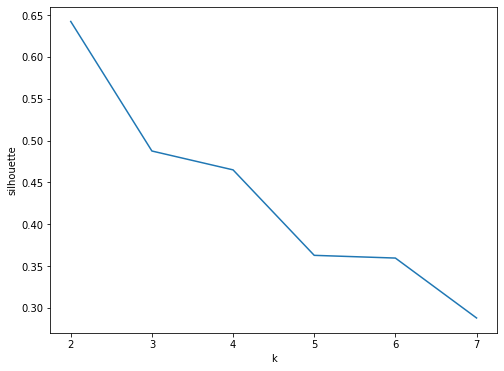

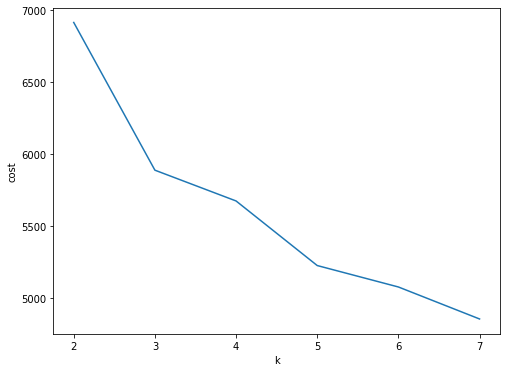

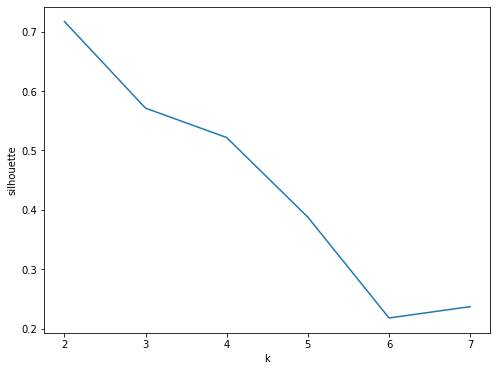

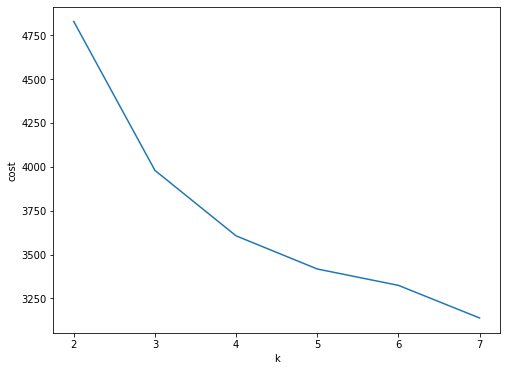

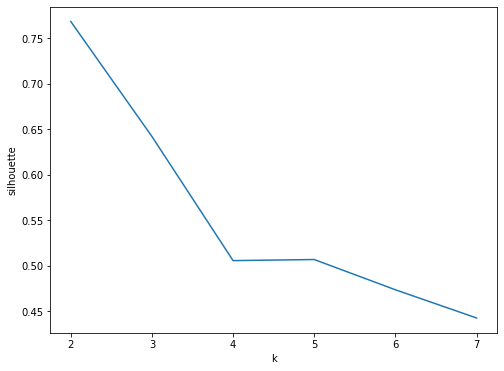

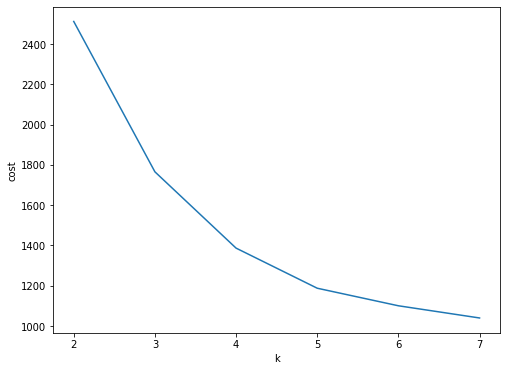

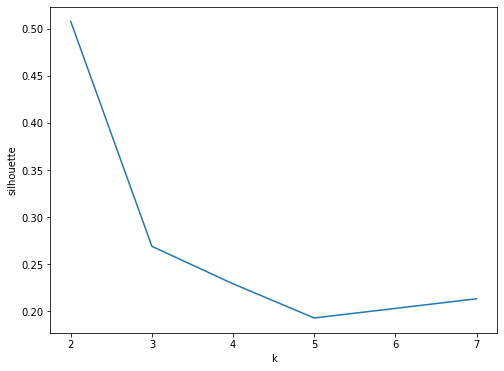

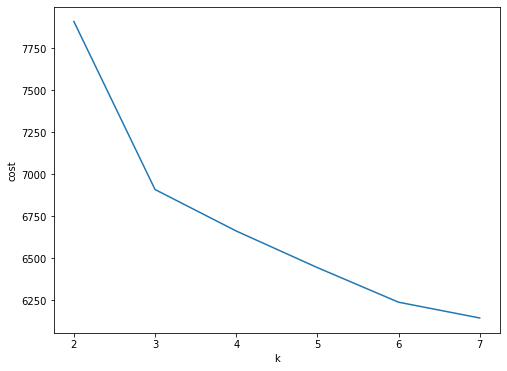

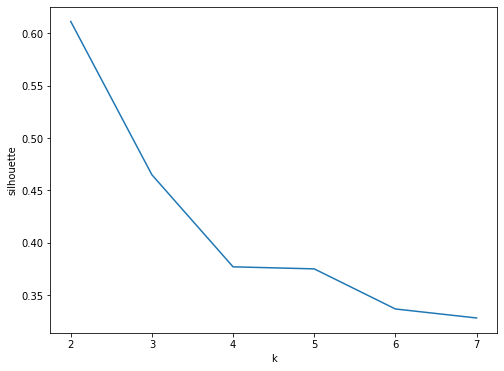

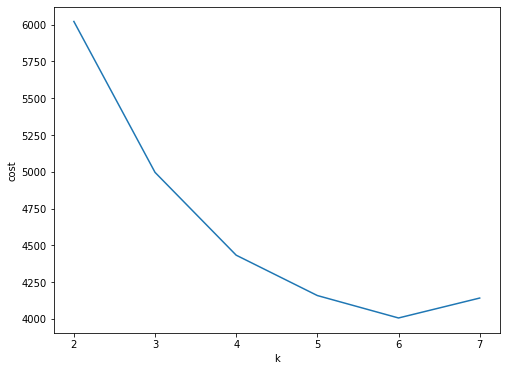

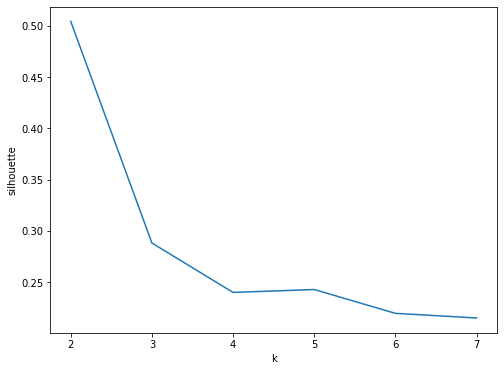

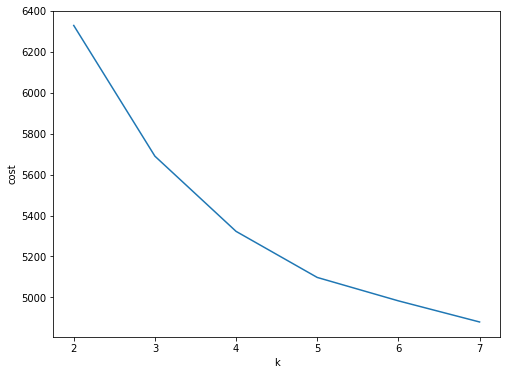

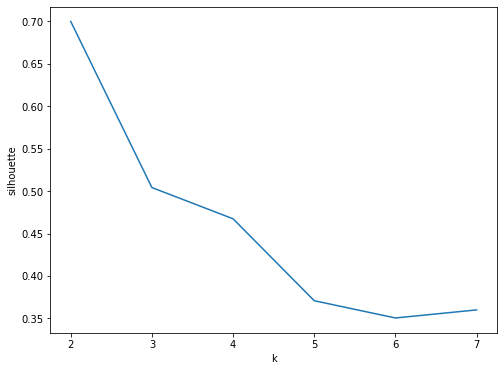

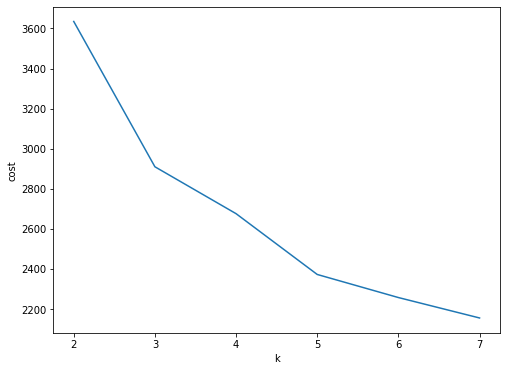

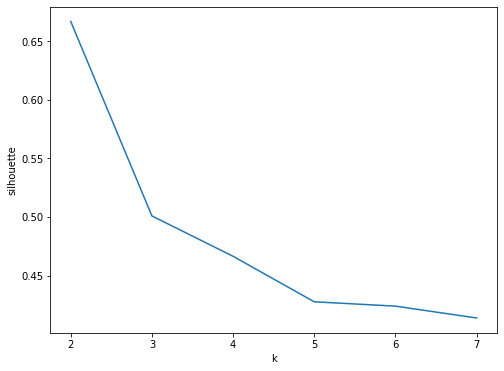

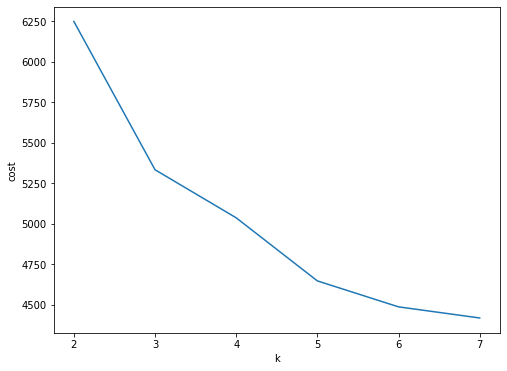

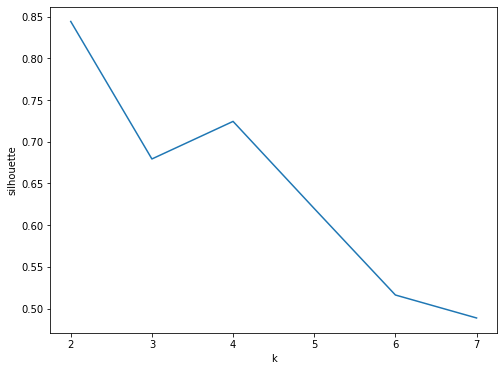

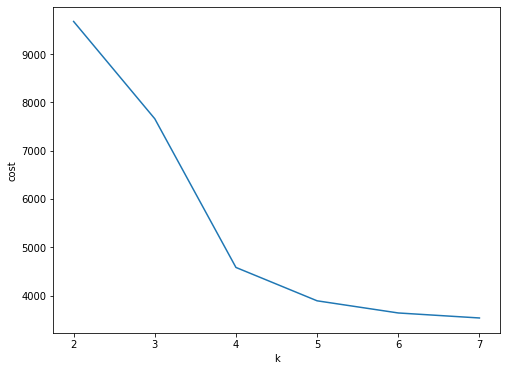

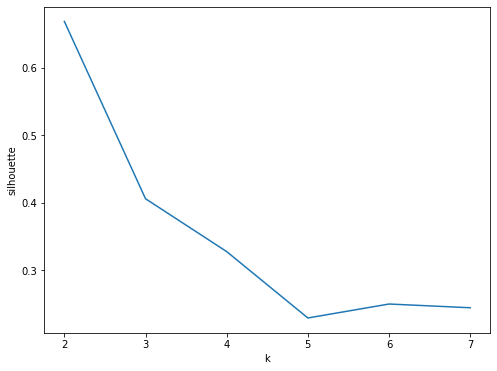

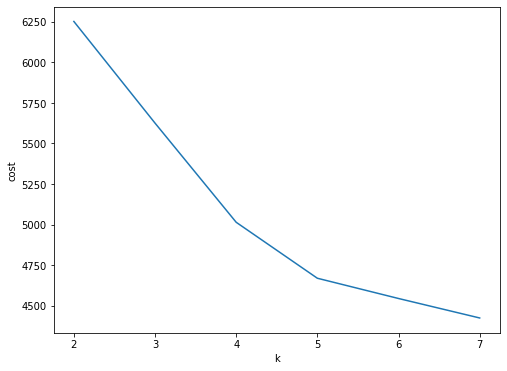

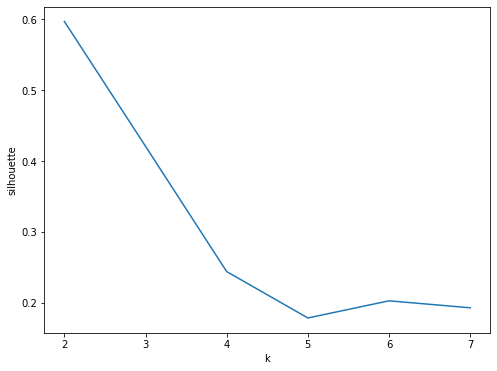

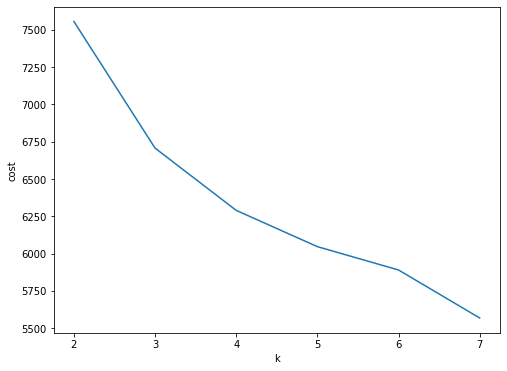

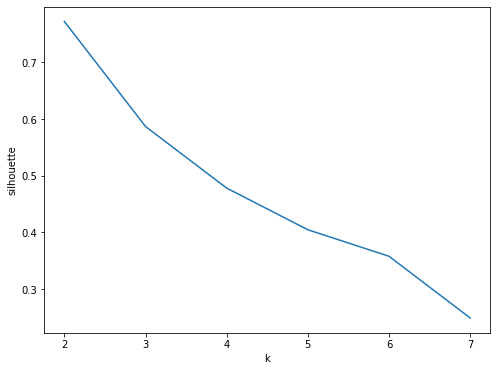

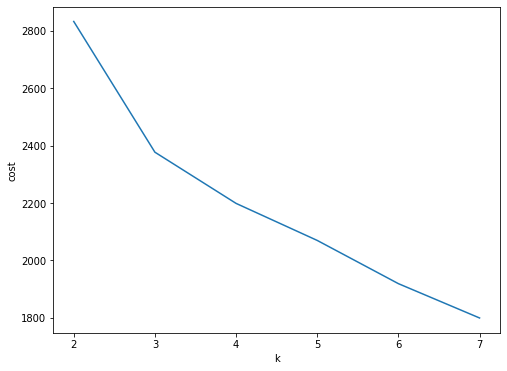

In [77]:
# model tree

def save_model(model,customer,what):
    CUSTOMER_PATH = os.path.join(STREAMING_PATH, customer)
    MODEL_PATH = os.path.join(CUSTOMER_PATH, what)
    model.save(MODEL_PATH)
    print("model "+what+" saved in: "+MODEL_PATH)
    

def prepare_model_with_tree_for_streaming(sdf):
    id_list = get_ids(sdf)

    iteration = 1
    for i in np.nditer(id_list):
        sdf_by_id = sdf.filter(sdf.uid.like(str(i)+"-"+"%"))  # filter IDs
        print("customer " + str(iteration)+": " + str(i))

        sdf_kmeans = prepare_for_kmeans(sdf_by_id)

        # sdf_kmeans=pca_for_kmeans(sdf_kmeans)

        #train_data,test_data = sdf_kmeans.randomSplit([0.7,0.3])
        kmeans_model, best_k, silhouette = kmeans(sdf_kmeans)
        print("Silhouette with squared euclidean distance = " + str(silhouette))
        print("best k= " + str(best_k))
        
        #save kmeans model
        save_model(kmeans_model,str(i),"kmeans")

        transformed = kmeans_model.transform(
            sdf_kmeans).select('uid', 'prediction', 'features')
        # transformed.show()
        sdf_join = transformed.join(sdf_by_id, on=['uid'], how='inner')
        # sdf_join.show()

        for k in range(0, best_k):
            try:
                temp_sdf = sdf_join.filter(sdf_join.prediction == k)
                temp_sdf_malicious = create_malicious_df(temp_sdf)
                temp_sdf_mixed = temp_sdf.union(temp_sdf_malicious)
                tree_data = prepare_for_decision_tree_methods(temp_sdf_mixed)

                train_data, test_data = tree_data.randomSplit([0.7, 0.3])
                dtc_model,rfc_model,gbt_model,dtc_acc, dtc_auroc, dtc_auprc, rfc_acc, rfc_auroc, rfc_auprc, gbt_acc, gbt_auroc, gbt_auprc = decision_tree(
                    train_data, test_data)
                print('A single decision tree had an accuracy of: {0:2.2f}%'.format(
                    dtc_acc*100))
                print("DT Area under ROC Curve: {:.4f}".format(dtc_auroc))
                print("DT Area under PR Curve: {:.4f}".format(dtc_auprc))
                print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(
                    rfc_acc*100))
                print("RF Area under ROC Curve: {:.4f}".format(rfc_auroc))
                print("RF Area under PR Curve: {:.4f}".format(rfc_auprc))
                print('A ensemble using GBT had an accuracy of: {0:2.2f}%'.format(
                    gbt_acc*100))
                print("GB Area under ROC Curve: {:.4f}".format(gbt_auroc))
                print("GB Area under PR Curve: {:.4f}".format(gbt_auprc))

                #save model
                save_model(dtc_model,str(i),"dtc_"+str(k))
                save_model(rfc_model,str(i),"rfc_"+str(k))
                save_model(gbt_model,str(i),"gbt_"+str(k))
            except:
                print("An exception occurred in "+ str(i)+" cluster "+str(k)) 
                

        iteration += 1

    return 

#prepare sdf
sdf_streaming=filter_dataset(sdf,"BEGIN", "2015-10-01","*","*") #last two months for streaming
prepare_model_with_tree_for_streaming(sdf_streaming)

In [90]:
#get stream daily data

def  load_sdf_daily():
    temp=spark.createDataFrame(pd.read_pickle(
        os.path.join(DATASET_PATH, "test_stream.pkl")))
    return temp

def get_model_path(customer,what):
    CUSTOMER_PATH = os.path.join(STREAMING_PATH, customer)
    MODEL_PATH = os.path.join(CUSTOMER_PATH, what)
    return MODEL_PATH


def find_tampered_data(sdf_daily):
    id_list = get_ids(sdf_daily)
    suspicious_list=[]
    for i in id_list: 
        sdf_user_data=filter_dataset(sdf_daily,"BEGIN", "END", str(i),"*")
        sdf_user_data.head
        path=get_model_path(str(i),"kmeans")
        kmeans_model = KMeansModel.load(path)
        sdf_user_data_kmeans=prepare_for_kmeans(sdf_user_data)
        prediction = kmeans_model.transform(sdf_user_data_kmeans)
        print(prediction)

    return suspicious_list

find_tampered_data(load_sdf_daily())

DataFrame[#: bigint, date: timestamp, id: string, power: array<double>, statistics: array<double>, V: boolean, N: boolean, uid: string]
DataFrame[uid: string, features: vector, prediction: int]


[]

In [89]:
sdf_test_stream=filter_dataset(sdf,"2016-11-11", "2016-11-12", "Apt10","*")
sdf_test_stream.select("*").toPandas().to_pickle(os.path.join(DATASET_PATH,"test_stream.pkl"))

# **Results**

In [84]:
def load_results():
    statistics_trees_k1 = spark.createDataFrame(pd.read_pickle(os.path.join(
        RESULTS_PATH, 'all_statistics_trees_k1.pkl')))
    statistics_trees_k1to5 = spark.createDataFrame(pd.read_pickle(os.path.join(
        RESULTS_PATH, 'all_statistics_trees_k1to5.pkl')))
    # statistics_trees_k1.head()
    # statistics_trees_k1.describe()
    return statistics_trees_k1, statistics_trees_k1to5


statistics_trees_k1, statistics_trees_k1to5 = load_results()


def collect_results(user_id, clustering, classification):
    if clustering == "None":
        if classification == "Decision Tree":
            acc = statistics_trees_k1.filter(statistics_trees_k1["id"] == user_id).select(
                statistics_trees_k1["dtc_acc"]).collect()[0][0]
            auroc = statistics_trees_k1.filter(statistics_trees_k1["id"] == user_id).select(
                statistics_trees_k1["dtc_auroc"]).collect()[0][0]
            auprc = statistics_trees_k1.filter(statistics_trees_k1["id"] == user_id).select(
                statistics_trees_k1["dtc_auprc"]).collect()[0][0]
        if classification == "Random Forest":
            acc = statistics_trees_k1.filter(statistics_trees_k1["id"] == user_id).select(
                statistics_trees_k1["rfc_acc"]).collect()[0][0]
            auroc = statistics_trees_k1.filter(statistics_trees_k1["id"] == user_id).select(
                statistics_trees_k1["rfc_auroc"]).collect()[0][0]
            auprc = statistics_trees_k1.filter(statistics_trees_k1["id"] == user_id).select(
                statistics_trees_k1["rfc_auprc"]).collect()[0][0]
        if classification == "Gradient Boosting":
            acc = statistics_trees_k1.filter(statistics_trees_k1["id"] == user_id).select(
                statistics_trees_k1["gbt_acc"]).collect()[0][0]
            auroc = statistics_trees_k1.filter(statistics_trees_k1["id"] == user_id).select(
                statistics_trees_k1["gbt_auroc"]).collect()[0][0]
            auprc = statistics_trees_k1.filter(statistics_trees_k1["id"] == user_id).select(
                statistics_trees_k1["gbt_auprc"]).collect()[0][0]
    else:  # K-Means
        if classification == "Decision Tree":
            acc = statistics_trees_k1to5.filter(statistics_trees_k1to5["id"] == user_id).select(
                statistics_trees_k1to5["dtc_acc_agg"]).collect()[0][0]
            auroc = statistics_trees_k1to5.filter(statistics_trees_k1to5["id"] == user_id).select(
                statistics_trees_k1to5["dtc_auroc_agg"]).collect()[0][0]
            auprc = statistics_trees_k1to5.filter(statistics_trees_k1to5["id"] == user_id).select(
                statistics_trees_k1to5["dtc_auprc_agg"]).collect()[0][0]
        if classification == "Random Forest":
            acc = statistics_trees_k1to5.filter(statistics_trees_k1to5["id"] == user_id).select(
                statistics_trees_k1to5["rfc_acc_agg"]).collect()[0][0]
            auroc = statistics_trees_k1to5.filter(statistics_trees_k1to5["id"] == user_id).select(
                statistics_trees_k1to5["rfc_auroc_agg"]).collect()[0][0]
            auprc = statistics_trees_k1to5.filter(statistics_trees_k1to5["id"] == user_id).select(
                statistics_trees_k1to5["rfc_auprc_agg"]).collect()[0][0]
        if classification == "Gradient Boosting":
            acc = statistics_trees_k1to5.filter(statistics_trees_k1to5["id"] == user_id).select(
                statistics_trees_k1to5["gbt_acc_agg"]).collect()[0][0]
            auroc = statistics_trees_k1to5.filter(statistics_trees_k1to5["id"] == user_id).select(
                statistics_trees_k1to5["gbt_auroc_agg"]).collect()[0][0]
            auprc = statistics_trees_k1to5.filter(statistics_trees_k1to5["id"] == user_id).select(
                statistics_trees_k1to5["gbt_auprc_agg"]).collect()[0][0]
    return acc, auroc, auprc


acc, auroc, auprc = collect_results("Apt1", "None", "Decision Tree")
print("acc= " + "{:.2f}".format(acc) + " roc= " +
      "{:.2f}".format(auroc) + " pr= "+"{:.2f}".format(auprc))
# statistics_trees_k2to5.show()

acc= 0.82 roc= 0.80 pr= 0.79


In [80]:
# create all_statistics_trees_k1to5.pkl
# def load_results_k1():
#     statistics_trees_k1 = pd.read_pickle(os.path.join(
#         RESULTS_PATH, 'all_statistics_trees_k1.pkl'))
#     # statistics_trees_k1.head()
#     # statistics_trees_k1.describe()
#     return statistics_trees_k1


def load_results_k2to5():
    statistics_trees_k2to5 = pd.read_pickle(os.path.join(
        RESULTS_PATH, 'all_statistics_trees_k2to5.pkl'))
    temp = post_processing(statistics_trees_k2to5)
    return temp


def post_processing(statistics_trees_k2):
    #statistics_trees_k2 = pd.read_pickle(os.path.join(RESULTS_PATH, 'all_statistics_trees_k2to5.pkl'))
    statistics_trees_k2['dtc_acc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.dtc_acc.to_numpy(
    )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
    statistics_trees_k2['rfc_acc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.rfc_acc.to_numpy(
    )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
    statistics_trees_k2['gbt_acc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.gbt_acc.to_numpy(
    )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
    statistics_trees_k2['dtc_auroc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.dtc_auroc.to_numpy(
    )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
    statistics_trees_k2['rfc_auroc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.rfc_auroc.to_numpy(
    )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
    statistics_trees_k2['gbt_auroc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.gbt_auroc.to_numpy(
    )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
    statistics_trees_k2['dtc_auprc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.dtc_auprc.to_numpy(
    )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
    statistics_trees_k2['rfc_auprc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.rfc_auprc.to_numpy(
    )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
    statistics_trees_k2['gbt_auprc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.gbt_auprc.to_numpy(
    )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
    return statistics_trees_k2


statistics_trees_k1 = load_results_k1()
statistics_trees_k2to5 = load_results_k2to5()


def create_k1to5(statistics_trees_k2to5):
    for index, row in statistics_trees_k2to5.iterrows():
        #print(row['gbt_auprc_agg'], row['gbt_auprc_agg'])
        # row['dtc_acc_agg'] == float("NaN"):
        if math.isnan(row['dtc_acc_agg']):
            dtc_acc, dtc_auroc, dtc_auprc = collect_results(
                row["id"], "None", "Decision Tree")
            statistics_trees_k2to5.at[index,"dtc_acc_agg"]=dtc_acc
            statistics_trees_k2to5.at[index,"dtc_auroc_agg"]=dtc_auroc
            statistics_trees_k2to5.at[index,"dtc_auprc_agg"]=dtc_auprc
            
            rfc_acc, dtc_auroc, rfc_auprc = collect_results(
                row["id"], "None", "Random Forest")
            statistics_trees_k2to5.at[index,"rfc_acc_agg"]=rfc_acc
            statistics_trees_k2to5.at[index,"rfc_auroc_agg"]=dtc_auroc
            statistics_trees_k2to5.at[index,"rfc_auprc_agg"]=rfc_auprc
            
            gbt_acc, gbt_auroc, gbt_auprc = collect_results(
                row["id"], "None", "Gradient Boosting")
            statistics_trees_k2to5.at[index,"gbt_acc_agg"]=gbt_acc
            statistics_trees_k2to5.at[index,"gbt_auroc_agg"]=gbt_auroc
            statistics_trees_k2to5.at[index,"gbt_auprc_agg"]=gbt_auprc
    return statistics_trees_k2to5


statistics_trees_k1to5=create_k1to5(statistics_trees_k2to5)
statistics_trees_k1to5.head()
#statistics_trees_k1to5.to_pickle(os.path.join(RESULTS_PATH,"all_statistics_trees_k1to5.pkl"))
#statistics_trees_k2to5.isnull().values.any()
#acc, auroc, auprc = collect_results("Apt1", "None", "Decision Tree")
#print("acc= " + "{:.2f}".format(acc) + " roc= " +"{:.2f}".format(auroc) + " pr= "+"{:.2f}".format(auprc))
# statistics_trees_k2to5.show()

id  k  Silhouette     n_per_k  \
0  Apt107  2    0.617533  [440, 340]   
1   Apt21  2    0.522087  [276, 434]   
2    Apt8  2    0.645447  [375, 414]   
3    Apt4  2    0.804719  [606, 178]   
4   Apt30  2    0.999856    [771, 1]   

                                    dtc_acc  \
0  [0.8849206349206349, 0.9424083769633508]   
1  [0.9487179487179487, 0.8555555555555555]   
2  [0.7973568281938326, 0.9104477611940298]   
3  [0.8373983739837398, 0.9528301886792453]   
4                 [0.8568376068376068, nan]   

                                  dtc_auroc  \
0   [0.6865483035319391, 0.782169521299956]   
1  [0.8860759493670886, 0.6923690580985915]   
2  [0.6237883051907442, 0.8026411099348081]   
3  [0.4306437389770723, 0.7777777777777778]   
4                 [0.6050602849835587, nan]   

                                   dtc_auprc  \
0   [0.8006187053912557, 0.9004790493158441]   
1   [0.9366482758652548, 0.6676525295793813]   
2  [0.48312854830245616, 0.8747796822450362]   
3    [0.618923771220226, 0.8892597063670133]   
4                   [0.735998794040322, nan]   

                                    rfc_acc  \
0   [0.876984126984127, 0.9633507853403142]   
1  [0.9230769230769231, 0.8888888888888888]   
2  [0.7973568281938326, 0.8470149253731343]   
3  [0.8428184281842819, 0.8962264150943396]   
4                 [0.8910256410256411, nan]   

                                  rfc_auroc  \
0  [0.9130283692424336, 0.9782608695652174]   
1  [0.9552852211080057, 0.9308978873239441]   
2  [0.9306597873671032, 0.9349752047695994]   
3  [0.9326131687242791, 0.9535256410256409]   
4                 [0.9531877968578725, nan]   

                                  rfc_auprc  ...  \
0  [0.9088065658658222, 0.9834174976981664]  ...   
1  [0.9796496285933448, 0.9278659615785673]  ...   
2   [0.9042054216552913, 0.953303064079851]  ...   
3  [0.9264193006395534, 0.9485057508409114]  ...   
4                 [0.9600684505799836, nan]  ...   

                                  gbt_auprc dtc_acc_agg rfc_acc_agg  \
0  [0.9450992779865668, 0.9887935635004522]    0.909979    0.914631   
1   [0.970402448559396, 0.8930045974580708]    0.891771    0.902179   
2  [0.9317857261026917, 0.9329099658112635]    0.856697    0.823413   
3  [0.9455542280193481, 0.9175270628070211]    0.863606    0.854944   
4                 [0.9688447899695461, nan]    0.832230    0.867550   

   gbt_acc_agg  dtc_auroc_agg  rfc_auroc_agg  gbt_auroc_agg  dtc_auprc_agg  \
0     0.932627       0.728229       0.941463       0.958456       0.844148   
1     0.858936       0.767669       0.940378       0.936115       0.772220   
2     0.881958       0.717635       0.932924       0.928754       0.688634   
3     0.844188       0.509457       0.937361       0.919129       0.680301   
4     0.909492       0.866205       0.950251       0.965811       0.750392   

   rfc_auprc_agg  gbt_auprc_agg  
0       0.941329       0.964146  
1       0.947996       0.923092  
2       0.929968       0.932376  
3       0.931434       0.939191  
4       0.916154       0.964753  

[5 rows x 22 columns]

In [23]:
# statistics_trees_k2 = pd.read_pickle(os.path.join(
#     BASE_PATH, 'all_statistics_trees_k2to5.pkl'))
# statistics_trees_k2['dtc_acc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.dtc_acc.to_numpy(
# )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
# statistics_trees_k2['rfc_acc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.rfc_acc.to_numpy(
# )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
# statistics_trees_k2['gbt_acc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.gbt_acc.to_numpy(
# )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
# statistics_trees_k2['dtc_auroc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.dtc_auroc.to_numpy(
# )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
# statistics_trees_k2['rfc_auroc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.rfc_auroc.to_numpy(
# )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
# statistics_trees_k2['gbt_auroc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.gbt_auroc.to_numpy(
# )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
# statistics_trees_k2['dtc_auprc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.dtc_auprc.to_numpy(
# )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
# statistics_trees_k2['rfc_auprc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.rfc_auprc.to_numpy(
# )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]
# statistics_trees_k2['gbt_auprc_agg'] = [np.dot(statistics_trees_k2.n_per_k.to_numpy()[i], statistics_trees_k2.gbt_auprc.to_numpy(
# )[i])/sum(statistics_trees_k2.n_per_k.to_numpy()[i]) for i in range(0, len(statistics_trees_k2.n_per_k.to_numpy()))]

# # # statistics_trees_k2['rfc_acc_agg'].isnull().sum()

# # # post processing
# # # statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['dtc_acc_agg']] = 0.8568376068376068
# # # statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['rfc_acc_agg']] = 0.8910256410256411
# # # statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['gbt_acc_agg']] = 0.9220183486238532
# # # statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['dtc_auroc_agg']] = 0.735998794040322
# # # statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['rfc_auroc_agg']] = 0.9531877968578725
# # # statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['gbt_auroc_agg']] = 0.9220183486238532
# # # statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['dtc_auprc_agg']] = 0.735998794040322
# # # statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['rfc_auprc_agg']] = 0.9531877968578725
# # # statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt30', ['gbt_auprc_agg']] = 0.9688447899695461

# # # statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt59', ['dtc_acc']] = 0.8008849557522124
# # # statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt59', ['rfc_acc']] = 0.834070796460177
# # # statistics_trees_k2.loc[statistics_trees_k2['id']=='Apt59', ['gbt_acc']] = 0.8561946902654868

# # statistics_trees_k2.head(5)
# # # df.describe()

id  k  Silhouette     n_per_k  \
0  Apt107  2    0.617533  [440, 340]   
1   Apt21  2    0.522087  [276, 434]   
2    Apt8  2    0.645447  [375, 414]   
3    Apt4  2    0.804719  [606, 178]   
4   Apt30  2    0.999856    [771, 1]   

                                    dtc_acc  \
0  [0.8849206349206349, 0.9424083769633508]   
1  [0.9487179487179487, 0.8555555555555555]   
2  [0.7973568281938326, 0.9104477611940298]   
3  [0.8373983739837398, 0.9528301886792453]   
4                 [0.8568376068376068, nan]   

                                  dtc_auroc  \
0   [0.6865483035319391, 0.782169521299956]   
1  [0.8860759493670886, 0.6923690580985915]   
2  [0.6237883051907442, 0.8026411099348081]   
3  [0.4306437389770723, 0.7777777777777778]   
4                 [0.6050602849835587, nan]   

                                   dtc_auprc  \
0   [0.8006187053912557, 0.9004790493158441]   
1   [0.9366482758652548, 0.6676525295793813]   
2  [0.48312854830245616, 0.8747796822450362]   
3    [0.618923771220226, 0.8892597063670133]   
4                   [0.735998794040322, nan]   

                                    rfc_acc  \
0   [0.876984126984127, 0.9633507853403142]   
1  [0.9230769230769231, 0.8888888888888888]   
2  [0.7973568281938326, 0.8470149253731343]   
3  [0.8428184281842819, 0.8962264150943396]   
4                 [0.8910256410256411, nan]   

                                  rfc_auroc  \
0  [0.9130283692424336, 0.9782608695652174]   
1  [0.9552852211080057, 0.9308978873239441]   
2  [0.9306597873671032, 0.9349752047695994]   
3  [0.9326131687242791, 0.9535256410256409]   
4                 [0.9531877968578725, nan]   

                                  rfc_auprc  ...  \
0  [0.9088065658658222, 0.9834174976981664]  ...   
1  [0.9796496285933448, 0.9278659615785673]  ...   
2   [0.9042054216552913, 0.953303064079851]  ...   
3  [0.9264193006395534, 0.9485057508409114]  ...   
4                 [0.9600684505799836, nan]  ...   

                                  gbt_auprc dtc_acc_agg rfc_acc_agg  \
0  [0.9450992779865668, 0.9887935635004522]    0.909979    0.914631   
1   [0.970402448559396, 0.8930045974580708]    0.891771    0.902179   
2  [0.9317857261026917, 0.9329099658112635]    0.856697    0.823413   
3  [0.9455542280193481, 0.9175270628070211]    0.863606    0.854944   
4                 [0.9688447899695461, nan]         NaN         NaN   

   gbt_acc_agg  dtc_auroc_agg  rfc_auroc_agg  gbt_auroc_agg  dtc_auprc_agg  \
0     0.932627       0.728229       0.941463       0.958456       0.844148   
1     0.858936       0.767669       0.940378       0.936115       0.772220   
2     0.881958       0.717635       0.932924       0.928754       0.688634   
3     0.844188       0.509457       0.937361       0.919129       0.680301   
4          NaN            NaN            NaN            NaN            NaN   

   rfc_auprc_agg  gbt_auprc_agg  
0       0.941329       0.964146  
1       0.947996       0.923092  
2       0.929968       0.932376  
3       0.931434       0.939191  
4            NaN            NaN  

[5 rows x 22 columns]

In [39]:
# # post processing
# best_result = statistics_trees_k1.join(
#     statistics_trees_k2, lsuffix='_1', rsuffix='_2')

# best_result["max_dtc_acc"] = best_result[[
#     "dtc_acc_1", "dtc_acc_agg"]].max(axis=1)
# best_result["max_rfc_acc"] = best_result[[
#     "rfc_acc_1", "rfc_acc_agg"]].max(axis=1)
# best_result["max_gbt_acc"] = best_result[[
#     "gbt_acc_1", "gbt_acc_agg"]].max(axis=1)
# best_result["max_dtc_auprc"] = best_result[[
#     "dtc_auprc_1", "dtc_auprc_agg"]].max(axis=1)
# best_result["max_rfc_auprc"] = best_result[[
#     "rfc_auprc_1", "rfc_auprc_agg"]].max(axis=1)
# best_result["max_gbt_auprc"] = best_result[[
#     "gbt_auprc_1", "gbt_auprc_agg"]].max(axis=1)
# best_result["max_dtc_auroc"] = best_result[[
#     "dtc_auroc_1", "dtc_auroc_agg"]].max(axis=1)
# best_result["max_rfc_auroc"] = best_result[[
#     "rfc_auroc_1", "rfc_auroc_agg"]].max(axis=1)
# best_result["max_gbt_auroc"] = best_result[[
#     "gbt_auroc_1", "gbt_auroc_agg"]].max(axis=1)


# #best_result.loc[best_result['id_2']=='Apt30', ['dtc_acc']] = 0.8325688073394495
# #best_result.loc[best_result['id_2']=='Apt30', ['rfc_acc']] = 0.8738532110091743
# #best_result.loc[best_result['id_2']=='Apt30', ['gbt_acc']] = 0.9220183486238532

# #best_result.loc[best_result['id_2']=='Apt59', ['dtc_acc']] = 0.8008849557522124
# #best_result.loc[best_result['id_2']=='Apt59', ['rfc_acc']] = 0.834070796460177
# #best_result.loc[best_result['id_2']=='Apt59', ['gbt_acc']] = 0.8561946902654868

# # best_result.describe()
# pd.set_option('display.max_columns', None)
# # best_result.head(10)
# # best_result['max_dtc_acc'].isnull().values.any()
# # best_result['rfc_acc'].isnull().sum()
# #index = best_result['rfc_acc'].index[best_result['rfc_acc'].apply(np.isnan)]
# FINAL = best_result[["max_dtc_acc", "max_dtc_auroc", "max_dtc_auprc",
#                      "max_rfc_acc", "max_rfc_auroc", "max_rfc_auprc",
#                      "max_gbt_acc", "max_gbt_auroc", "max_gbt_auprc"]]
# FINAL.head()
# FINAL.describe()
# # print(index)

max_dtc_acc  max_dtc_auroc  max_dtc_auprc  max_rfc_acc  max_rfc_auroc  \
count   114.000000     114.000000     114.000000   114.000000     114.000000   
mean      0.870709       0.835670       0.813200     0.881887       0.944657   
std       0.029463       0.036032       0.045980     0.023276       0.015297   
min       0.771368       0.728673       0.667630     0.824268       0.890380   
25%       0.852739       0.819133       0.785576     0.865599       0.936808   
50%       0.871024       0.839726       0.815945     0.884394       0.945934   
75%       0.890409       0.862117       0.844347     0.896592       0.955148   
max       0.935142       0.897049       0.912430     0.933614       0.977646   

       max_rfc_auprc  max_gbt_acc  max_gbt_auroc  max_gbt_auprc  
count     114.000000   114.000000     114.000000     114.000000  
mean        0.951019     0.886380       0.944777       0.949288  
std         0.017476     0.020901       0.013199       0.014653  
min         0.860156     0.841004       0.907535       0.903486  
25%         0.940936     0.872348       0.934945       0.940630  
50%         0.953583     0.886070       0.945682       0.950789  
75%         0.962797     0.900329       0.954273       0.961161  
max         0.978013     0.947107       0.972976       0.976044

In [40]:
# vector24 = pd.read_pickle(os.path.join(
#     BASE_PATH, 'all_statistics_trees_k1_24vevtor.pkl'))
# vector24.describe()

dtc_acc   dtc_auroc   dtc_auprc     rfc_acc   rfc_auroc   rfc_auprc  \
count  114.000000  114.000000  114.000000  114.000000  114.000000  114.000000   
mean     0.698847    0.629296    0.613775    0.752136    0.833073    0.818982   
std      0.041819    0.088972    0.087809    0.039653    0.040390    0.048400   
min      0.612705    0.382540    0.387092    0.656315    0.743662    0.719664   
25%      0.672287    0.577446    0.567187    0.726285    0.808101    0.786430   
50%      0.693319    0.641618    0.628991    0.752058    0.830690    0.821410   
75%      0.726387    0.689256    0.668214    0.773951    0.854860    0.848418   
max      0.812500    0.786215    0.835466    0.874494    0.954278    0.939855   

          gbt_acc   gbt_auroc   gbt_auprc  
count  114.000000  114.000000  114.000000  
mean     0.767208    0.845708    0.833801  
std      0.035756    0.037327    0.043266  
min      0.682773    0.742735    0.715381  
25%      0.743061    0.822856    0.804272  
50%      0.768803    0.846749    0.837640  
75%      0.788827    0.865155    0.865569  
max      0.852227    0.938747    0.936961

# **GUI**

# **Other**

## **Useful Commands**

In [ ]:
# .describe().show()
# .printSchema()
# .collect()
# .count()

## **Old**

In [ ]:
# #create json data from stored dataframe

# def to_json(final):
#     PERIOD=60

#     data_for_json=final.loc[:, final.columns != 'date']

#     def date_to_str(o):
#         if isinstance(o, datetime.datetime):
#             return o.__str__()

#     json_dataframe = pd.DataFrame(columns=['data']) #creates a new dataframe that's empty
#     L  = []

#     import json
#     import datetime
#     import time

#     r, c = data_for_json.shape
#     for i in range(0, r):
#         for j in range(0, c):
#             data = {}
#             data['id'] = data_for_json.columns.values[j]
#             data['power'] = data_for_json.iloc[i][j]
#             data['date']=data_for_json.index.tolist()[i]
#             json_data = json.dumps(data,default=date_to_str)
#             L.append(json_data)
#             #json_dataframe=json_dataframe.append(json_data,ignore_index=True)

#     json_dataframe = pd.DataFrame(L, columns=['data'])
#     return json_dataframe

In [ ]:
# #load by schema

# schema = StructType([
#   StructField("num", IntegerType()),
#     StructField("date", TimestampType()),
#     StructField("id", StringType()),
#   StructField("power", ArrayType(
#       StructType([
#           StructField("H0", FloatType(), True),
#           StructField("H1", FloatType(), True),
#           StructField("H2", FloatType(), True),
#           StructField("H3", FloatType(), True),
#           StructField("H4", FloatType(), True),
#           StructField("H5", FloatType(), True),
#           StructField("H6", FloatType(), True),
#           StructField("H7", FloatType(), True),
#           StructField("H8", FloatType(), True),
#           StructField("H9", FloatType(), True),
#           StructField("H10", FloatType(), True),
#           StructField("H11", FloatType(), True),
#           StructField("H12", FloatType(), True),
#           StructField("H13", FloatType(), True),
#           StructField("H14", FloatType(), True),
#           StructField("H15", FloatType(), True),
#           StructField("H16", FloatType(), True),
#           StructField("H17", FloatType(), True),
#           StructField("H18", FloatType(), True),
#           StructField("H19", FloatType(), True),
#           StructField("H20", FloatType(), True),
#           StructField("H21", FloatType(), True),
#           StructField("H22", FloatType(), True),
#           StructField("H23", FloatType(), True)
#       ])
#    )
#              )])

# a = spark.read.format('csv').schema(schema).option("header", "true").load(DATASET_PATH+"f.csv")
# a.show()

In [ ]:
# #test pandas_udf

# my_schema = StructType([
#     StructField("id", IntegerType()),
#     StructField("age", IntegerType())])
# df=spark.read.csv("test.csv", header=True,schema=my_schema)
# df.show()
# df.printSchema()

# def plus_one(a):
#     return a+1

# plus_one_udf = pandas_udf(plus_one, returnType=IntegerType())

# df.select(plus_one_udf(col("age"))).show()

In [ ]:
# #test pandas_udf (for array input)

# df = spark.createDataFrame([([1,2,3,4,5,6],'val1'),([4,5,6,7,8,9],'val2')],['col1','col2'])
# df.show()

# @pandas_udf(ArrayType(LongType()))
# def func(v):
#     res=[]
#     for row in v:
#         temp=[]
#         for k in range(len(row)):
#             if (k<=2) or (k>4):
#                 temp.append(row[k])
#             else:
#                 temp.append(row[k]*0)
#         res.append(temp)
#     return pd.Series(res)

# df.withColumn('col3',func(df.col1)).show()